# Dependencies

In [22]:
from __future__ import annotations

import itertools
import math
from pathlib import Path
import re
from typing import Any, Iterable, Optional, Union
import warnings
import sys

import geopandas
import matplotlib
import matplotlib.axes
import matplotlib.cm
import matplotlib.figure
import matplotlib.pyplot
import mpl_toolkits.mplot3d
import numpy
import pandas
import plotly.graph_objs
# import seaborn
from shapely import Point
from sklearn.linear_model import LinearRegression
from scipy.optimize import Bounds
import scipy.stats

sys.path.append('../Packages/tectoniq')
from tectoniq.datasets import Mercedes
from tectoniq.functions import IFunction, Polynomial, Power, PowerWithOffset
from tectoniq.geometry import distance, distance_to_line, distance_to_line_segment
from tectoniq.optimization import fit_function


from sklearn import metrics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

def min_max_scaling(data):
    """
    Perform Min-Max scaling on the input data.
    """
    scaler = MinMaxScaler()
    return pd.Series(scaler.fit_transform(data.values.reshape(-1, 1)).flatten(), index=data.index)

def standard_scaling(data):
    """
    Perform Standard scaling (z-score normalization) on the input data.
    """
    scaler = StandardScaler()
    return pd.Series(scaler.fit_transform(data.values.reshape(-1, 1)).flatten(), index=data.index)

def robust_scaling(data):
    """
    Perform Robust scaling on the input data.
    """
    scaler = RobustScaler()
    return pd.Series(scaler.fit_transform(data.values.reshape(-1, 1)).flatten(), index=data.index)

def log_transform(data):
    """
    Perform log transformation on the input data.
    Adds a small constant to avoid log(0).
    """
    return np.log(data + 1e-10)

def winsorization(data, limits=(0.05, 0.95)):
    """
    Perform Winsorization on the input data.
    """
    lower_limit = data.quantile(limits[0])
    upper_limit = data.quantile(limits[1])
    return data.clip(lower=lower_limit, upper=upper_limit)

def log_then_min_max(data):
    """
    Perform log transformation followed by Min-Max scaling.
    """
    log_data = log_transform(data)
    return min_max_scaling(log_data)

def winsor_then_min_max(data, limits=(0.05, 0.95)):
    """
    Perform Winsorization followed by Min-Max scaling.
    """
    winsor_data = winsorization(data, limits)
    return min_max_scaling(winsor_data)

    
def calculate_weights(differences, penalty_factor=1):
    # Higher penalty factor will penalize lower differences more
    return penalty_factor / (differences + penalty_factor)

def weighted_f1_score(data_frame, gold_threshold, ore_diff_threshold, penalty_factor=1):
    data_frame["Actual"] = data_frame[GOLD_COLUMN] >= gold_threshold
    data_frame["Predicted"] = data_frame[ORE_DIFFERENCE_COLUMN] <= ore_diff_threshold
    
    data_frame["Weight"] = calculate_weights(data_frame[ORE_DIFFERENCE_COLUMN], penalty_factor)
    
    tp = data_frame[data_frame["Actual"] & data_frame["Predicted"]]
    fp = data_frame[~data_frame["Actual"] & data_frame["Predicted"]]
    fn = data_frame[data_frame["Actual"] & ~data_frame["Predicted"]]
    tn = data_frame[~data_frame["Actual"] & ~data_frame["Predicted"]]
    
    weighted_tp = tp["Weight"].sum()
    weighted_fp = fp["Weight"].sum()
    weighted_fn = fn["Weight"].sum()
    weighted_tn = tn["Weight"].sum()
    
    weighted_accuracy = (weighted_tp + weighted_tn) / (weighted_tp + weighted_tn + weighted_fp + weighted_fn)
    weighted_precision = weighted_tp / (weighted_tp + weighted_fp)
    weighted_recall = weighted_tp / (weighted_tp + weighted_fn)
    
    if weighted_precision + weighted_recall == 0:
        return 0
    
    weighted_f1 = 2 * (weighted_precision * weighted_recall) / (weighted_precision + weighted_recall)
    
    return round(weighted_f1, 4), round(weighted_precision, 4), round(weighted_recall, 4), round(weighted_accuracy, 4), tp, fp, fn, tn

def penalty_function(ore_difference, max_penalty=10):
    return max_penalty / (ore_difference + 0.1)  

def custom_loss(data_frame, gold_threshold, ore_diff_threshold, max_penalty=10):
    data_frame["Actual"] = data_frame[GOLD_COLUMN] >= gold_threshold
    data_frame["Predicted"] = data_frame[ORE_DIFFERENCE_COLUMN] <= ore_diff_threshold
    
    false_positives = data_frame[~data_frame["Actual"] & data_frame["Predicted"]]
    false_negatives = data_frame[data_frame["Actual"] & ~data_frame["Predicted"]]
    
    fp_penalties = false_positives[ORE_DIFFERENCE_COLUMN].apply(penalty_function, max_penalty=max_penalty)
    fn_penalties = false_negatives[ORE_DIFFERENCE_COLUMN].apply(penalty_function, max_penalty=max_penalty)
    
    total_loss = fp_penalties.sum() + fn_penalties.sum()
    
    return total_loss

### Experiments

In [74]:
import os

exp_dir = "/Users/zeerakwyne/Documents/redmarble/experiments"
os.listdir(exp_dir)

all_exp = pandas.DataFrame()
for file in os.listdir(exp_dir):
    if file.endswith(".csv"):
        df = pandas.read_csv(os.path.join(exp_dir, file))
        df['Experiment Name'] = file.split('.csv')[0]
        all_exp = pandas.concat([all_exp, df])
all_exp = all_exp[~all_exp['Elements'].isna()]
all_exp = all_exp[['Experiment Name', 'Name', 'difference_threshold', 'normalization_vector', 'target_threshold',
       'Weighted accuracy', 'Weighted f1', 'Weighted precision',
       'Weighted recall', 'fn', 'fp', 'tn', 'tp', 'Loss']]

In [75]:
all_exp

Experiment Name                  Name  \
0   Fe Ca Na K Al Mg CCPI Ishikawa K_(Al-Na) As       classy-bass-943   
1   Fe Ca Na K Al Mg CCPI Ishikawa K_(Al-Na) As    redolent-snipe-875   
2   Fe Ca Na K Al Mg CCPI Ishikawa K_(Al-Na) As        sassy-loon-690   
3   Fe Ca Na K Al Mg CCPI Ishikawa K_(Al-Na) As    victorious-hog-183   
4   Fe Ca Na K Al Mg CCPI Ishikawa K_(Al-Na) As    fortunate-moth-637   
..                                          ...                   ...   
29               Fe Ca Na K Al Mg CCPI Ishikawa      stylish-tern-737   
30               Fe Ca Na K Al Mg CCPI Ishikawa       zealous-swan-19   
31               Fe Ca Na K Al Mg CCPI Ishikawa    adaptable-toad-679   
32               Fe Ca Na K Al Mg CCPI Ishikawa  adventurous-mole-333   
33               Fe Ca Na K Al Mg CCPI Ishikawa        awesome-kit-52   

    difference_threshold                               normalization_vector  \
0                    2.5  [ 1.2  2.4  2.4  4.8  3.6  2.4  0.3  0.3  0.5 ...   
1                    2.5          [1.2 2.4 2.4 4.8 3.6 2.4 0.3 0.3 0.5 0.1]   
2                    2.5  [ 1.15  2.3   2.3   4.6   3.45  2.3   0.25  0....   
3                    2.5  [1.15 2.3  2.3  4.6  3.45 2.3  0.25 0.25 0.5  ...   
4                    2.5  [ 1.1  2.2  2.2  4.4  3.3  2.2  0.2  0.2  0.5 ...   
..                   ...                                                ...   
29                   1.0                  [1.1 2.2 2.2 4.4 3.3 2.2 0.1 0.1]   
30                   1.5          [1.05 2.1  2.1  4.2  3.15 2.1  0.05 0.05]   
31                   1.0                  [1.1 2.2 2.2 4.4 3.3 2.2 0.1 0.1]   
32                   2.0  [1.05  2.1   2.1   4.2   3.15  2.1   0.025 0.025]   
33                   2.0  [1.05  2.1   2.1   4.2   3.15  2.1   0.025 0.025]   

    target_threshold  Weighted accuracy  Weighted f1  Weighted precision  \
0               45.0             0.6716       0.1619              0.1476   
1               45.0             0.6716       0.1619              0.1476   
2               45.0             0.6772       0.1461              0.1374   
3               45.0             0.6772       0.1461              0.1374   
4               45.0             0.6900       0.1351              0.1334   
..               ...                ...          ...                 ...   
29             100.0             0.9360       0.0723              0.1402   
30              45.0             0.7955       0.0648              0.2426   
31              45.0             0.8054       0.0597              0.3472   
32             100.0             0.9290       0.0492              0.0889   
33              45.0             0.7968       0.0263              0.1327   

    Weighted recall     fn     fp      tn    tp        Loss  
0            0.1792  522.0  193.0  2652.0  34.0  173.236147  
1            0.1792  522.0  193.0  2652.0  34.0  173.236147  
2            0.1561  527.0  183.0  2662.0  29.0  166.670675  
3            0.1561  527.0  183.0  2662.0  29.0  166.670675  
4            0.1368  531.0  165.0  2680.0  25.0  155.632269  
..              ...    ...    ...     ...   ...         ...  
29           0.0487  133.0   25.0  3239.0   4.0   87.322513  
30           0.0374  546.0   32.0  2813.0  10.0  169.634348  
31           0.0326  546.0   19.0  2826.0  10.0  242.983191  
32           0.0340  135.0   21.0  3243.0   2.0   36.953016  
33           0.0146  553.0   20.0  2825.0   3.0   99.588743  

[263 rows x 14 columns]

In [4]:
exp_dir = "/Users/zeerakwyne/Documents/redmarble/area2-experiments"

all_exp = pandas.DataFrame()
for file in os.listdir(exp_dir):
    if file.endswith(".csv"):
        df = pandas.read_csv(os.path.join(exp_dir, file))
        df['Experiment Name'] = file.split('.csv')[0]
        all_exp = pandas.concat([all_exp, df])


In [6]:
# all_exp = all_exp.drop(['Start Time', 'Duration', 'Run ID', 'Source Type', 'Source Name', 'User', 'Status', 'Accuracy'], axis =1)
all_exp = all_exp[['Experiment Name', 'Name', 'difference_threshold', 'normalization_vector', 'GOLD_THRESHOLD',
       'Weighted accuracy', 'Weighted f1', 'Weighted precision',
       'Weighted recall', 'fn', 'fp', 'tn', 'tp', 'Loss']]
all_exp = all_exp.sort_values(by='Weighted f1', ascending=False).dropna()
all_exp.to_excel('/Users/zeerakwyne/Documents/redmarble/area_2_all_exp.xlsx', index=False)

In [7]:
all_exp

Experiment Name                Name  \
0    Area 2 - Fe Ca Na K Al Cu Mg CCPI Ishikawa NaAl  redolent-stoat-594   
1    Area 2 - Fe Ca Na K Al Cu Mg CCPI Ishikawa NaAl    orderly-moth-247   
2    Area 2 - Fe Ca Na K Al Cu Mg CCPI Ishikawa NaAl     brawny-mole-784   
3    Area 2 - Fe Ca Na K Al Cu Mg CCPI Ishikawa NaAl     blushing-ray-98   
111                Area 2 - Fe Ca Na K Al Cu Mg CCPI     popular-gnu-175   
..                                               ...                 ...   
18                 Area 2 - Fe Ca Na K Al Cu Mg CCPI      clumsy-ape-413   
4         Area 2 - Fe Ca Na K Al Cu Mg CCPI Ishikawa    bemused-mole-341   
6                  Area 2 - Fe Ca Na K Al Cu Mg CCPI    nimble-robin-801   
15                 Area 2 - Fe Ca Na K Al Cu Mg CCPI    amazing-croc-936   
0         Area 2 - Fe Ca Na K Al Cu Mg CCPI Ishikawa     classy-fish-987   

     difference_threshold                               normalization_vector  \
0                     1.5  [ 1.5    3.5   -0.5    0.5    3.    22.5    0....   
1                     0.5  [ 3.5    5.5    1.5    2.5    7.    32.5    1....   
2                     1.5  [ 1.5    3.5   -0.5    0.5    3.    22.5    0....   
3                     0.5  [ 3.   5.   1.   2.   6.  30.   1.   0.5  0.8 ...   
111                   1.0  [ 2.5   4.5   0.5   1.5   5.   27.5   0.5   0.45]   
..                    ...                                                ...   
18                    2.0          [ 5.   7.   3.   4.  10.  40.   3.   0.7]   
4                     2.0     [ 5.   7.   3.   4.  10.  40.   3.   0.7  1. ]   
6                     2.5          [ 4.5  6.5  2.5  3.5  9.  37.5  2.5  0.6]   
15                    2.5          [ 5.   7.   3.   4.  10.  40.   3.   0.7]   
0                     2.5     [ 5.   7.   3.   4.  10.  40.   3.   0.7  1. ]   

     GOLD_THRESHOLD  Weighted accuracy  Weighted f1  Weighted precision  \
0               1.1             0.9621       0.4236              0.3107   
1               1.0             0.9854       0.4093              0.6700   
2               1.0             0.9584       0.4015              0.3107   
3               1.1             0.9875       0.3963              0.7554   
111             0.9             0.9568       0.3884              0.2891   
..              ...                ...          ...                 ...   
18              1.1             0.0953       0.0268              0.0136   
4               1.1             0.0959       0.0268              0.0136   
6               1.1             0.0739       0.0267              0.0135   
15              1.1             0.0598       0.0258              0.0131   
0               1.1             0.0602       0.0258              0.0131   

     Weighted recall    fn      fp      tn    tp         Loss  
0             0.6653   7.0    19.0  1689.0   8.0    17.093911  
1             0.2947  14.0     2.0  1703.0   4.0    16.616281  
2             0.5671  10.0    19.0  1686.0   8.0    18.549460  
3             0.2686  12.0     1.0  1707.0   3.0    12.144522  
111           0.5919  10.0    26.0  1677.0  10.0    35.941426  
..               ...   ...     ...     ...   ...          ...  
18            1.0000   0.0  1458.0   250.0  15.0  1260.978984  
4             1.0000   0.0  1458.0   250.0  15.0  1236.227016  
6             1.0000   0.0  1509.0   199.0  15.0  1156.436653  
15            1.0000   0.0  1546.0   162.0  15.0  1298.756543  
0             1.0000   0.0  1546.0   162.0  15.0  1273.917631  

[356 rows x 14 columns]

In [8]:
all_exp

Experiment Name                Name  \
0    Area 2 - Fe Ca Na K Al Cu Mg CCPI Ishikawa NaAl  redolent-stoat-594   
1    Area 2 - Fe Ca Na K Al Cu Mg CCPI Ishikawa NaAl    orderly-moth-247   
2    Area 2 - Fe Ca Na K Al Cu Mg CCPI Ishikawa NaAl     brawny-mole-784   
3    Area 2 - Fe Ca Na K Al Cu Mg CCPI Ishikawa NaAl     blushing-ray-98   
111                Area 2 - Fe Ca Na K Al Cu Mg CCPI     popular-gnu-175   
..                                               ...                 ...   
18                 Area 2 - Fe Ca Na K Al Cu Mg CCPI      clumsy-ape-413   
4         Area 2 - Fe Ca Na K Al Cu Mg CCPI Ishikawa    bemused-mole-341   
6                  Area 2 - Fe Ca Na K Al Cu Mg CCPI    nimble-robin-801   
15                 Area 2 - Fe Ca Na K Al Cu Mg CCPI    amazing-croc-936   
0         Area 2 - Fe Ca Na K Al Cu Mg CCPI Ishikawa     classy-fish-987   

     difference_threshold                               normalization_vector  \
0                     1.5  [ 1.5    3.5   -0.5    0.5    3.    22.5    0....   
1                     0.5  [ 3.5    5.5    1.5    2.5    7.    32.5    1....   
2                     1.5  [ 1.5    3.5   -0.5    0.5    3.    22.5    0....   
3                     0.5  [ 3.   5.   1.   2.   6.  30.   1.   0.5  0.8 ...   
111                   1.0  [ 2.5   4.5   0.5   1.5   5.   27.5   0.5   0.45]   
..                    ...                                                ...   
18                    2.0          [ 5.   7.   3.   4.  10.  40.   3.   0.7]   
4                     2.0     [ 5.   7.   3.   4.  10.  40.   3.   0.7  1. ]   
6                     2.5          [ 4.5  6.5  2.5  3.5  9.  37.5  2.5  0.6]   
15                    2.5          [ 5.   7.   3.   4.  10.  40.   3.   0.7]   
0                     2.5     [ 5.   7.   3.   4.  10.  40.   3.   0.7  1. ]   

     GOLD_THRESHOLD  Weighted accuracy  Weighted f1  Weighted precision  \
0               1.1             0.9621       0.4236              0.3107   
1               1.0             0.9854       0.4093              0.6700   
2               1.0             0.9584       0.4015              0.3107   
3               1.1             0.9875       0.3963              0.7554   
111             0.9             0.9568       0.3884              0.2891   
..              ...                ...          ...                 ...   
18              1.1             0.0953       0.0268              0.0136   
4               1.1             0.0959       0.0268              0.0136   
6               1.1             0.0739       0.0267              0.0135   
15              1.1             0.0598       0.0258              0.0131   
0               1.1             0.0602       0.0258              0.0131   

     Weighted recall    fn      fp      tn    tp         Loss  
0             0.6653   7.0    19.0  1689.0   8.0    17.093911  
1             0.2947  14.0     2.0  1703.0   4.0    16.616281  
2             0.5671  10.0    19.0  1686.0   8.0    18.549460  
3             0.2686  12.0     1.0  1707.0   3.0    12.144522  
111           0.5919  10.0    26.0  1677.0  10.0    35.941426  
..               ...   ...     ...     ...   ...          ...  
18            1.0000   0.0  1458.0   250.0  15.0  1260.978984  
4             1.0000   0.0  1458.0   250.0  15.0  1236.227016  
6             1.0000   0.0  1509.0   199.0  15.0  1156.436653  
15            1.0000   0.0  1546.0   162.0  15.0  1298.756543  
0             1.0000   0.0  1546.0   162.0  15.0  1273.917631  

[356 rows x 14 columns]

In [9]:
all_exp.sort_values(by='Weighted f1', ascending=False).dropna()

Experiment Name                Name  \
0    Area 2 - Fe Ca Na K Al Cu Mg CCPI Ishikawa NaAl  redolent-stoat-594   
1    Area 2 - Fe Ca Na K Al Cu Mg CCPI Ishikawa NaAl    orderly-moth-247   
2    Area 2 - Fe Ca Na K Al Cu Mg CCPI Ishikawa NaAl     brawny-mole-784   
3    Area 2 - Fe Ca Na K Al Cu Mg CCPI Ishikawa NaAl     blushing-ray-98   
111                Area 2 - Fe Ca Na K Al Cu Mg CCPI     popular-gnu-175   
..                                               ...                 ...   
18                 Area 2 - Fe Ca Na K Al Cu Mg CCPI      clumsy-ape-413   
4         Area 2 - Fe Ca Na K Al Cu Mg CCPI Ishikawa    bemused-mole-341   
6                  Area 2 - Fe Ca Na K Al Cu Mg CCPI    nimble-robin-801   
15                 Area 2 - Fe Ca Na K Al Cu Mg CCPI    amazing-croc-936   
0         Area 2 - Fe Ca Na K Al Cu Mg CCPI Ishikawa     classy-fish-987   

     difference_threshold                               normalization_vector  \
0                     1.5  [ 1.5    3.5   -0.5    0.5    3.    22.5    0....   
1                     0.5  [ 3.5    5.5    1.5    2.5    7.    32.5    1....   
2                     1.5  [ 1.5    3.5   -0.5    0.5    3.    22.5    0....   
3                     0.5  [ 3.   5.   1.   2.   6.  30.   1.   0.5  0.8 ...   
111                   1.0  [ 2.5   4.5   0.5   1.5   5.   27.5   0.5   0.45]   
..                    ...                                                ...   
18                    2.0          [ 5.   7.   3.   4.  10.  40.   3.   0.7]   
4                     2.0     [ 5.   7.   3.   4.  10.  40.   3.   0.7  1. ]   
6                     2.5          [ 4.5  6.5  2.5  3.5  9.  37.5  2.5  0.6]   
15                    2.5          [ 5.   7.   3.   4.  10.  40.   3.   0.7]   
0                     2.5     [ 5.   7.   3.   4.  10.  40.   3.   0.7  1. ]   

     GOLD_THRESHOLD  Weighted accuracy  Weighted f1  Weighted precision  \
0               1.1             0.9621       0.4236              0.3107   
1               1.0             0.9854       0.4093              0.6700   
2               1.0             0.9584       0.4015              0.3107   
3               1.1             0.9875       0.3963              0.7554   
111             0.9             0.9568       0.3884              0.2891   
..              ...                ...          ...                 ...   
18              1.1             0.0953       0.0268              0.0136   
4               1.1             0.0959       0.0268              0.0136   
6               1.1             0.0739       0.0267              0.0135   
15              1.1             0.0598       0.0258              0.0131   
0               1.1             0.0602       0.0258              0.0131   

     Weighted recall    fn      fp      tn    tp         Loss  
0             0.6653   7.0    19.0  1689.0   8.0    17.093911  
1             0.2947  14.0     2.0  1703.0   4.0    16.616281  
2             0.5671  10.0    19.0  1686.0   8.0    18.549460  
3             0.2686  12.0     1.0  1707.0   3.0    12.144522  
111           0.5919  10.0    26.0  1677.0  10.0    35.941426  
..               ...   ...     ...     ...   ...          ...  
18            1.0000   0.0  1458.0   250.0  15.0  1260.978984  
4             1.0000   0.0  1458.0   250.0  15.0  1236.227016  
6             1.0000   0.0  1509.0   199.0  15.0  1156.436653  
15            1.0000   0.0  1546.0   162.0  15.0  1298.756543  
0             1.0000   0.0  1546.0   162.0  15.0  1273.917631  

[356 rows x 14 columns]

# Configuration

In [24]:
AREA_ID_COLUMN = Mercedes.AREA_ID_COLUMN
DOMAIN_ID_COLUMN = Mercedes.DOMAIN_ID_COLUMN
DOMAIN_NAME_COLUMN = Mercedes.DOMAIN_NAME_COLUMN
GEOMETRY_COLUMN = Mercedes.GEOMETRY_COLUMN
ID_COLUMN = Mercedes.ID_COLUMN
RADIUS: float = 20
SAMPLE_COUNT_THRESHOLD: int = 20
TARGET_COLUMN: str = "Au (ppm)"
THRESHOLD: float = 3

COPPER_COLUMN: str = "Cu (ppm)"
GOLD_COLUMN: str = "Au (ppm)"

COLUMN_FIT_OPTIONS: dict[str, dict[str, Any]] = {
    "(2Ca+Na+K)/Al": {},
    "K/Al": {},
    "As/Al": {},
    "K/(Al-Na)": {},
    "CCPI": {},
    "Ishikawa": {},
    "Na/Al": {},
    "Fe (%)": {},
    "Ca (%)": {},
    "Na (%)": {},
    "K (%)": {},
    "Al (%)": {},
    "As (ppm)": {},
    "Cu (ppm)": {},
    "Mg (%)": {}
}
COLUMN_LIMITS: dict[str, tuple[float, float]] = {
    "(2Ca+Na+K)/Al": (0, 2.5),
    "K/Al": (0, 1.5),
    "As/Al": (0, 2000),
    "K/(Al-Na)": (-0.25, 1.5),
    "CCPI": (0, 1),
    "Ishikawa": (0, 100),
    "Na/Al": (0, 1.5),
    "Fe (%)": (0, 10),
    "Ca (%)": (0, 30),
    "Na (%)": (0, 10),
    "K (%)": (0, 10),
    "Al (%)": (0, 10),
    "As (ppm)": (0, 600),
    "Cu (ppm)": (0, 300),
    "Mg (%)": (0, 5),
}

PLOT_TYPE_DENSITY: str = "density"

RATIO_COLUMNS: list[str] = ["(2Ca+Na+K)/Al", "K/Al", "As/Al", "K/(Al-Na)", "CCPI", "Ishikawa", "Na/Al"]
RATIO_CONSTITUTENT_COLUMNS: list[str] = ["Fe (%)", "Ca (%)", "Na (%)", "K (%)", "Al (%)", "As (ppm)", "Cu (ppm)", "Mg (%)"]
KEY_ELEMENT_COLUMNS: list[str] = ["Fe (%)", "Ca (%)", "Na (%)", "K (%)", "Al (%)", "Cu (ppm)", "Mg (%)"]
# KEY_ELEMENT_COLUMNS: list[str] = ["Fe (%)", "Ca (%)", "Na (%)", "K (%)", "Al (%)", "Mg (%)"]
# KEY_ELEMENT_COLUMNS: list[str] = ["Fe (%)", "Ca (%)", "Na (%)", "K (%)", "Al (%)", "Cu (ppm)", "Mg (%)", "Ishikawa", "CCPI"]

DOMAIN_1_SUBSET_LINE: tuple[Point, Point] = Point(549250, 3356800), Point(550000, 3355500)
NULL_DOMAIN_BOTTOM_LEFT = Point(551200, 3355600)
NULL_DOMAIN_TOP_RIGHT = Point(551500, 3355850)

AREA_1_RHYOLITE_SAMPLE_NUMBER = "MRS-016"
AREA_1_ANDESITE_SAMPLE_NUMBER = "MRS-032"
AREA_1_ORE_SAMPLE_NUMBER = "MRS-001"
AREA_2_LIMESTONE_SAMPLE_NUMBER = "MRS-023"
AREA_2_SILTSTONE_SAMPLE_NUMBER = "M023228"
AREA_2_BG_SAMPLE_NUMBER = 695588

KEY_SAMPLE_NUMBERS = [AREA_1_RHYOLITE_SAMPLE_NUMBER, AREA_1_ANDESITE_SAMPLE_NUMBER, AREA_1_ORE_SAMPLE_NUMBER, AREA_2_LIMESTONE_SAMPLE_NUMBER, AREA_2_SILTSTONE_SAMPLE_NUMBER, AREA_2_BG_SAMPLE_NUMBER]

matplotlib.interactive(True)
warnings.filterwarnings("ignore")

# Utilities

In [28]:
def get_units(column: str) -> Optional[str]:
    unit_match: re.Match = re.search(r"\((.+)\)", column)
    return unit|_match.group() if unit_match else None

# Data

In [29]:
def print_df_summary(data_frame):
    total_rows = data_frame.shape[0]
    nan_count = data_frame[RATIO_COLUMNS + RATIO_CONSTITUTENT_COLUMNS].isna().sum()
    nan_percentage = (nan_count / total_rows) * 100
    nan_summary = pd.DataFrame({
        'NaN Count': nan_count,
        'NaN Percentage': nan_percentage
    })

    display(nan_summary.round(3))
data_frame: geopandas.GeoDataFrame = Mercedes.latest(Path("../Data"))

In [30]:
data_frame[data_frame['SampleNumber'].isin([AREA_1_ORE_SAMPLE_NUMBER, AREA_1_ANDESITE_SAMPLE_NUMBER, AREA_1_RHYOLITE_SAMPLE_NUMBER])][['SampleNumber', GOLD_COLUMN] + RATIO_CONSTITUTENT_COLUMNS+RATIO_COLUMNS].round(4)

SampleNumber  Au (ppm)  Fe (%)  Ca (%)  Na (%)  K (%)  Al (%)  As (ppm)  \
6655      MRS-001    16.550    1.22    0.05    0.02   0.21    0.48      27.0   
6669      MRS-016     0.007    5.22    4.80    2.84   1.83    7.72       NaN   
6685      MRS-032     0.009    5.02    4.45    2.91   2.42    8.67      11.0   

      Cu (ppm)  Mg (%)  (2Ca+Na+K)/Al    K/Al    As/Al  K/(Al-Na)    CCPI  \
6655      46.0    0.16         0.6875  0.4375  56.2500     0.4565  0.9498   
6669       3.0    3.66         1.8484  0.2370      NaN     0.3750  0.5480   
6685      32.0    1.43         1.6413  0.2791   1.2687     0.4201  0.4652   

      Ishikawa   Na/Al  
6655   84.2461  0.0417  
6669   43.9668  0.3679  
6685   34.2487  0.3356

In [31]:
data_frame.loc[6669, 'As (ppm)'] = data_frame[data_frame['Au (ppm)'] < 0.005][['SampleNumber', GOLD_COLUMN] + RATIO_CONSTITUTENT_COLUMNS+RATIO_COLUMNS]['As (ppm)'].mean()
data_frame.loc[6669, 'As/Al'] = data_frame.loc[6669]['As (ppm)'] / data_frame.loc[6669]['Al (%)']
data_frame = data_frame[(~data_frame['Ishikawa'].isna()) & ((~data_frame['As/Al'].isna())) & ((~data_frame['K/(Al-Na)'].isna())) & ~(data_frame['Na (%)'].isna())]

In [32]:
data_frame[data_frame['SampleNumber'].isin([AREA_1_ORE_SAMPLE_NUMBER, AREA_1_ANDESITE_SAMPLE_NUMBER, AREA_1_RHYOLITE_SAMPLE_NUMBER])][['SampleNumber', GOLD_COLUMN] + RATIO_CONSTITUTENT_COLUMNS+RATIO_COLUMNS].round(4)

SampleNumber  Au (ppm)  Fe (%)  Ca (%)  Na (%)  K (%)  Al (%)  As (ppm)  \
6655      MRS-001    16.550    1.22    0.05    0.02   0.21    0.48   27.0000   
6669      MRS-016     0.007    5.22    4.80    2.84   1.83    7.72   55.9624   
6685      MRS-032     0.009    5.02    4.45    2.91   2.42    8.67   11.0000   

      Cu (ppm)  Mg (%)  (2Ca+Na+K)/Al    K/Al    As/Al  K/(Al-Na)    CCPI  \
6655      46.0    0.16         0.6875  0.4375  56.2500     0.4565  0.9498   
6669       3.0    3.66         1.8484  0.2370   7.2490     0.3750  0.5480   
6685      32.0    1.43         1.6413  0.2791   1.2687     0.4201  0.4652   

      Ishikawa   Na/Al  
6655   84.2461  0.0417  
6669   43.9668  0.3679  
6685   34.2487  0.3356

### Normalization

In [33]:

data_frame['(2Ca+Na+K)/Al'] = robust_scaling(data_frame['(2Ca+Na+K)/Al'])
data_frame['K/Al'] = log_then_min_max(data_frame['K/Al'])
data_frame['As/Al'] = log_then_min_max(data_frame['As/Al'])
data_frame['K/(Al-Na)'] = winsor_then_min_max(data_frame['K/(Al-Na)'])
data_frame['CCPI'] = min_max_scaling(data_frame['CCPI'])
data_frame['Ishikawa'] = log_then_min_max(data_frame['Ishikawa'])
data_frame['Na/Al'] = winsor_then_min_max(data_frame['Na/Al'])

In [34]:
# domain_1_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[DOMAIN_ID_COLUMN] == 1]
# domain_2_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[DOMAIN_ID_COLUMN] == 2]
# domain_3_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[DOMAIN_ID_COLUMN] == 3]
# domain_4_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[DOMAIN_ID_COLUMN] == 4]
area_1_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[AREA_ID_COLUMN] == 1]
area_2_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[AREA_ID_COLUMN] == 2]
key_samples_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[ID_COLUMN].isin(KEY_SAMPLE_NUMBERS)]

In [35]:
key_samples_data_frame

SampleNumber      Easting     Northing   Latitude   Longitude  Elevation  \
491        695588  555252.0000  3375385.000  30.509498 -110.424170     1407.0   
5832      M023228  553345.0000  3374929.000  30.505470 -110.444068        NaN   
6655      MRS-001  549179.9291  3355322.635        NaN         NaN        NaN   
6669      MRS-016  534011.2702  3355518.055        NaN         NaN        NaN   
6676      MRS-023  553747.1017  3375146.065        NaN         NaN     1371.0   
6685      MRS-032  547580.8749  3352148.571        NaN         NaN     1018.0   

               Area       Type   Sampler  Au (ppm)  ...      K/Al     As/Al  \
491   La Mesa Ranch      Soil        EBD     0.005  ...  0.357124  0.186980   
5832   Arg.5_Molino   Sediment        MR     0.002  ...  0.233532  0.382626   
6655       Mercedes  Rock Chip  Tectoniq    16.550  ...  0.376660  0.439546   
6669        Bajio N  Rock Chip  Tectoniq     0.007  ...  0.325935  0.269679   
6676        La Mesa  Rock Chip  Tectoniq     0.008  ...  0.324739  0.309242   
6685       La Leone  Rock Chip  Tectoniq     0.009  ...  0.339460  0.125189   

      K/(Al-Na)      CCPI  Ishikawa     Na/Al                        Geometry  \
491    0.346505  0.731117  0.936893  0.172934  POINT (555252.000 3375385.000)   
5832   0.020333  0.611575  0.865926  0.000000  POINT (553345.000 3374929.000)   
6655   0.414318  0.953103  0.977078  0.049376  POINT (549179.929 3355322.635)   
6669   0.329389  0.549005  0.881168  0.582455  POINT (534011.270 3355518.055)   
6676   0.295496  0.040875  0.492054  0.500553  POINT (553747.102 3375146.065)   
6685   0.376415  0.465753  0.844328  0.529777  POINT (547580.875 3352148.571)   

      DomainId  DomainName AreaId  
491        4.0     La Mesa    2.0  
5832       4.0     La Mesa    2.0  
6655       1.0    Mercedes    1.0  
6669       NaN        None    NaN  
6676       4.0     La Mesa    2.0  
6685       NaN        None    NaN  

[6 rows x 72 columns]

In [36]:
print(f"Initial Data Shape: {area_1_data_frame.shape}")
print(f"Initial Data Shape: {area_2_data_frame.shape}")

Initial Data Shape: (3397, 72)
Initial Data Shape: (1723, 72)


#### Cleaning NaN values from data

In [37]:
area_1_data_frame = area_1_data_frame[~((area_1_data_frame['Fe (%)'] == 0) | (area_1_data_frame['Fe (%)'].isna())) & ~(area_1_data_frame['Ca (%)'] == 0)]
area_1_data_frame = area_1_data_frame[~(area_1_data_frame['Na (%)'].isna())].reset_index(drop=True)
area_2_data_frame = area_2_data_frame[~((area_2_data_frame['Fe (%)'] == 0) | (area_2_data_frame['Fe (%)'].isna())) & ~(area_2_data_frame['Ca (%)'] == 0)]
area_2_data_frame = area_2_data_frame[~(area_2_data_frame['Na (%)'].isna())].reset_index(drop=True)


In [38]:
print(f"Initial Data Shape: {area_1_data_frame.shape}")
print(f"Initial Data Shape: {area_2_data_frame.shape}")

Initial Data Shape: (3397, 72)
Initial Data Shape: (1723, 72)


#### Background and Ore Samples Area 1

In [16]:
data_frame[data_frame['SampleNumber'].isin([AREA_1_ORE_SAMPLE_NUMBER, AREA_1_ANDESITE_SAMPLE_NUMBER, AREA_1_RHYOLITE_SAMPLE_NUMBER])][['Cu (ppm)', 'SampleNumber', 'Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Mg (%)', 'Ishikawa']]

Cu (ppm) SampleNumber  Fe (%)  Ca (%)  Na (%)  K (%)  Al (%)  Mg (%)  \
6655      46.0      MRS-001    1.22    0.05    0.02   0.21    0.48    0.16   
6669       3.0      MRS-016    5.22    4.80    2.84   1.83    7.72    3.66   
6685      32.0      MRS-032    5.02    4.45    2.91   2.42    8.67    1.43   

      Ishikawa  
6655  0.977078  
6669  0.881168  
6685  0.844328

# Area 1 Copper

0.000000 to 0.500000: 167.5 (2)
0.500000 to 1.000000: 165.25573770491803 (61)
1.000000 to 1.500000: 99.60335570469799 (298)
1.500000 to 2.000000: 120.41108742004263 (469)
2.000000 to 2.500000: 47.03080882352941 (952)
2.500000 to 3.000000: 35.21422454804948 (1051)
3.000000 to 3.500000: 29.76601731601732 (231)
3.500000 to 4.000000: 22.343061224489794 (49)
4.000000 to 4.500000: 11.374146341463415 (41)
4.500000 to 5.000000: 13.63709677419355 (31)
5.000000 to 5.500000: 26.436 (25)
5.500000 to 6.000000: 7.273125000000001 (32)
6.000000 to 6.500000: 7.885000000000001 (24)
6.500000 to 7.000000: 6.487 (10)
7.000000 to 7.500000: 15.713 (10)
7.500000 to 8.000000: 9.06923076923077 (13)
8.000000 to 8.500000: 13.367333333333333 (15)
8.500000 to 9.000000: 4.8725000000000005 (16)


Text(0, 0.5, 'Count')

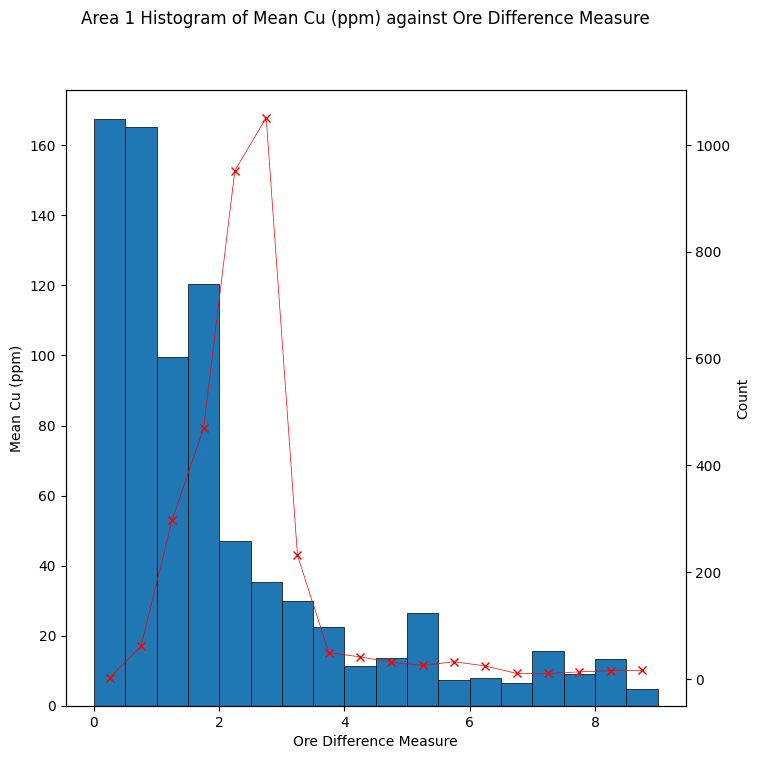

In [22]:
KEY_ELEMENT_COLUMNS: list[str] = ["Fe (%)", "Ca (%)", "Na (%)", "K (%)", "Al (%)", "Mg (%)"]
AREA_1_ORE_SAMPLE  = "EX140145"
AREA_1_ORE_VECTOR: numpy.array = numpy.array([3, 0, 0, 2, 3, 0])
NORMALIZATION_VECTOR: numpy.array = numpy.array([1, 3, 4, 6, 2, 3])
AREA_1_ORE_NORMALIZED_VECTOR: numpy.array = numpy.divide(AREA_1_ORE_VECTOR, NORMALIZATION_VECTOR)

NORMALIZED_VECTOR_COLUMN: str = "NormalizedVector"
ORE_DIFFERENCE_COLUMN: str = "OreDifference"


area_1_data_frame[NORMALIZED_VECTOR_COLUMN] = area_1_data_frame[KEY_ELEMENT_COLUMNS].apply(lambda x: numpy.divide(x.to_numpy(), NORMALIZATION_VECTOR), axis = 1)
area_1_data_frame[ORE_DIFFERENCE_COLUMN] = area_1_data_frame[NORMALIZED_VECTOR_COLUMN].apply(lambda x: numpy.linalg.norm(x - AREA_1_ORE_NORMALIZED_VECTOR))



interval_size = 0.5
bar_labels: list[str] = []
bar_x_positions = []
bar_heights = []
bar_widths = []
bar_counts = []
for interval_start in numpy.arange(0, 9, interval_size):
    interval_end = interval_start + interval_size
    subset = area_1_data_frame[area_1_data_frame[ORE_DIFFERENCE_COLUMN].ge(interval_start) & area_1_data_frame[ORE_DIFFERENCE_COLUMN].lt(interval_end)]
    bar_labels.append(f"{interval_start:1f}")
    bar_x_positions.append(interval_start + (interval_size / 2))
    bar_heights.append(subset[COPPER_COLUMN].mean())
    bar_counts.append(subset[COPPER_COLUMN].count())
    bar_widths.append(interval_size)
    print(f"{interval_start:2f} to {interval_end:2f}: {subset[COPPER_COLUMN].mean()} ({subset[COPPER_COLUMN].count()})")


figure, axes = matplotlib.pyplot.subplots(figsize = (8, 8))
figure.suptitle("Area 1 Histogram of Mean Cu (ppm) against Ore Difference Measure")
ax2 = axes.twinx()
axes.bar(bar_x_positions, bar_heights, width = bar_widths, label = bar_labels, linewidth = 0.5, edgecolor = "black")
ax2.plot(bar_x_positions, bar_counts, color = "red", linewidth = 0.5, label = "Count", marker = "x")
axes.set_xlabel("Ore Difference Measure")
axes.set_ylabel("Mean Cu (ppm)")
ax2.set_ylabel("Count")


# figure, axes = matplotlib.pyplot.subplots(figsize = (8, 8))
# figure.suptitle("Area 1 Histogram of Mean Cu (ppm) against Ore Difference Measure")

# axes.bar(bar_x_positions, bar_heights, width = bar_widths, label = bar_labels, linewidth = 0.5, edgecolor = "black")
# axes.set_xlabel("Ore Difference Measure")
# axes.set_ylabel("Mean Cu (ppm)")


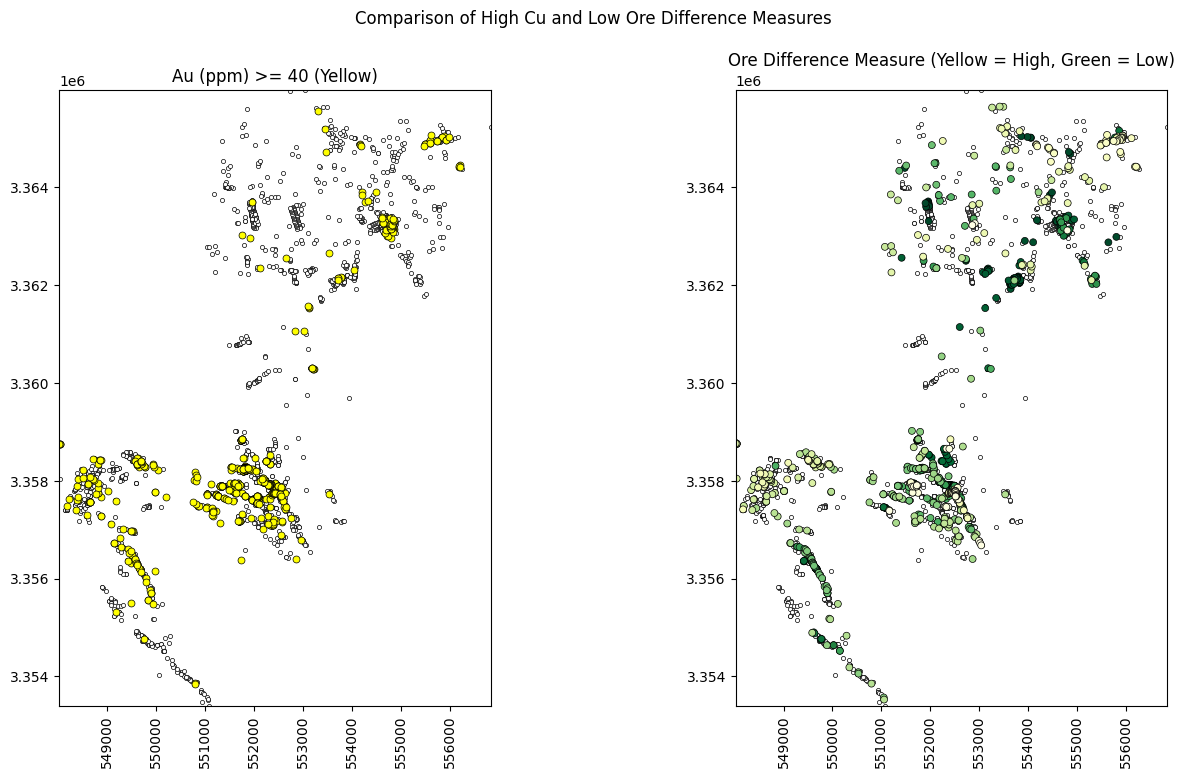

In [23]:

ORE_DIFF_THRESHOLD: float = 2
COPPER_THRESHOLD: float = 40

figure, axes = matplotlib.pyplot.subplots(nrows=1, ncols=2, figsize = (16, 8))
figure.suptitle("Comparison of High Cu and Low Ore Difference Measures")

x_min = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).min()
x_max = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).max()
y_min = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y).min()
y_max = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y).max()

for i in range(0, 2):
    axes[i].set_xlim(xmin = x_min, xmax = x_max)
    axes[i].set_ylim(ymin = y_min, ymax = y_max)

area_1_data_frame.plot(ax = axes[0], legend = True, color="white", markersize=9, linewidth=0.5, edgecolors="black")
area_1_data_frame[area_1_data_frame[COPPER_COLUMN].ge(COPPER_THRESHOLD)].plot(ax=axes[0], legend = True, color="yellow", markersize = 25, linewidth = 0.5, edgecolors = "black")
axes[0].set_title(f"Au (ppm) >= {COPPER_THRESHOLD} (Yellow)")
# axes.xticks(rotation=45)
axes[0].tick_params(axis='x', labelrotation=90)


area_1_data_frame.plot(ax = axes[1], legend = True, color="white", markersize=9, linewidth=0.5, edgecolors="black")
area_1_data_frame[area_1_data_frame[ORE_DIFFERENCE_COLUMN].le(ORE_DIFF_THRESHOLD)].plot(ax=axes[1], legend = True, cmap = "YlGn_r", markersize = 25, linewidth = 0.5, edgecolors = "black")
axes[1].set_title("Ore Difference Measure (Yellow = High, Green = Low)")
axes[1].tick_params(axis='x', labelrotation=90)


True Positives = 271 | False Positives = 559 | False Negatives = 475 | True Negatives = 2092
Accuracy = 0.6956 | Precision = 0.3265 | Recall = 0.3633 | F1 Score = 0.3439


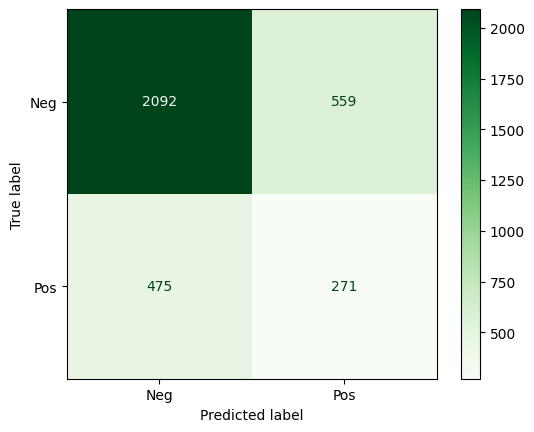

In [24]:
# threshold = 2
COPPER_THRESHOLD = 40
ORE_DIFF_THRESHOLD = 2
area_1_data_frame["Actual"] = area_1_data_frame[COPPER_COLUMN].apply(lambda x: x>=COPPER_THRESHOLD)
area_1_data_frame["Predicted"] = area_1_data_frame[ORE_DIFFERENCE_COLUMN].apply(lambda x: x<=ORE_DIFF_THRESHOLD)

tp: int = len(area_1_data_frame[area_1_data_frame["Actual"] & area_1_data_frame["Predicted"]])
fp: int = len(area_1_data_frame[~area_1_data_frame["Actual"] & area_1_data_frame["Predicted"]])
fn: int = len(area_1_data_frame[area_1_data_frame["Actual"] & ~area_1_data_frame["Predicted"]])
tn: int = len(area_1_data_frame[~area_1_data_frame["Actual"] & ~area_1_data_frame["Predicted"]])

accuracy: float = (tp + tn) / (tp + tn + fp + fn)
precision: float = tp / (tp + fp)
recall: float = tp / (tp + fn)
f1_score: float = (2 * precision * recall) / (precision + recall)

print(f"True Positives = {round(tp, 4)} | False Positives = {round(fp, 4)} | False Negatives = {round(fn, 4)} | True Negatives = {round(tn, 4)}")
print(f"Accuracy = {round(accuracy, 4)} | Precision = {round(precision, 4)} | Recall = {round(recall, 4)} | F1 Score = {round(f1_score, 4)}")

confusion_matrix = metrics.confusion_matrix(area_1_data_frame["Actual"], area_1_data_frame["Predicted"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Neg", "Pos"])
cm_display.plot(cmap='Greens')
# cm_display.plot()
matplotlib.pyplot.show()

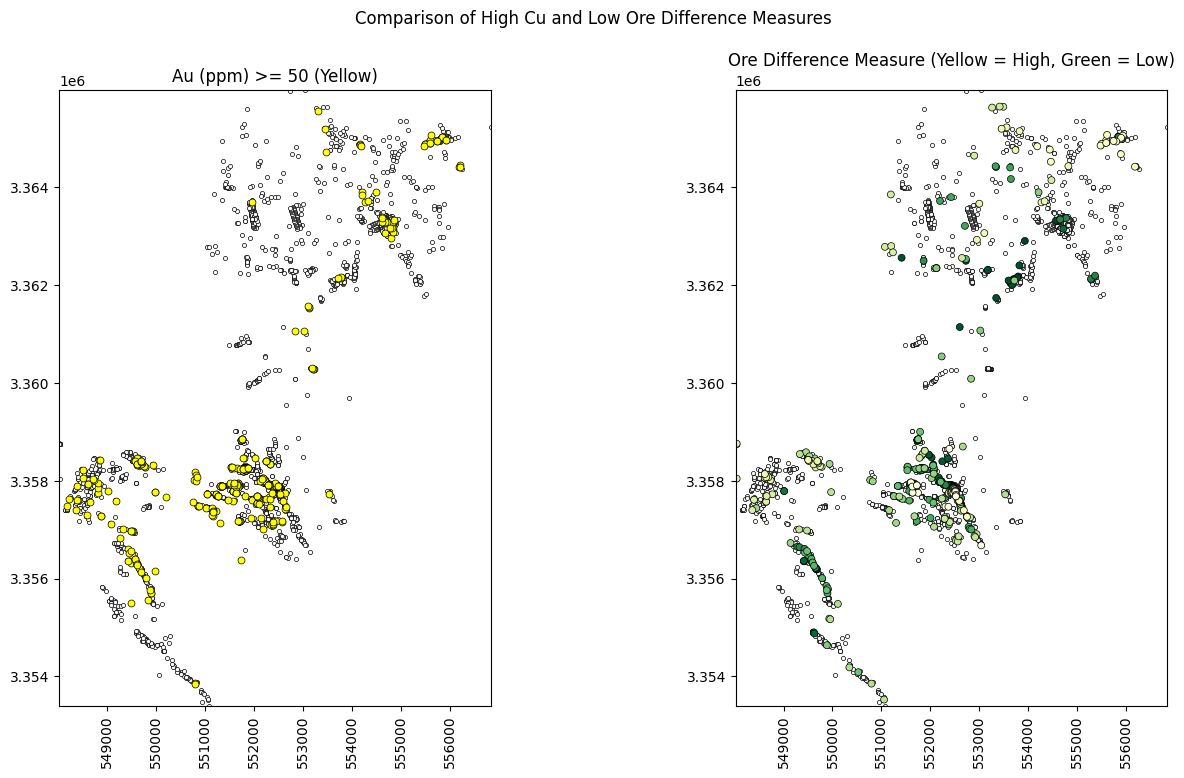

In [25]:

ORE_DIFF_THRESHOLD: float = 1.5
COPPER_THRESHOLD: float = 50

figure, axes = matplotlib.pyplot.subplots(nrows=1, ncols=2, figsize = (16, 8))
figure.suptitle("Comparison of High Cu and Low Ore Difference Measures")

x_min = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).min()
x_max = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).max()
y_min = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y).min()
y_max = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y).max()

for i in range(0, 2):
    axes[i].set_xlim(xmin = x_min, xmax = x_max)
    axes[i].set_ylim(ymin = y_min, ymax = y_max)

area_1_data_frame.plot(ax = axes[0], legend = True, color="white", markersize=9, linewidth=0.5, edgecolors="black")
area_1_data_frame[area_1_data_frame[COPPER_COLUMN].ge(COPPER_THRESHOLD)].plot(ax=axes[0], legend = True, color="yellow", markersize = 25, linewidth = 0.5, edgecolors = "black")
axes[0].set_title(f"Au (ppm) >= {COPPER_THRESHOLD} (Yellow)")
# axes.xticks(rotation=45)
axes[0].tick_params(axis='x', labelrotation=90)


area_1_data_frame.plot(ax = axes[1], legend = True, color="white", markersize=9, linewidth=0.5, edgecolors="black")
area_1_data_frame[area_1_data_frame[ORE_DIFFERENCE_COLUMN].le(ORE_DIFF_THRESHOLD)].plot(ax=axes[1], legend = True, cmap = "YlGn_r", markersize = 25, linewidth = 0.5, edgecolors = "black")
axes[1].set_title("Ore Difference Measure (Yellow = High, Green = Low)")
axes[1].tick_params(axis='x', labelrotation=90)


In [26]:
# threshold = 2
COPPER_THRESHOLD = 50
ORE_DIFF_THRESHOLD = 1.5
area_1_data_frame["Actual"] = area_1_data_frame[COPPER_COLUMN].apply(lambda x: x>=COPPER_THRESHOLD)
area_1_data_frame["Predicted"] = area_1_data_frame[ORE_DIFFERENCE_COLUMN].apply(lambda x: x<=ORE_DIFF_THRESHOLD)

tp: int = len(area_1_data_frame[area_1_data_frame["Actual"] & area_1_data_frame["Predicted"]])
fp: int = len(area_1_data_frame[~area_1_data_frame["Actual"] & area_1_data_frame["Predicted"]])
fn: int = len(area_1_data_frame[area_1_data_frame["Actual"] & ~area_1_data_frame["Predicted"]])
tn: int = len(area_1_data_frame[~area_1_data_frame["Actual"] & ~area_1_data_frame["Predicted"]])

accuracy: float = (tp + tn) / (tp + tn + fp + fn)
precision: float = tp / (tp + fp)
recall: float = tp / (tp + fn)
f1_score: float = (2 * precision * recall) / (precision + recall)

print(f"True Positives = {round(tp, 4)} | False Positives = {round(fp, 4)} | False Negatives = {round(fn, 4)} | True Negatives = {round(tn, 4)}")
print(f"Accuracy = {round(accuracy, 4)} | Precision = {round(precision, 4)} | Recall = {round(recall, 4)} | F1 Score = {round(f1_score, 4)}")

True Positives = 108 | False Positives = 253 | False Negatives = 318 | True Negatives = 2718
Accuracy = 0.8319 | Precision = 0.2992 | Recall = 0.2535 | F1 Score = 0.2745


# Embeddings Approach

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# Load dataset
data = area_1_data_frame.copy()

# Define features and target
# X = data[['(2Ca+Na+K)/Al', 'K/(Al-Na)', 'K/Al', 'As/Al', 'CCPI', 'Ishikawa', 'Na/Al', 'Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'As (ppm)', 'Cu (ppm)', 'Mg (%)']]
features = ['(2Ca+Na+K)/Al', 'K/(Al-Na)', 'K/Al', 'As/Al', 'CCPI', 'Ishikawa', 'Na/Al', 'Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'As (ppm)', 'Cu (ppm)', 'Mg (%)']
X = data[features]
y = data['Au (ppm)'] >= 2.5  # Binary target
# y = data['Au (ppm)']  # Binary target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [28]:

poly = PolynomialFeatures(degree=5, interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
# Standardize the features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

X_train_reduced = X_train_scaled.copy()
X_test_reduced = X_test_scaled.copy()

In [29]:
# Polynomial features
# poly = PolynomialFeatures(degree=3, interaction_only=True)
# X_train_poly = poly.fit_transform(X_train)
# X_test_poly = poly.transform(X_test)


X_train_poly = X_train
X_test_poly = X_test
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Dimensionality reduction (if necessary)
# pca = PCA(n_components=10)
# X_train_reduced = pca.fit_transform(X_train_resampled)
# X_test_reduced = pca.transform(X_test_scaled)

In [30]:
X_train_reduced = X_train_resampled.copy()
X_test_reduced = X_test_scaled.copy()

In [31]:
pd.DataFrame(X_train_resampled, columns=['(2Ca+Na+K)/Al', 'K/(Al-Na)', 'K/Al', 'As/Al', 'CCPI', 'Ishikawa', 'Na/Al', 'Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'As (ppm)', 'Cu (ppm)', 'Mg (%)'])

(2Ca+Na+K)/Al  K/(Al-Na)      K/Al     As/Al      CCPI  Ishikawa  \
0         -0.168944  -0.014746 -0.191276 -0.875022  0.599450  0.398174   
1         -0.139091   1.484949  0.273435  0.366353 -1.447813 -0.245254   
2         -0.165219   0.999292 -0.056770  0.055824  0.038834  0.191872   
3         -0.172452  -0.762980 -0.557897 -0.571316  0.745385  0.464500   
4         -0.171453  -0.580201 -0.462226 -0.196749  0.740614  0.408616   
...             ...        ...       ...       ...       ...       ...   
4599      -0.170393  -1.546955 -1.300105  1.605071  0.810384  0.217421   
4600      -0.061286  -1.043771 -0.784248  1.230512 -1.441574 -1.821613   
4601      -0.142920  -0.651884 -0.547536  0.720120 -0.648530 -0.449193   
4602      -0.151849  -1.669634 -1.532641  0.798121  0.517725 -0.594124   
4603      -0.166143   1.023719  0.155550  0.043749  0.732596  0.449336   

         Na/Al    Fe (%)    Ca (%)    Na (%)     K (%)    Al (%)  As (ppm)  \
0    -0.555422  1.108998 -0.216578 -0.228028  0.127651  0.950874 -0.363420   
1    -0.519311 -0.603371  0.450194 -0.244782 -0.153468 -0.508109 -0.070894   
2     0.662866  2.130277 -0.203374  0.128589  0.254155  0.911442  0.303095   
3    -0.606647 -0.588013 -0.291397 -0.247175 -0.211700  0.776716 -0.252335   
4    -0.539987 -1.010347 -0.295798 -0.254355 -0.609283 -0.938575 -0.500426   
...        ...       ...       ...       ...       ...       ...       ...   
4599 -0.403584 -0.508919 -0.285025 -0.258892 -0.748884 -1.366587 -0.208383   
4600 -0.449063 -0.374360  0.399430 -0.258055 -0.723384 -1.312612 -0.322675   
4601 -0.497778 -0.573612  0.003416 -0.255997 -0.674844 -1.154922 -0.298339   
4602 -0.092600 -0.966334 -0.271789 -0.261536 -0.758659 -1.437673 -0.586857   
4603 -0.537188 -0.041288 -0.277432 -0.242624 -0.091790 -0.250624 -0.168904   

      Cu (ppm)    Mg (%)  
0    -0.000783 -0.012630  
1    -0.086045 -0.007389  
2    -0.012963  0.100927  
3    -0.110406 -0.138417  
4    -0.108376 -0.155887  
...        ...       ...  
4599  0.189418 -0.127647  
4600 -0.071151 -0.117472  
4601  0.012686 -0.064747  
4602 -0.053185 -0.149340  
4603  0.010919 -0.120363  

[4604 rows x 15 columns]

In [32]:
pd.DataFrame(X_train_poly, columns=poly.get_feature_names_out())

1  (2Ca+Na+K)/Al  K/(Al-Na)      K/Al     As/Al      CCPI  Ishikawa  \
994  NaN      -0.186686   0.566898  0.401548  0.304423  0.894383  0.986849   
464  NaN       2.622940   0.994353  0.444007  0.433711  0.412128  0.904796   
1740 NaN       0.163873   0.855927  0.413837  0.401370  0.762324  0.960540   
1074 NaN      -0.516915   0.353630  0.368051  0.336054  0.928760  0.995307   
2855 NaN      -0.422895   0.405728  0.376792  0.375065  0.927636  0.988180   
...   ..            ...        ...       ...       ...       ...       ...   
1095 NaN      -0.385589   0.453086  0.384417  0.437499  0.909777  0.988912   
1130 NaN      -0.318046   0.494431  0.388222  0.355440  0.869456  0.980443   
1294 NaN      -0.372967   0.465155  0.387169  0.446684  0.923989  0.991361   
860  NaN      -0.139919   0.594757  0.397544  0.329216  0.785577  0.972352   
3174 NaN      -0.349201   0.357814  0.368878  0.209731  0.831250  0.976878   

         Na/Al  Fe (%)  Ca (%)  ...  Ca (%) K (%) Al (%) As (ppm) Mg (%)  \
994   0.013839    3.69    0.40  ...                                  NaN   
464   0.023594    1.46    3.43  ...                                  NaN   
1740  0.342963    5.02    0.46  ...                                  NaN   
1074  0.000000    1.48    0.06  ...                                  NaN   
2855  0.018008    0.93    0.04  ...                                  NaN   
...        ...     ...     ...  ...                                  ...   
1095  0.025129    3.41    0.13  ...                                  NaN   
1130  0.074205    3.98    0.16  ...                                  NaN   
1294  0.009056    3.19    0.14  ...                                  NaN   
860   0.154272    3.52    0.40  ...                                  NaN   
3174  0.000000    2.60    0.65  ...                                  NaN   

      Ca (%) K (%) Al (%) Cu (ppm) Mg (%)  \
994                                   NaN   
464                                   NaN   
1740                                  NaN   
1074                                  NaN   
2855                                  NaN   
...                                   ...   
1095                                  NaN   
1130                                  NaN   
1294                                  NaN   
860                                   NaN   
3174                                  NaN   

      Ca (%) K (%) As (ppm) Cu (ppm) Mg (%)  \
994                                     NaN   
464                                     NaN   
1740                                    NaN   
1074                                    NaN   
2855                                    NaN   
...                                     ...   
1095                                    NaN   
1130                                    NaN   
1294                                    NaN   
860                                     NaN   
3174                                    NaN   

      Ca (%) Al (%) As (ppm) Cu (ppm) Mg (%)  \
994                                      NaN   
464                                      NaN   
1740                                     NaN   
1074                                     NaN   
2855                                     NaN   
...                                      ...   
1095                                     NaN   
1130                                     NaN   
1294                                     NaN   
860                                      NaN   
3174                                     NaN   

      Na (%) K (%) Al (%) As (ppm) Cu (ppm)  \
994                                     NaN   
464                                     NaN   
1740                                    NaN   
1074                                    NaN   
2855                                    NaN   
...                                     ...   
1095                                    NaN   
1130                                    NaN   
1294                                    NaN   
860 

In [33]:
poly.get_feature_names_out()

array(['1', '(2Ca+Na+K)/Al', 'K/(Al-Na)', ...,
       'Na (%) K (%) As (ppm) Cu (ppm) Mg (%)',
       'Na (%) Al (%) As (ppm) Cu (ppm) Mg (%)',
       'K (%) Al (%) As (ppm) Cu (ppm) Mg (%)'], dtype=object)

In [34]:
from xgboost import XGBRegressor

In [35]:
# from sklearn.model_selection import KFold, cross_val_score
# from xgboost import XGBRegressor

# # Define the model
# xgb_model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)

# # Use KFold for regression
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Perform cross-validation
# scores = cross_val_score(xgb_model, X_train_reduced, y_train, cv=kf, scoring='r2')

# print("Cross-validation R^2 scores:", scores)
# print("Mean R^2 score:", scores.mean())

# # Train model on entire training set
# xgb_model.fit(X_train_reduced, y_train)
# # Predict on test set
# y_pred = xgb_model.predict(X_test_reduced)

In [36]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import shap

# Initialize model
xgb_model = XGBClassifier(scale_pos_weight=len(y_train_resampled) / sum(y_train_resampled), random_state=42)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_model, X_train_reduced, y_train_resampled, cv=cv, scoring='f1_weighted')

print(f'Cross-validated F1 scores: {scores}')
print(f'Mean F1 score: {np.mean(scores)}')

# Train model on entire training set
xgb_model.fit(X_train_reduced, y_train_resampled)

# Predict on test set
y_pred = xgb_model.predict(X_test_reduced)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# w_f1 = weighted_f1_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
# print(f'Weighted F1 Score: {w_f1:.4f}')

Cross-validated F1 scores: [0.97175143 0.97284464 0.97609866 0.96304308 0.96627945]
Mean F1 score: 0.9700034541609577
Accuracy: 0.9294
Precision: 0.2419
Recall: 0.3750
F1 Score: 0.2941


In [37]:
X_test['prediction'] = y_pred
X_test['actual'] = np.where(y_test == True, 1, 0)

In [38]:
X_test

(2Ca+Na+K)/Al  K/(Al-Na)      K/Al     As/Al      CCPI  Ishikawa  \
291       -0.467678   0.253221  0.338487  0.311942  0.870130  0.944125   
2736      34.038028   0.000000  0.685158  0.511567  0.386795  0.936443   
2334       1.245967   0.355434  0.358882  0.465006  0.838107  0.876612   
432       -0.118174   0.726078  0.418431  0.368008  0.878303  0.992479   
479        0.088388   0.913655  0.437627  0.404402  0.915258  0.996105   
...             ...        ...       ...       ...       ...       ...   
2259       1.263186   0.342441  0.365704  0.460800  0.495249  0.828226   
3317       0.100077   0.652686  0.377318  0.238369  0.582692  0.920775   
2115      30.058310   0.459613  0.369242  0.610079  0.510707  0.772077   
2553       5.804785   0.519144  0.393196  0.328823  0.230526  0.769607   
2865       0.017534   0.821456  0.425873  0.372316  0.858946  0.985756   

         Na/Al  Fe (%)  Ca (%)  Na (%)  K (%)  Al (%)  As (ppm)  Cu (ppm)  \
291   0.122162    0.53    0.03    0.05   0.16    0.58       7.0      2.00   
2736  1.000000    1.00    0.40    5.00   8.00    0.44      59.0      0.91   
2334  0.173540    0.76    0.13    0.02   0.06    0.17      13.0      4.00   
432   0.048514    1.95    0.04    0.26   4.58    6.32     150.0     17.00   
479   0.019686    1.39    0.05    0.09   3.50    3.83     141.0     51.00   
...        ...     ...     ...     ...    ...     ...       ...       ...   
2259  0.000000    3.80    3.68    0.05   1.74    4.54     330.0    672.00   
3317  0.563901    3.46    0.71    2.87   3.55    8.05      40.0     38.00   
2115  0.308119    0.60    0.68    0.01   0.02    0.05      22.0      7.00   
2553  0.048443    2.28   10.05    0.15   1.95    3.65      54.0     44.50   
2865  0.086339    0.73    0.03    0.09   1.11    1.40      35.0      8.00   

      Mg (%)  prediction  actual  
291     0.02           0       0  
2736    2.00           0       0  
2334    0.05           0       0  
432     0.21           0       0  
479     0.12           1       1  
...      ...         ...     ...  
2259    0.13           0       0  
3317    1.39           0       0  
2115    0.14           0       0  
2553    0.82           1       0  
2865    0.02           0       0  

[1020 rows x 17 columns]

In [39]:
np.where(y_test == True, 1, 0)

array([0, 0, 0, ..., 0, 0, 0])

Confusion Matrix:
[[933  47]
 [ 25  15]]


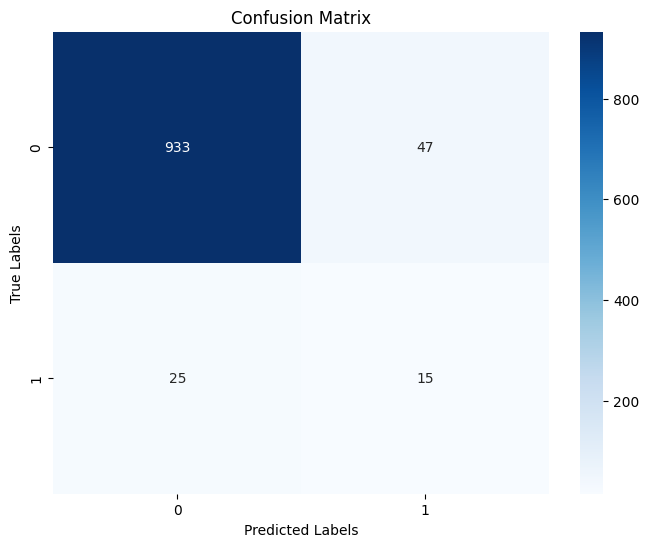

In [40]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

# Optional: Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

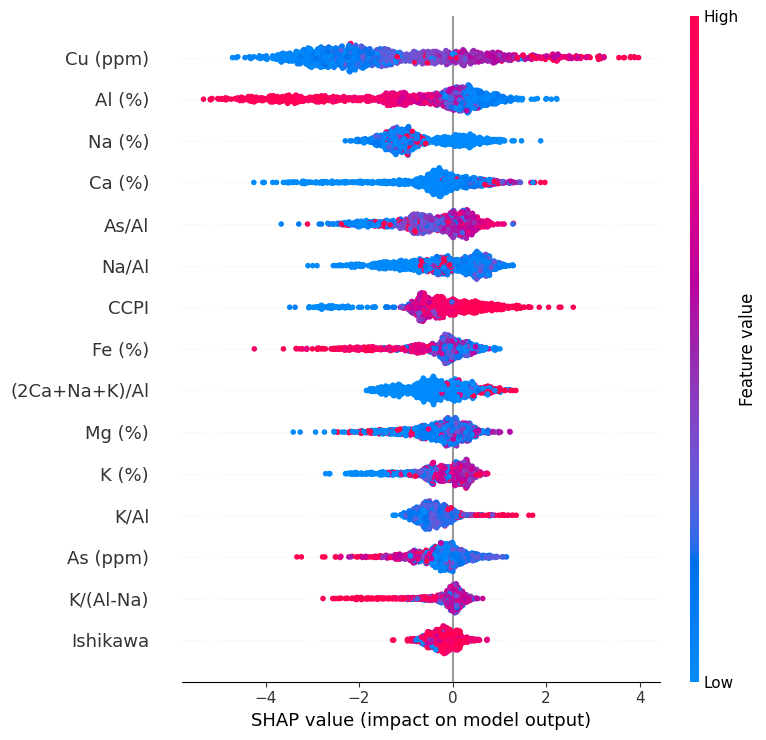

In [41]:
# Initialize SHAP explainer
explainer = shap.Explainer(xgb_model, X_train_reduced)

# Calculate SHAP values
shap_values = explainer(X_test_reduced, check_additivity=False)

# Plot SHAP summary plot
shap.summary_plot(shap_values, features=X_test_reduced, feature_names=features, max_display=30)

# Plot SHAP dependence plot for a specific feature
# shap.dependence_plot("K/(Al-Na)", shap_values.values, X_test_reduced, feature_names=poly.get_feature_names_out())
# shap.dependence_plot("Ishikawa", shap_values.values, X_test_reduced, feature_names=poly.get_feature_names_out())

# Plot SHAP values for a single prediction


shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[10], X_test_reduced[10], feature_names=features)


# Cu ppm, Al%, CCPI, FE%, K/(Al-Na), As/Al, K%

In [42]:
shap.force_plot(explainer.expected_value, shap_values.values[:500, :], X_test_reduced[0:500, :], feature_names=features)


In [43]:
shap_values.values[:500, :]


array([[-1.06336914e+00,  1.96703282e-01, -7.87994335e-01, ...,
        -5.37812774e-01, -3.19313965e+00, -9.96958840e-01],
       [ 3.56437410e-03,  1.08947659e-01, -2.41748416e-01, ...,
        -2.89636356e-02, -1.60582647e+00, -1.06693085e+00],
       [ 2.92128750e-01,  1.18932848e-01, -6.20205976e-01, ...,
        -5.48480067e-01, -3.68170712e+00, -1.34832021e+00],
       ...,
       [ 9.25518724e-01, -4.15348435e-02,  5.25747190e-01, ...,
        -2.70380688e-01, -4.19014012e-01, -4.61071522e-02],
       [-4.18130529e-01,  1.44960630e-01, -2.81972730e-01, ...,
         1.05405230e-02,  1.25229334e+00, -8.93778137e-01],
       [-8.75866840e-02,  3.88013786e-01, -2.66151350e-01, ...,
        -5.85674368e-01, -2.84095487e+00, -6.36628466e-01]])

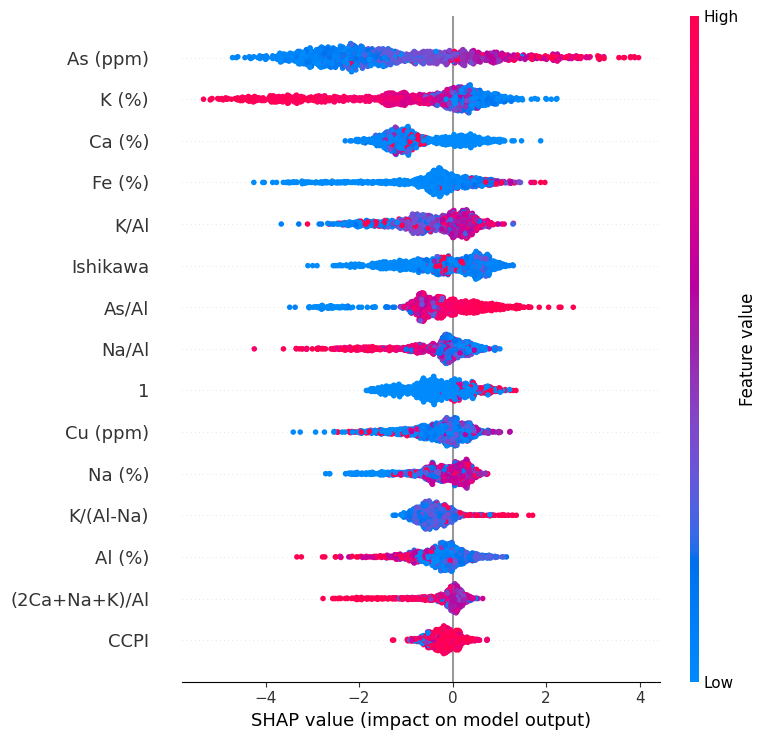

IndexError: index 15 is out of bounds for axis 0 with size 15

In [44]:
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(xgb_model, X_train_reduced)

# Calculate SHAP values
shap_values = explainer(X_test_reduced, check_additivity=False)

# Plot SHAP summary plot
shap.summary_plot(shap_values, features=X_test_reduced, feature_names=poly.get_feature_names_out())

# Plot SHAP dependence plot for a specific feature
# shap.dependence_plot("K/(Al-Na)", shap_values.values, X_test_reduced, feature_names=poly.get_feature_names_out())
# shap.dependence_plot("Ishikawa", shap_values.values, X_test_reduced, feature_names=poly.get_feature_names_out())

# Plot SHAP values for a single prediction


shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[10], X_test_reduced[10], feature_names=poly.get_feature_names_out())


In [ ]:
shap.summary_plot(shap_values, features=X_test_reduced, feature_names=poly.get_feature_names_out(), max_display=20)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

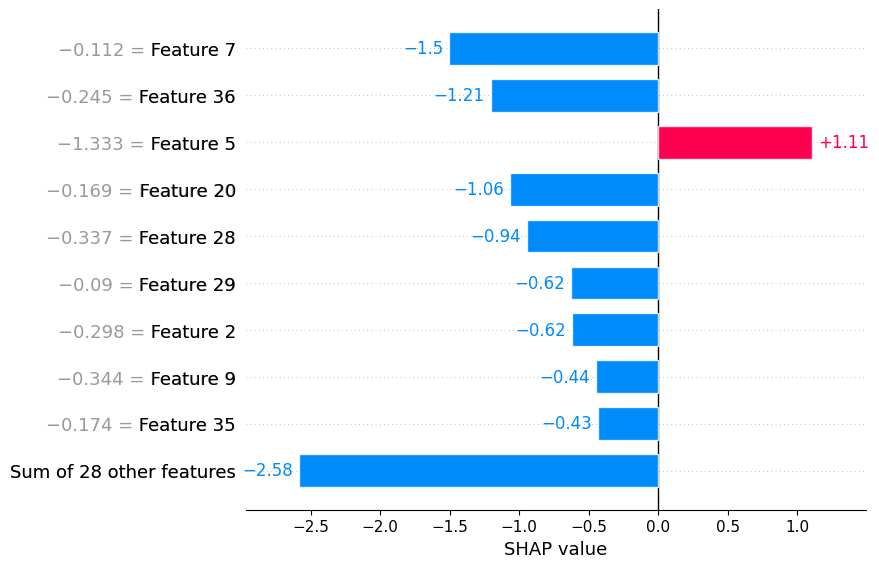

array(['1', 'Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'As (ppm)',
       'Cu (ppm)', 'Mg (%)', 'Fe (%) Ca (%)', 'Fe (%) Na (%)',
       'Fe (%) K (%)', 'Fe (%) Al (%)', 'Fe (%) As (ppm)',
       'Fe (%) Cu (ppm)', 'Fe (%) Mg (%)', 'Ca (%) Na (%)',
       'Ca (%) K (%)', 'Ca (%) Al (%)', 'Ca (%) As (ppm)',
       'Ca (%) Cu (ppm)', 'Ca (%) Mg (%)', 'Na (%) K (%)',
       'Na (%) Al (%)', 'Na (%) As (ppm)', 'Na (%) Cu (ppm)',
       'Na (%) Mg (%)', 'K (%) Al (%)', 'K (%) As (ppm)',
       'K (%) Cu (ppm)', 'K (%) Mg (%)', 'Al (%) As (ppm)',
       'Al (%) Cu (ppm)', 'Al (%) Mg (%)', 'As (ppm) Cu (ppm)',
       'As (ppm) Mg (%)', 'Cu (ppm) Mg (%)'], dtype=object)

In [ ]:
shap.plots.bar(shap_values[0])
poly.get_feature_names_out()

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize LIME explainer
explainer = LimeTabularExplainer(X_train_reduced, feature_names=poly.get_feature_names_out(), class_names=['Not Gold', 'Gold'], discretize_continuous=True)

# Select an instance to explain
i = 0  # Index of the instance you want to explain
exp = explainer.explain_instance(X_test_reduced[i], xgb_model.predict_proba, num_features=10)

# Show explanation
exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
from langchain.embeddings import OpenAIEmbeddings
[4, 3, 1, 2, 7.5, 1]

import os


In [ ]:
embeddings = OpenAIEmbeddings()
AREA_2_ORE_EMBEDDINGS: numpy.array = embeddings.embed_documents(["3.34, 3.54, 0.89, 1.95, 6.67, 0.78"])
NORMALIZATION_EMBEDDINGS: numpy.array = embeddings.embed_documents(["1.76, 10.3, 0.55, 0.64, 2.16, 0.56"])
AREA_2_ORE_NORMALIZED_EMBEDDINGS: numpy.array = numpy.divide(AREA_2_ORE_EMBEDDINGS, NORMALIZATION_EMBEDDINGS)

NORMALIZED_VECTOR_COLUMN: str = "NormalizedVector"
ORE_DIFFERENCE_COLUMN: str = "OreDifference"

def generate_embeddings(row):
    # Convert the values of the specified columns to a comma-separated string
    values_str = ", ".join(map(str, row[KEY_ELEMENT_COLUMNS].values))
    # Generate embeddings for the string
    embedding = embeddings.embed_documents([values_str])
    return embedding[0]  # Return the first (and only) embedding


area_2_data_frame['embeddings'] = area_2_data_frame.apply(generate_embeddings, axis=1)

def cosine_similarity(vec1, vec2):

    dot_product = numpy.dot(vec1, vec2)
    norm_vec1 = numpy.linalg.norm(vec1)
    norm_vec2 = numpy.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

area_2_data_frame[NORMALIZED_VECTOR_COLUMN] = area_2_data_frame['embeddings'].apply(lambda x: numpy.divide(numpy.array(x), numpy.array(NORMALIZATION_EMBEDDINGS[0])))
area_2_data_frame[ORE_DIFFERENCE_COLUMN] = area_2_data_frame[NORMALIZED_VECTOR_COLUMN].apply(lambda x: numpy.linalg.norm(x - AREA_2_ORE_NORMALIZED_EMBEDDINGS[0]))

# area_2_data_frame[ORE_DIFFERENCE_COLUMN] = area_2_data_frame[NORMALIZED_VECTOR_COLUMN].apply(lambda x: cosine_similarity(x, AREA_2_ORE_NORMALIZED_EMBEDDINGS[0]))

interval_size = 500
bar_labels: list[str] = []
bar_x_positions = []
bar_heights = []
bar_widths = []
for interval_start in numpy.arange(0, 8000, interval_size):
    interval_end = interval_start + interval_size
    subset = area_2_data_frame[area_2_data_frame[ORE_DIFFERENCE_COLUMN].ge(interval_start) & area_2_data_frame[ORE_DIFFERENCE_COLUMN].lt(interval_end)]
    bar_labels.append(f"{interval_start:1f}")
    bar_x_positions.append(interval_start + (interval_size / 2))
    bar_heights.append(subset[COPPER_COLUMN].mean())
    bar_widths.append(interval_size)
    print(f"{interval_start:2f} to {interval_end:2f}: {subset[COPPER_COLUMN].mean()} ({subset[COPPER_COLUMN].count()})")

figure, axes = matplotlib.pyplot.subplots(figsize = (8, 8))
figure.suptitle("Area 2 Histogram of Mean Cu (ppm) against Ore Difference Measure")

axes.bar(bar_x_positions, bar_heights, width = bar_widths, label = bar_labels, linewidth = 0.5, edgecolor = "black")
axes.set_xlabel("Ore Difference Measure")
axes.set_ylabel("Mean Cu (ppm)")

# Area 2 Copper

In [ ]:
from IPython.display import display, HTML
area_2_data_frame = area_2_data_frame[area_2_data_frame[COPPER_COLUMN] < 70]
display(HTML(area_2_data_frame[KEY_ELEMENT_COLUMNS+['Cu (ppm)']].describe().round(2).T.to_html()))
print("Lower End")
display(HTML(area_2_data_frame[area_2_data_frame['Cu (ppm)'] < 10][KEY_ELEMENT_COLUMNS+['Cu (ppm)']].describe().round(2).T.to_html()))
print("Upper End")
display(HTML(area_2_data_frame[area_2_data_frame['Cu (ppm)'] > 50][KEY_ELEMENT_COLUMNS+['Cu (ppm)']].describe().round(2).T.to_html()))

Lower End


Upper End


0.000000 to 1.000000: 30.90666666666667 (15)
1.000000 to 2.000000: 31.319174041297938 (339)
2.000000 to 3.000000: 31.672946859903387 (414)
3.000000 to 4.000000: 27.27872340425532 (235)
4.000000 to 5.000000: 19.72761194029851 (134)
5.000000 to 6.000000: 14.948648648648648 (111)
6.000000 to 7.000000: 13.42741935483871 (124)
7.000000 to 8.000000: 11.718905472636816 (201)
8.000000 to 9.000000: 11.35945945945946 (37)
9.000000 to 10.000000: 17.714285714285715 (14)
10.000000 to 11.000000: 22.377777777777776 (9)
11.000000 to 12.000000: 16.925 (4)
12.000000 to 13.000000: 16.72857142857143 (7)
13.000000 to 14.000000: 9.7 (4)
14.000000 to 15.000000: 13.9 (2)
15.000000 to 16.000000: 3.9 (2)
16.000000 to 17.000000: 16.35 (2)
17.000000 to 18.000000: nan (0)
18.000000 to 19.000000: 7.7 (1)
19.000000 to 20.000000: 16.3 (1)
20.000000 to 21.000000: 4.8 (1)
21.000000 to 22.000000: nan (0)
22.000000 to 23.000000: 8.5 (1)
23.000000 to 24.000000: nan (0)
24.000000 to 25.000000: nan (0)
25.000000 to 26.00000

Text(0, 0.5, 'Count')

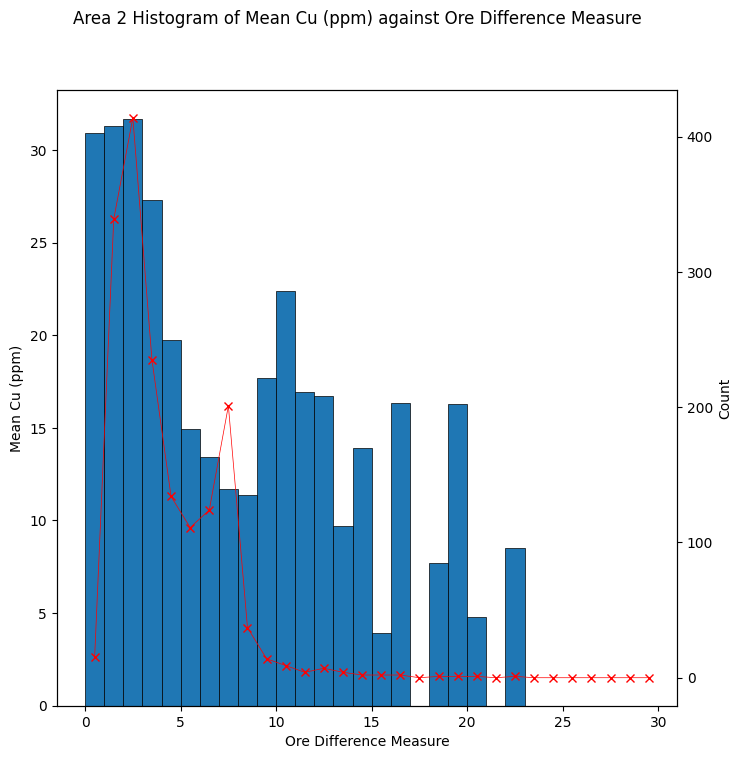

In [ ]:
KEY_ELEMENT_COLUMNS: list[str] = ["Fe (%)", "Ca (%)", "Na (%)", "K (%)", "Al (%)", "Mg (%)"]

# AREA_2_ORE_VECTOR: numpy.array = numpy.array([3.5, 3, 1, 2, 5, 1])
AREA_2_ORE_VECTOR: numpy.array = numpy.array([4, 3, 1, 2, 7.5, 1])
# AREA_2_ORE_VECTOR: numpy.array = numpy.array([3, 6, 1, 1, 5, 1])
NORMALIZATION_VECTOR: numpy.array = numpy.array([2, 15, .3, .4, 1.5, .4])

# AREA_2_ORE_VECTOR: numpy.array = numpy.array([3.34, 3.54, 0.89, 1.95, 6.67, 0.78])
# NORMALIZATION_VECTOR: numpy.array = numpy.array([1.76, 10.3, 0.55, 0.64, 2.16, 0.56])
AREA_2_ORE_NORMALIZED_VECTOR: numpy.array = numpy.divide(AREA_2_ORE_VECTOR, NORMALIZATION_VECTOR)

NORMALIZED_VECTOR_COLUMN: str = "NormalizedVector"
ORE_DIFFERENCE_COLUMN: str = "OreDifference"

area_2_data_frame[NORMALIZED_VECTOR_COLUMN] = area_2_data_frame[KEY_ELEMENT_COLUMNS].apply(lambda x: numpy.divide(x.to_numpy(), NORMALIZATION_VECTOR), axis = 1)
area_2_data_frame[ORE_DIFFERENCE_COLUMN] = area_2_data_frame[NORMALIZED_VECTOR_COLUMN].apply(lambda x: numpy.linalg.norm(x - AREA_2_ORE_NORMALIZED_VECTOR))

interval_size = 1
bar_labels: list[str] = []
bar_x_positions = []
bar_heights = []
bar_widths = []
bar_counts = []
for interval_start in numpy.arange(0, 30, interval_size):
    interval_end = interval_start + interval_size
    subset = area_2_data_frame[area_2_data_frame[ORE_DIFFERENCE_COLUMN].ge(interval_start) & area_2_data_frame[ORE_DIFFERENCE_COLUMN].lt(interval_end)]
    bar_labels.append(f"{interval_start:1f}")
    bar_x_positions.append(interval_start + (interval_size / 2))
    bar_heights.append(subset[COPPER_COLUMN].mean())
    bar_counts.append(subset[GOLD_COLUMN].count())
    bar_widths.append(interval_size)
    print(f"{interval_start:2f} to {interval_end:2f}: {subset[COPPER_COLUMN].mean()} ({subset[COPPER_COLUMN].count()})")

figure, axes = matplotlib.pyplot.subplots(figsize = (8, 8))
figure.suptitle("Area 2 Histogram of Mean Cu (ppm) against Ore Difference Measure")
ax2 = axes.twinx()
axes.bar(bar_x_positions, bar_heights, width = bar_widths, label = bar_labels, linewidth = 0.5, edgecolor = "black")
ax2.plot(bar_x_positions, bar_counts, color = "red", linewidth = 0.5, label = "Count", marker = "x")
axes.set_xlabel("Ore Difference Measure")
axes.set_ylabel("Mean Cu (ppm)")
ax2.set_ylabel("Count")

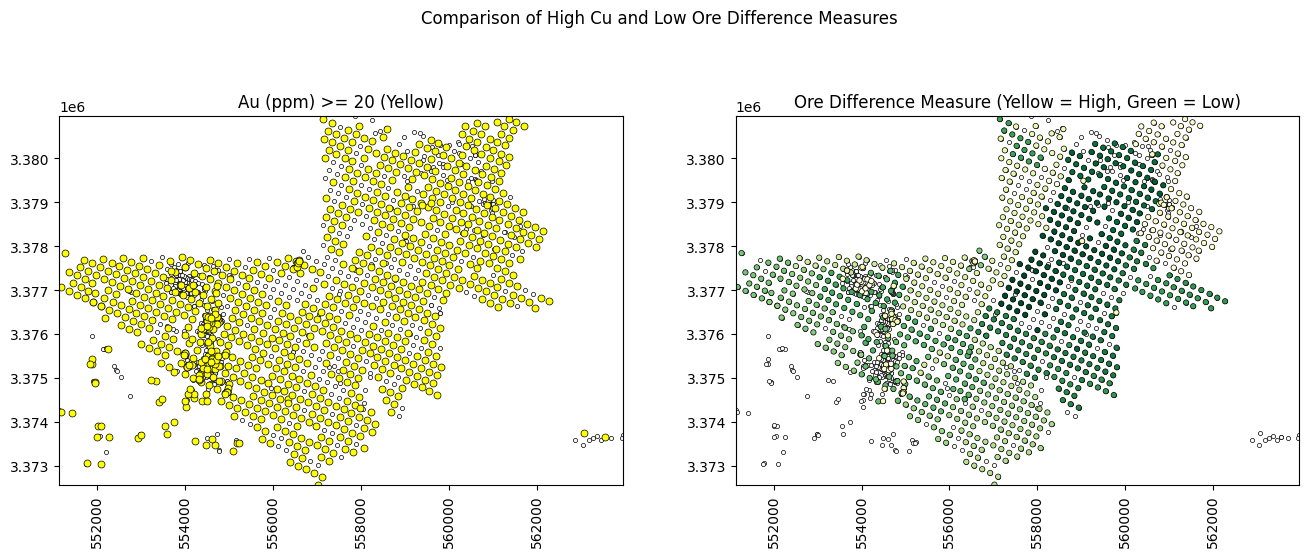

In [ ]:

ORE_DIFF_THRESHOLD: float = 4
COPPER_THRESHOLD: float = 20

figure, axes = matplotlib.pyplot.subplots(nrows=1, ncols=2, figsize = (16, 6))
figure.suptitle("Comparison of High Cu and Low Ore Difference Measures")

x_min = area_2_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).min()
x_max = area_2_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).max()
y_min = area_2_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y).min()
y_max = area_2_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y).max()

for i in range(0, 2):
    axes[i].set_xlim(xmin = x_min, xmax = x_max)
    axes[i].set_ylim(ymin = y_min, ymax = y_max)

area_2_data_frame.plot(ax = axes[0], legend = True, color="white", markersize=9, linewidth=0.5, edgecolors="black")
area_2_data_frame[area_2_data_frame[COPPER_COLUMN].ge(COPPER_THRESHOLD)].plot(ax=axes[0], legend = True, color="yellow", markersize = 25, linewidth = 0.5, edgecolors = "black")
axes[0].set_title(f"Au (ppm) >= {COPPER_THRESHOLD} (Yellow)")
# axes.xticks(rotation=45)
axes[0].tick_params(axis='x', labelrotation=90)


area_2_data_frame.plot(ax = axes[1], legend = True, color="white", markersize=9, linewidth=0.5, edgecolors="black")
area_2_data_frame[area_2_data_frame[ORE_DIFFERENCE_COLUMN].le(ORE_DIFF_THRESHOLD)].plot(ax=axes[1], legend = True, cmap = "YlGn_r", markersize = 15, linewidth = 0.5, edgecolors = "black")
axes[1].set_title("Ore Difference Measure (Yellow = High, Green = Low)")
axes[1].tick_params(axis='x', labelrotation=90)


True Positives = 807 | False Positives = 196 | False Negatives = 162 | True Negatives = 493
Accuracy = 0.7841 | Precision = 0.8046 | Recall = 0.8328 | F1 Score = 0.8185


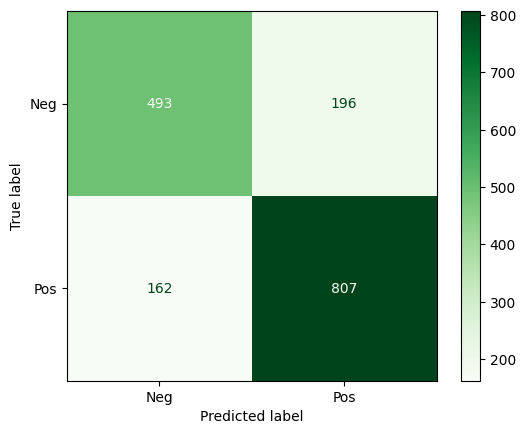

In [ ]:
# threshold = 2
# COPPER_THRESHOLD = 50
# ORE_DIFF_THRESHOLD = 5
area_2_data_frame["Actual"] = area_2_data_frame[COPPER_COLUMN].apply(lambda x: x>=COPPER_THRESHOLD)
area_2_data_frame["Predicted"] = area_2_data_frame[ORE_DIFFERENCE_COLUMN].apply(lambda x: x<=ORE_DIFF_THRESHOLD)

tp: int = len(area_2_data_frame[area_2_data_frame["Actual"] & area_2_data_frame["Predicted"]])
fp: int = len(area_2_data_frame[~area_2_data_frame["Actual"] & area_2_data_frame["Predicted"]])
fn: int = len(area_2_data_frame[area_2_data_frame["Actual"] & ~area_2_data_frame["Predicted"]])
tn: int = len(area_2_data_frame[~area_2_data_frame["Actual"] & ~area_2_data_frame["Predicted"]])

accuracy: float = (tp + tn) / (tp + tn + fp + fn)
precision: float = tp / (tp + fp)
recall: float = tp / (tp + fn)
f1_score: float = (2 * precision * recall) / (precision + recall)

print(f"True Positives = {round(tp, 4)} | False Positives = {round(fp, 4)} | False Negatives = {round(fn, 4)} | True Negatives = {round(tn, 4)}")
print(f"Accuracy = {round(accuracy, 4)} | Precision = {round(precision, 4)} | Recall = {round(recall, 4)} | F1 Score = {round(f1_score, 4)}")

confusion_matrix = metrics.confusion_matrix(area_2_data_frame["Actual"], area_2_data_frame["Predicted"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Neg", "Pos"])
cm_display.plot(cmap='Greens')
# cm_display.plot()
matplotlib.pyplot.show()

In [ ]:
# def plot(data_frame, columns):
#     for index, row in data_frame[data_frame[TARGET_COLUMN].ge(0.5)].iterrows():
#         DISTANCE_COLUMN: str = "Distance"
#         NUMBER_OF_COLUMNS: int = 2
#         NUMBER_OF_ROWS: int = int(math.ceil(len(columns) / NUMBER_OF_COLUMNS))

#         subset_data_frame: geopandas.GeoDataFrame = area_2_data_frame.copy()
#         subset_data_frame[DISTANCE_COLUMN] = area_2_data_frame[GEOMETRY_COLUMN].apply(lambda other: distance(row[GEOMETRY_COLUMN], other))
#         subset_data_frame = subset_data_frame[subset_data_frame[DISTANCE_COLUMN].le(20)]

#         if len(subset_data_frame) > 3:
#             figure: matplotlib.figure.Figure
#             axes: numpy.ndarray[matplotlib.axes.Axes]
#             figure, axes = matplotlib.pyplot.subplots(nrows = NUMBER_OF_ROWS, ncols = NUMBER_OF_COLUMNS, figsize = (8, 8))

#             for index, column in enumerate(columns):
#                 y_min: Optional[float] = None
#                 y_max: Optional[float] = None

#                 if column in COLUMN_LIMITS:
#                     y_min = COLUMN_LIMITS[column][0]
#                     y_max = COLUMN_LIMITS[column][1]

#                 row_index: int = int(math.floor(index / NUMBER_OF_COLUMNS))
#                 column_index: int = index % NUMBER_OF_COLUMNS
#                 axes[row_index, column_index].scatter(subset_data_frame[DISTANCE_COLUMN], subset_data_frame[column])

#                 axes[row_index, column_index].set_ylabel(column)
#                 axes[row_index, column_index].set_ylim(y_min, y_max)
#                 axes[row_index, column_index].set_xlim(0, RADIUS)

#             figure.supxlabel("Distance (m)")

# plot(area_2_data_frame, RATIO_COLUMNS)



# Refinement

In [ ]:
# domain_1_subset_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[GEOMETRY_COLUMN].apply(lambda x: distance_to_line_segment(x, DOMAIN_1_SUBSET_LINE[0], DOMAIN_1_SUBSET_LINE[1])).le(200)][data_frame[TARGET_COLUMN].ge(THRESHOLD)]

# X: numpy.array[list[float]] = numpy.array(domain_1_subset_data_frame[GEOMETRY_COLUMN].apply(lambda x: [x.x]).to_list())
# y: numpy.array[float] = numpy.array(domain_1_subset_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y).tolist())

# linear_regression: LinearRegression = LinearRegression().fit(X, y)

# domain_1_subset_line_point_1_x: float = domain_1_subset_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).min() - RADIUS
# domain_1_subset_line_point_1_y: float = linear_regression.predict([[domain_1_subset_line_point_1_x]])[0]
# domain_1_subset_line_point_2_x: float = domain_1_subset_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).max() + RADIUS
# domain_1_subset_line_point_2_y: float = linear_regression.predict([[domain_1_subset_line_point_2_x]])[0]
# domain_1_subset_line = Point(domain_1_subset_line_point_1_x, domain_1_subset_line_point_1_y), Point(domain_1_subset_line_point_2_x, domain_1_subset_line_point_2_y)

# print(f"Adjusting manual subset line from ({DOMAIN_1_SUBSET_LINE[0].x}, {DOMAIN_1_SUBSET_LINE[0].y}), ({DOMAIN_1_SUBSET_LINE[1].x}, {DOMAIN_1_SUBSET_LINE[1].y}) -> ({domain_1_subset_line[0].x}, {domain_1_subset_line[0].y}), ({domain_1_subset_line[1].x}, {domain_1_subset_line[1].y})")

# Difference Measure

### Removing Background

In [11]:
# REMOVING BACKGROUND
def pearson_correlation(x, normalization_vector):
    return np.corrcoef(x, normalization_vector)[0, 1]


KEY_ELEMENT_COLUMNS = ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)', 'K/Al', 'CCPI', 'Ishikawa']
AREA_1_ORE_VECTOR: numpy.array = numpy.array([1, 0, 0, 0, 0.5, 45, 0, 0.5, 1, 1])
AREA_1_ANDESITE_VECTOR: numpy.array = numpy.array([5, 4.5, 3, 2.5, 8.5, 30, 1.5, 0.3, 0.5, 0.9])
AREA_1_RHYOLITE_VECTOR: numpy.array = numpy.array([5, 5, 3, 2, 7.5, 5, 3, 0.3, 0.5, 0.8])

# AREA_1_ORE_VECTOR: numpy.array = numpy.array([1, 0, 0, 0, 0.5, 45, 0])
# AREA_1_ANDESITE_VECTOR: numpy.array = numpy.array([5, 4.5, 3, 2.5, 8.5, 30, 1])
# AREA_1_RHYOLITE_VECTOR: numpy.array = numpy.array([5, 5, 3, 2, 7.5, 5, 5])

# NORMALIZING
# NORMALIZATION_VECTOR: numpy.array = numpy.array([5, 5, 5, 5, 10, 50, 5])
# NORMALIZATION_VECTOR: numpy.array = numpy.array([ 4,  4,  4,  4,  8, 40,  4])
NORMALIZATION_VECTOR: numpy.array = numpy.array([5, 5, 3, 2.5, 8.5, 30, 1.5, 0.3, 0.5, 0.8])
AREA_1_ORE_NORMALIZED_VECTOR: numpy.array = numpy.divide(AREA_1_ORE_VECTOR, NORMALIZATION_VECTOR)
AREA_1_ANDESITE_NORMALIZED_VECTOR: numpy.array = numpy.divide(AREA_1_ANDESITE_VECTOR, NORMALIZATION_VECTOR)
AREA_1_RHYOLITE_NORMALIZED_VECTOR: numpy.array = numpy.divide(AREA_1_RHYOLITE_VECTOR, NORMALIZATION_VECTOR)


NORMALIZED_VECTOR_COLUMN: str = "NormalizedVector"
ORE_DIFFERENCE_COLUMN: str = "OreDifference"
BG_DIFFERENCE_COLUMN: str = "BgDifference"

area_1_data_frame[NORMALIZED_VECTOR_COLUMN] = area_1_data_frame[KEY_ELEMENT_COLUMNS].apply(lambda x: numpy.divide(x.to_numpy(), NORMALIZATION_VECTOR), axis = 1)
area_1_data_frame[ORE_DIFFERENCE_COLUMN] = area_1_data_frame[NORMALIZED_VECTOR_COLUMN].apply(lambda x: numpy.linalg.norm(x - AREA_1_ORE_NORMALIZED_VECTOR))
area_1_data_frame[BG_DIFFERENCE_COLUMN] = area_1_data_frame[NORMALIZED_VECTOR_COLUMN].apply(lambda x: numpy.linalg.norm(x - NORMALIZATION_VECTOR))


NameError: name 'area_1_data_frame' is not defined

In [19]:
KEY_ELEMENT_COLUMNS = ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)', 'K/Al', 'CCPI', 'Ishikawa']
AREA_1_ORE_VECTOR: numpy.array = numpy.array([1, 0, 0, 0, 0.5, 45, 0, 0.5, 1, 1])
AREA_1_ANDESITE_VECTOR: numpy.array = numpy.array([5, 4.5, 3, 2.5, 8.5, 30, 1.5, 0.3, 0.5, 0.9])
AREA_1_RHYOLITE_VECTOR: numpy.array = numpy.array([5, 5, 3, 2, 7.5, 5, 3, 0.3, 0.5, 0.8])
NORMALIZATION_VECTOR: numpy.array = numpy.array([5, 5, 3, 2.5, 8.5, 30, 1.5, 0.3, 0.5, 0.8])

In [20]:
AREA_1_ORE_NORMALIZED_VECTOR: numpy.array = numpy.divide(AREA_1_ORE_VECTOR, NORMALIZATION_VECTOR)


In [33]:
area_1_data_frame[area_1_data_frame[COPPER_COLUMN] > 100]

SampleNumber        Easting      Northing   Latitude   Longitude  \
70       CA11-017  554484.000000  3.363890e+06  30.405808 -110.432775   
114      CH11-035  554808.000000  3.362964e+06  30.397437 -110.429451   
301      DR11-023  553111.514900  3.361570e+06  30.384932 -110.447181   
311      EX100633  551665.774548  3.357944e+06  30.352276 -110.462408   
313      EX100832  552321.000000  3.358351e+06  30.355921 -110.455570   
...           ...            ...           ...        ...         ...   
3104     RG12-064  555592.000000  3.364902e+06  30.414889 -110.421187   
3280     RG12-240  551636.000000  3.357756e+06  30.350582 -110.462727   
3387      MRS-002  551555.696200  3.358280e+06        NaN         NaN   
3389      MRS-005  551681.582600  3.357180e+06        NaN         NaN   
3394      MRS-026  551163.008700  3.357385e+06        NaN         NaN   

      Elevation          Area        Type   Sampler  Au (ppm)  ...      K/Al  \
70          NaN  Arg.5_Molino     Outcrop        CA     0.506  ...  0.413089   
114      1410.0  Arg.5_Molino     Outcrop        RG     0.006  ...  0.443310   
301         NaN  Arg.5_Molino     Outcrop       R.G     0.131  ...  0.405041   
311      1205.0      Mercedes  Undergroun        MZ     2.200  ...  0.423117   
313      1240.0      Mercedes  Chip-Selec        CB     0.054  ...  0.402803   
...         ...           ...         ...       ...       ...  ...       ...   
3104     1545.0  Arg.5_Molino     Outcrop        RG     0.056  ...  0.428147   
3280     1238.0      Mercedes     Outcrop        RG     8.950  ...  0.448756   
3387        NaN      Klondike   Rock Chip  Tectoniq     8.350  ...  0.426248   
3389        NaN     Bellota F   Rock Chip  Tectoniq     0.014  ...  0.438126   
3394     1162.0     Bellota F   Rock Chip  Tectoniq     0.072  ...  0.432448   

         As/Al  K/(Al-Na)      CCPI  Ishikawa     Na/Al  \
70    0.662519   0.680473  0.925924  0.985619  0.056133   
114   0.469545   0.992606  0.895746  0.986102  0.034330   
301   0.554855   0.840267  0.412139  0.840551  0.451388   
311   0.352830   0.898095  0.730586  0.965156  0.254567   
313   0.428855   0.576187  0.945784  0.994966  0.013061   
...        ...        ...       ...       ...       ...   
3104  0.364591   0.809411  0.952705  0.995237  0.021994   
3280  0.382060   1.000000  0.884351  0.991687  0.029458   
3387  0.396897   0.783413  0.957718  0.995134  0.010209   
3389  0.635549   0.925429  0.862384  0.990941  0.029208   
3394  0.417974   0.857388  0.845855  0.991470  0.024670   

                            Geometry  DomainId                 DomainName  \
70    POINT (554484.000 3363890.000)       3.0  San Martin-Lupita-Diluvio   
114   POINT (554808.000 3362964.000)       3.0  San Martin-Lupita-Diluvio   
301   POINT (553111.515 3361569.803)       3.0  San Martin-Lupita-Diluvio   
311   POINT (551665.775 3357943.880)       2.0        Klondike-Rey de Oro   
313   POINT (552321.000 3358351.000)       2.0        Klondike-Rey de Oro   
...                              ...       ...                        ...   
3104  POINT (555592.000 3364902.000)       3.0  San Martin-Lupita-Diluvio   
3280  POINT (551636.000 3357756.000)       2.0        Klondike-Rey de Oro   
3387  POINT (551555.696 3358280.035)       2.0        Klondike-Rey de Oro   
3389  POINT (551681.583 3357180.398)       2.0        Klondike-Rey de Oro   
3394  POINT (551163.009 3357384.736)       2.0        Klondike-Rey de Oro   

     AreaId  
70      1.0  
114     1.0  
301     1.0  
311     1.0  
313     1.0  
...     ...  
3104    1.0  
3280    1.0  
3387    1.0  
3389    1.0  
3394    1.0  

[136 rows x 72 columns]

In [34]:
area_1_data_frame.shape

(3397, 72)

In [31]:
area_2_data_frame[area_2_data_frame[COPPER_COLUMN]>100]

SampleNumber        Easting      Northing   Latitude   Longitude  \
113        695113  558900.000000  3.379422e+06  30.545752 -110.385924   
152        695152  560094.566593  3.378202e+06  30.534681 -110.373541   
330        695333  557025.000000  3.375884e+06  30.513918 -110.405666   
359        695362  560828.000000  3.377423e+06  30.527618 -110.365941   
380        695413  560381.000000  3.377406e+06  30.527487 -110.370602   
747        696130  556906.000000  3.373732e+06  30.494505 -110.407024   
865        696248  556469.000000  3.376583e+06  30.520251 -110.411422   
965        696348  558257.000000  3.379945e+06  30.550502 -110.392598   
1065       696455  554966.000000  3.374796e+06  30.504196 -110.427182   
1066       696456  554963.000000  3.374797e+06  30.504205 -110.427213   
1085       696508  554052.000000  3.375266e+06  30.508479 -110.436682   
1104       697006  560973.000000  3.379027e+06  30.542084 -110.364336   
1177       697079  557391.000000  3.375746e+06  30.512655 -110.401859   
1309       697214  554321.000000  3.374975e+06  30.505841 -110.433894   
1491     EX130223  554723.000000  3.375192e+06  30.507781 -110.429693   
1513     EX130246  554800.000000  3.375480e+06  30.510376 -110.428876   
1527     EX130260  554358.000000  3.375996e+06  30.515052 -110.433455   
1536     EX130269  554315.000000  3.376154e+06  30.516480 -110.433895   
1598     EX130364  564284.000000  3.374226e+06  30.498590 -110.330117   
1706      M023268  554494.000000  3.375221e+06  30.508053 -110.432078   
1715      M023278  556529.000000  3.377525e+06  30.528749 -110.410746   

      Elevation               Area       Type  Sampler  Au (ppm)  ...  \
113      1261.0  San Antonio Ranch       Soil  RGD-FJC    0.0080  ...   
152      1307.0  San Antonio Ranch       Soil   PPV-AM    0.0050  ...   
330      1498.0  San Antonio Ranch      Soil   RGD-JAM    0.0025  ...   
359      1327.0  San Antonio Ranch      Soil   RGD-JAM    0.0050  ...   
380      1280.0  San Antonio Ranch      Soil    PPV-AM    0.0080  ...   
747         NaN      La Mesa Ranch       Soil      ACG    0.0100  ...   
865         NaN      La Mesa Ranch       Soil      ACG    0.0140  ...   
965         NaN      La Mesa Ranch       Soil      ACG    0.0090  ...   
1065        NaN      La Mesa Ranch      Chip       ACG    0.0090  ...   
1066        NaN      La Mesa Ranch      Chip       ACG    0.0025  ...   
1085        NaN      La Mesa Ranch    Channel     LHRG    0.0930  ...   
1104     1364.0  San Antonio Ranch  ROCK CHIP      PPV    0.0050  ...   
1177     1419.0  San Antonio Ranch  ROCK CHIP      PPV    0.0050  ...   
1309     1372.0      La Mesa Ranch       Dump      PPV    0.6150  ...   
1491     1412.0       Arg.5_Molino    Outcrop    RG,CB    0.0025  ...   
1513     1463.0       Arg.5_Molino    Outcrop    RG,CB    0.0790  ...   
1527     1401.0       Arg.5_Molino    Outcrop    RG,CB    0.1190  ...   
1536     1424.0       Arg.5_Molino    Outcrop    RG,CB    0.0140  ...   
1598     1297.0       Arg.5_Molino       Chip    OG,MQ    0.0080  ...   
1706     1367.0       Arg.5_Molino  Chip-Rock       RS    0.0310  ...   
1715     1343.0       Arg.5_Molino  Chip-Rock       RS    0.0180  ...   

          K/Al     As/Al  K/(Al-Na)      CCPI  Ishikawa     Na/Al  \
113   0.359353  0.230238   0.345963  0.782533  0.959731  0.131598   
152   0.340858  0.287250   0.277614  0.752084  0.948509  0.189374   
330   0.353585  0.301920   0.302447  0.383008  0.827048  0.065888   
359   0.334343  0.246941   0.275988  0.453141  0.884240  0.290967   
380   0.351117  0.227480   0.312924  0.638956  0.933030  0.153524   
747   0.270222  0.339931   0.094811  0.425469  0.760893  0.296573   
865   0.358976  0.209461   0.367010  0.419714  0.835750  0.210916   
965   0.350797  0.232133   0.310686  0.675208  0.936028  0.150405   
1065  0.327843  0.392602   0.289160  0.505643  0.861052  0.437018   
1066  0.336217  0.424215   0.316443  0.453054  0.842667  0.405744   
1085  0.355894  0.559607   0.345

In [32]:
area_2_data_frame.shape

(1723, 72)

In [23]:
AREA_1_ORE_NORMALIZED_VECTOR

array([0.2       , 0.        , 0.        , 0.        , 0.05882353,
       1.5       , 0.        , 1.66666667, 2.        , 1.25      ])

In [24]:
data_frame[KEY_ELEMENT_COLUMNS].apply(lambda x: np.divide(x.to_numpy(), NORMALIZATION_VECTOR), axis=1)

0       [0.368, 4.82, 0.26333333333333336, 0.224000000...
1       [0.6559999999999999, 0.20400000000000001, 0.33...
2       [0.636, 0.308, 0.42333333333333334, 0.908, 0.8...
3       [0.648, 0.118, 0.4566666666666667, 1.008, 0.96...
4       [0.5599999999999999, 0.064, 0.5566666666666666...
                              ...                        
6680    [0.10400000000000001, 0.01, 0.0066666666666666...
6682    [0.248, 0.01, 0.06999999999999999, 2.112, 0.87...
6685    [1.004, 0.89, 0.9700000000000001, 0.968, 1.02,...
6686    [0.61, 0.038, 0.09000000000000001, 2.187999999...
6687    [0.524, 0.074, 0.3233333333333333, 1.28, 0.662...
Length: 6546, dtype: object

In [26]:
data_frame[KEY_ELEMENT_COLUMNS]

Fe (%)  Ca (%)  Na (%)  K (%)  Al (%)  Cu (ppm)  Mg (%)      K/Al  \
0       1.84   24.10    0.79   0.56    2.39      13.1    0.79  0.324974   
1       3.28    1.02    1.01   2.49    7.58      23.3    0.78  0.352941   
2       3.18    1.54    1.27   2.27    7.58      24.7    0.62  0.345285   
3       3.24    0.59    1.37   2.52    8.18      20.8    0.57  0.347627   
4       2.80    0.32    1.67   1.30    6.77      15.1    0.47  0.308501   
...      ...     ...     ...    ...     ...       ...     ...       ...   
6680    0.52    0.05    0.02   1.00    2.01      84.0    0.07  0.387299   
6682    1.24    0.05    0.21   5.28    7.43      35.0    0.21  0.416810   
6685    5.02    4.45    2.91   2.42    8.67      32.0    1.43  0.339460   
6686    3.05    0.19    0.27   5.47    5.67      35.0    0.14  0.442113   
6687    2.62    0.37    0.97   3.20    5.63      24.0    0.53  0.398323   

          CCPI  Ishikawa  
0     0.094017  0.571817  
1     0.665740  0.928540  
2     0.570803  0.898105  
3     0.658380  0.926613  
4     0.620217  0.889416  
...        ...       ...  
6680  0.893046  0.991916  
6682  0.848959  0.994796  
6685  0.465753  0.844328  
6686  0.871212  0.989336  
6687  0.701385  0.954262  

[6546 rows x 10 columns]

In [18]:
def normalize_data(data_frame, normalization_vector):
    area_1_ore_normalized_vector = np.divide(AREA_1_ORE_VECTOR, normalization_vector)
    data_frame["NormalizedVector"] = data_frame[KEY_ELEMENT_COLUMNS].apply(lambda x: np.divide(x.to_numpy(), normalization_vector), axis=1)
    data_frame["OreDifference"] = data_frame["NormalizedVector"].apply(lambda x: np.linalg.norm(x - area_1_ore_normalized_vector))
    return data_frame

In [ ]:
# correlation = pearson_correlation(x, normalization_vector)
# similarity = jaccard_similarity(x, normalization_vector)

In [ ]:
display(area_1_data_frame[RATIO_CONSTITUTENT_COLUMNS+[GOLD_COLUMN, BG_DIFFERENCE_COLUMN, ORE_DIFFERENCE_COLUMN]].sort_values(by=ORE_DIFFERENCE_COLUMN, ascending=False).head(30))

Fe (%)  Ca (%)  Na (%)   K (%)  Al (%)  As (ppm)  Cu (ppm)  Mg (%)  \
4705    3.00    0.40    9.00  155.00    0.19      71.0      0.34    6.00   
4709    1.00    0.30    7.00   65.00    0.11      59.0      0.49    4.00   
4706    1.00    0.60    4.00   41.00    0.08     102.0      0.31   10.00   
4710    2.00    0.40    3.00   32.00    0.08      93.0      0.28    8.00   
4708    1.00    1.30    3.00   13.00    0.07      43.0      0.31    4.00   
6679    1.75    0.19    0.15    4.85    5.65     245.0  16350.00    0.16   
5960    1.00   15.50    1.00   24.00    0.18      37.0      0.39    0.10   
4707    1.00    0.40    8.00   36.00    0.32      47.0      0.94    5.00   
5350    5.00    0.38    0.11    5.89    5.64     227.0  10000.00    0.29   
5287    5.68    0.13    0.03    0.14    0.43     342.0  10000.00    0.16   
5503    2.70    0.05    0.02    0.06    0.23     708.0  10000.00    0.07   
4717    1.00    0.30    2.00   23.00    0.27     102.0      0.93    4.00   
5923    1.00    0.10    5.00    5.00    0.06       7.0      0.31    2.00   
4815    4.00    0.70   53.00   52.00    0.67     205.0      2.73    6.00   
4722    1.00    0.70    4.00    6.00    0.08     164.0      0.84    2.00   
4767    1.00    8.80   17.00   46.00    0.66      81.0      2.41    8.00   
4691    1.00    1.00    4.00    8.00    0.12       8.0      0.30    2.00   
4791    1.00    0.80    4.00   10.00    0.16      32.0      0.48    8.00   
5933    1.00    0.10    5.00    4.00    0.06       9.0      0.34    1.00   
5912    6.00    0.50   10.00   69.00    1.19      51.0      1.51    8.00   
4680    1.00    0.60    7.00   37.00    0.63      50.0      1.45    2.00   
4822    2.00    1.00   19.00   53.00    0.89      78.0      2.51    2.00   
4774    1.00    0.40   18.00  112.00    2.02      18.0      2.83    2.00   
5502    1.37    0.03    0.02    0.08    0.19     157.0   5880.00    0.05   
4698    1.00    0.10    3.00    4.00    0.07       6.0      0.28    2.00   
4770    1.00    2.00   12.00   31.00    0.56     166.0      3.35    5.00   
4740    1.00    2.80    9.00   19.00    0.34     323.0      1.07    2.00   
4715    2.00    0.60   10.00   31.00    0.60      55.0      1.45   19.00   
5401    3.13    0.81    0.02    0.11    1.52    5300.0   5630.00    0.90   
5897    1.00    0.10    6.00   14.00    0.26      12.0      0.48    2.00   

      Au (ppm)  BgDifference  OreDifference  
4705     7.000   2722.336080    2720.825181  
4709     0.000   1972.932642    1971.319727  
4706     0.000   1712.157143    1710.493838  
4710     0.000   1338.326057    1336.572279  
4708     0.000    627.308729     625.097439  
6679     0.072    527.869557     555.507949  
5960     3.114    450.638606     448.164406  
4707     0.000    389.748362     387.113472  
5350     0.014    324.205864     350.706824  
5287     0.025    314.391174     341.674128  
5503    11.000    314.368443     341.644500  
4717     0.000    307.373291     304.347644  
5923     1.109    288.239023     285.047402  
4815     0.000    268.612364     265.698369  
4722     0.000    263.281608     259.923466  
4767     0.000    248.603113     245.417385  
4691     0.000    238.463335     234.912234  
4791     0.000    232.470482     228.906328  
5933     1.895    232.055326     228.426587  
5912     0.331    224.925272     221.637294  
4680     0.000    223.163369     219.639116  
4822     0.000    220.135342     216.716339  
4774     0.000    218.897225     215.778882  
5502     3.050    188.952677     213.910049  
4698     0.000    209.460942     205.588209  
4770     0.000    206.649219     202.971334  
4740     0.000    203.741656     199.926334  
4715     0.000    203.314769     199.668950  
5401     0.025    173.752582     199.495165  
5897     0.041    202.190016     198.306799

In [ ]:
area_1_data_frame[(area_1_data_frame['OreDifference'] < 5) & (area_1_data_frame[GOLD_COLUMN] > 3)][RATIO_CONSTITUTENT_COLUMNS+[GOLD_COLUMN, BG_DIFFERENCE_COLUMN, ORE_DIFFERENCE_COLUMN]].sort_values(by=GOLD_COLUMN, ascending=False)

Fe (%)  Ca (%)  Na (%)  K (%)  Al (%)  As (ppm)  Cu (ppm)  Mg (%)  \
5055    0.27   12.85    0.08   0.09    0.37      14.0      24.8    0.08   

      Au (ppm)  BgDifference  OreDifference  
5055      7.47     31.163158       3.430505

In [ ]:
for i in range(20):
    print("% Data Remaining" , area_1_data_frame[(area_1_data_frame['OreDifference'] < i)].shape[0] / area_1_data_frame.shape[0], i)
    print("% Gold Remaining", area_1_data_frame[(area_1_data_frame['OreDifference'] < i) & (area_1_data_frame[GOLD_COLUMN] > 3)].shape[0] / area_1_data_frame[(area_1_data_frame[GOLD_COLUMN] > 3)].shape[0])
    print("")

% Data Remaining 0.0 0
% Gold Remaining 0.0

% Data Remaining 0.13084386945016171 1
% Gold Remaining 0.3263157894736842

% Data Remaining 0.8177006762716847 2
% Gold Remaining 0.6736842105263158

% Data Remaining 0.8929726551014407 3
% Gold Remaining 0.8

% Data Remaining 0.9179653043222582 4
% Gold Remaining 0.8631578947368421

% Data Remaining 0.9376653925316083 5
% Gold Remaining 0.9052631578947369

% Data Remaining 0.952366950896795 6
% Gold Remaining 0.9368421052631579

% Data Remaining 0.9647162599235519 7
% Gold Remaining 0.9368421052631579

% Data Remaining 0.9726551014407527 8
% Gold Remaining 0.9578947368421052

% Data Remaining 0.981182005292561 9
% Gold Remaining 0.968421052631579

% Data Remaining 0.9841223169655984 10
% Gold Remaining 0.968421052631579

% Data Remaining 0.9850044104675095 11
% Gold Remaining 0.968421052631579

% Data Remaining 0.9864745663040282 12
% Gold Remaining 0.968421052631579

% Data Remaining 0.9876506909732432 13
% Gold Remaining 0.96842105263157

In [ ]:
area_1_data_frame = area_1_data_frame[area_1_data_frame['OreDifference'] < 6]

In [ ]:
data_frame[data_frame['SampleNumber'].isin([AREA_1_ORE_SAMPLE_NUMBER])][['SampleNumber', GOLD_COLUMN] + RATIO_CONSTITUTENT_COLUMNS+RATIO_COLUMNS].round(4)

SampleNumber  Au (ppm)  Fe (%)  Ca (%)  Na (%)  K (%)  Al (%)  As (ppm)  \
6655      MRS-001     16.55    1.22    0.05    0.02   0.21    0.48      27.0   

      Cu (ppm)  Mg (%)  (2Ca+Na+K)/Al    K/Al   As/Al  K/(Al-Na)    CCPI  \
6655      46.0    0.16        -0.2198  0.3767  0.8001     0.4143  0.9531   

      Ishikawa   Na/Al  
6655    0.9771  0.0494

In [ ]:
data_frame[(data_frame['Au (ppm)'] >= 3) & (data_frame['Au (ppm)'] <= 5) & (data_frame['AreaId'] == 1)][['SampleNumber', GOLD_COLUMN] + KEY_ELEMENT_COLUMNS].describe().round(3)

Au (ppm)  Fe (%)  Ca (%)  Na (%)   K (%)  Al (%)  Cu (ppm)  Mg (%)
count    41.000  41.000  41.000  41.000  41.000  41.000    41.000  41.000
mean      3.909   1.857   0.919   0.278   3.155   3.130   189.801   0.406
std       0.599   0.966   2.882   0.654   3.901   2.581   912.268   0.472
min       3.010   0.510   0.030   0.005   0.005   0.040     0.390   0.010
25%       3.430   1.000   0.080   0.040   0.740   0.830    15.700   0.090
50%       3.790   1.820   0.120   0.090   3.080   2.100    34.900   0.190
75%       4.470   2.570   0.290   0.150   4.510   5.310    69.000   0.580
max       4.940   4.360  15.500   4.000  24.000   8.170  5880.000   1.730

In [ ]:

KEY_ELEMENT_COLUMNS = ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)', 'CCPI', 'Ishikawa', 'Na/Al']
# area_1_data_frame[(area_1_data_frame['Au (ppm)'] >= 3) & (area_1_data_frame['Au (ppm)'] <= 10) & (area_1_data_frame['AreaId'] == 1)][KEY_ELEMENT_COLUMNS].describe().round(3).loc[['mean', 'std']].T.round(4)
data_frame[data_frame['SampleNumber'].isin([AREA_1_ANDESITE_SAMPLE_NUMBER, AREA_1_RHYOLITE_SAMPLE_NUMBER])][KEY_ELEMENT_COLUMNS].T.round(2)

# data_frame[data_frame['SampleNumber'].isin([AREA_1_ORE_SAMPLE_NUMBER])][KEY_ELEMENT_COLUMNS].T.round(2)

6669   6685
Fe (%)    5.22   5.02
Ca (%)    4.80   4.45
Na (%)    2.84   2.91
K (%)     1.83   2.42
Al (%)    7.72   8.67
Cu (ppm)  3.00  32.00
Mg (%)    3.66   1.43
CCPI      0.55   0.47
Ishikawa  0.88   0.84
Na/Al     0.58   0.53

In [ ]:
print(RATIO_COLUMNS + RATIO_CONSTITUTENT_COLUMNS)

['(2Ca+Na+K)/Al', 'K/Al', 'As/Al', 'K/(Al-Na)', 'CCPI', 'Ishikawa', 'Na/Al', 'Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'As (ppm)', 'Cu (ppm)', 'Mg (%)']


In [ ]:
['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)', 'CCPI', 'Ishikawa', 'Na/Al']
[5, 4.5, 3, 2.5, 8.5, 30, 1.5, 0.5, 0.8, 0.5]
[5, 5, 3, 2, 8, 3, 3.5, 0.5, 0.9, 0.5]
[5,5,3,2.5,8.5, 20, 3.5, 0.5, 0.9, 0.5]

[2, 1, 1, 5, 3, 130, 0.5, 0.5, 1, 0]

In [47]:
# DEFINING VECTORS
# KEY_ELEMENT_COLUMNS = ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)']
# AREA_1_ORE_VECTOR: numpy.array = numpy.array([1, 0, 0, 0, 0.5, 45, 0])
# AREA_1_ANDESITE_VECTOR: numpy.array = numpy.array([5, 4.5, 3, 2.5, 8.5, 30, 1])
# AREA_1_RHYOLITE_VECTOR: numpy.array = numpy.array([5, 5, 3, 2, 7.5, 5, 5])

KEY_ELEMENT_COLUMNS = ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)', 'CCPI']
AREA_1_ORE_VECTOR: numpy.array = numpy.array([2, 1, 0, 3, 3, 130, 0, 1])
AREA_1_ANDESITE_VECTOR: numpy.array = numpy.array([5, 4.5, 3, 2.5, 8.5, 30, 1.5, 0.5])
AREA_1_RHYOLITE_VECTOR: numpy.array = numpy.array([5, 5, 3, 2, 7.5, 5, 3, 0.5])
NORMALIZATION_VECTOR: numpy.array = numpy.array([6,6,4,3.5,10.5, 25, 4.5,0.6])

# KEY_ELEMENT_COLUMNS = ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)', 'CCPI', 'Ishikawa', 'Na/Al']
# AREA_1_ORE_VECTOR: numpy.array = numpy.array([2, 1, 1, 5, 3, 130, 0.5, 0.5, 1, 0])
# AREA_1_ANDESITE_VECTOR: numpy.array = numpy.array([5, 4.5, 3, 2.5, 8.5, 30, 1.5, 0.5, 0.8, 0.5])
# AREA_1_RHYOLITE_VECTOR: numpy.array = numpy.array([5, 5, 3, 2, 8, 3, 3.5, 0.5, 0.9, 0.5])

# NORMALIZING
# NORMALIZATION_VECTOR: numpy.array = numpy.array([5, 5, 5, 5, 10, 50, 5])
# NORMALIZATION_VECTOR: numpy.array = numpy.array([6,6,4,3.5,10.5, 25, 4.5,0.6])
# AREA_1_ORE_NORMALIZED_VECTOR: numpy.array = numpy.divide(AREA_1_ORE_VECTOR, NORMALIZATION_VECTOR)
# AREA_1_ANDESITE_NORMALIZED_VECTOR: numpy.array = numpy.divide(AREA_1_ANDESITE_VECTOR, NORMALIZATION_VECTOR)
# AREA_1_RHYOLITE_NORMALIZED_VECTOR: numpy.array = numpy.divide(AREA_1_RHYOLITE_VECTOR, NORMALIZATION_VECTOR)

# # Cu ppm, Al%, CCPI, FE%, K/(Al-Na), As/Al, K%
# KEY_ELEMENT_COLUMNS = ['Fe (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'CCPI', 'K/(Al-Na)', 'As/Al']
# AREA_1_ORE_VECTOR: numpy.array = numpy.array([2, 5, 3, 130, 1, 0.6, 0.8])
# AREA_1_ANDESITE_VECTOR: numpy.array = numpy.array([5, 2.5, 9, 32, 0.5, 0.4, 0.7])
# AREA_1_RHYOLITE_VECTOR: numpy.array = numpy.array([5, 2, 7.7, 3, 0.5, 0.3, 0])
# NORMALIZATION_VECTOR: numpy.array = numpy.array([5, 2, 9, 25, 0.5, 0.4, 0.5])



In [48]:
data_frame[(data_frame['Au (ppm)'] < 2.5) & (data_frame['SampleNumber'].isin([AREA_1_ORE_SAMPLE_NUMBER, AREA_1_ANDESITE_SAMPLE_NUMBER, AREA_1_RHYOLITE_SAMPLE_NUMBER]))][KEY_ELEMENT_COLUMNS].T.round(3)

6669    6685
Fe (%)    5.220   5.020
Ca (%)    4.800   4.450
Na (%)    2.840   2.910
K (%)     1.830   2.420
Al (%)    7.720   8.670
Cu (ppm)  3.000  32.000
Mg (%)    3.660   1.430
CCPI      0.549   0.466

In [49]:
# KEY_ELEMENT_COLUMNS = ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)', 'CCPI', 'Ishikawa', 'Na/Al']
# AREA_1_ORE_VECTOR: numpy.array = numpy.array([2, 1, 1, 6, 3, 130, 0, 1, 1, 0.2])

# AREA_1_ANDESITE_VECTOR: numpy.array = numpy.array([5, 4.5, 3, 2.5, 8.5, 30, 1.5, 0.5])
# AREA_1_RHYOLITE_VECTOR: numpy.array = numpy.array([5, 5, 3, 2, 7.5, 5, 3, 0.5])




# KEY_ELEMENT_COLUMNS = ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)', 'CCPI']
# AREA_1_ORE_VECTOR: numpy.array = numpy.array([2, 1, 0, 3, 3, 130, 0, 1])
# AREA_1_ANDESITE_VECTOR: numpy.array = numpy.array([5, 4.5, 3, 2.5, 8.5, 30, 1.5, 0.5])
# AREA_1_RHYOLITE_VECTOR: numpy.array = numpy.array([5, 5, 3, 2, 7.5, 5, 3, 0.5])

# NORMALIZATION_VECTOR: numpy.array = np.array([5, 5, 3, 2.5, 8.5, 30, 1.5, 0.5])

# NORMALIZATION_VECTOR: numpy.array = np.array([ 5.5 ,  5.5 ,  3.5 ,  3.  ,  9.5 , 35.  ,  1.7 ,  0.55])
# NORMALIZATION_VECTOR: numpy.array = np.array([5, 5, 3, 2.5, 8.5, 20, 3.5, 0.5, 0.9, 0.5])
AREA_1_ORE_NORMALIZED_VECTOR: numpy.array = numpy.divide(AREA_1_ORE_VECTOR, NORMALIZATION_VECTOR)
AREA_1_ANDESITE_NORMALIZED_VECTOR: numpy.array = numpy.divide(AREA_1_ANDESITE_VECTOR, NORMALIZATION_VECTOR)
AREA_1_RHYOLITE_NORMALIZED_VECTOR: numpy.array = numpy.divide(AREA_1_RHYOLITE_VECTOR, NORMALIZATION_VECTOR)


NORMALIZED_VECTOR_COLUMN: str = "NormalizedVector"
ORE_DIFFERENCE_COLUMN: str = "OreDifference"

area_1_data_frame[NORMALIZED_VECTOR_COLUMN] = area_1_data_frame[KEY_ELEMENT_COLUMNS].apply(lambda x: numpy.divide(x.to_numpy(), NORMALIZATION_VECTOR), axis = 1)
area_1_data_frame[ORE_DIFFERENCE_COLUMN] = area_1_data_frame[NORMALIZED_VECTOR_COLUMN].apply(lambda x: numpy.linalg.norm(x - AREA_1_ORE_NORMALIZED_VECTOR))



In [50]:
area_1_data_frame

SampleNumber        Easting      Northing   Latitude   Longitude  \
0        7VSS-001  551950.927104  3.363731e+06  30.404486 -110.459154   
1        7VSS-002  551955.227104  3.363706e+06  30.404263 -110.459110   
2        7VSS-003  551959.627104  3.363682e+06  30.404041 -110.459065   
3        7VSS-004  551963.927104  3.363657e+06  30.403818 -110.459022   
4        7VSS-005  551968.227104  3.363633e+06  30.403596 -110.458978   
...           ...            ...           ...        ...         ...   
3392      MRS-011  554799.548400  3.363114e+06        NaN         NaN   
3393      MRS-012  554799.548400  3.363114e+06        NaN         NaN   
3394      MRS-026  551163.008700  3.357385e+06        NaN         NaN   
3395      MRS-027  551158.888500  3.357368e+06        NaN         NaN   
3396      MRS-029  552484.255100  3.358325e+06        NaN         NaN   

      Elevation       Area       Type   Sampler  Au (ppm)  ...  K/(Al-Na)  \
0           NaN  Oso Negro       Soil     RG, R    0.0060  ...   0.527046   
1           NaN  Oso Negro       Soil     RG, R    0.0025  ...   0.560432   
2           NaN  Oso Negro       Soil     RG, R    0.0025  ...   0.474202   
3           NaN  Oso Negro       Soil     RG, R    0.0100  ...   0.505575   
4           NaN  Oso Negro       Soil     RG, R    0.0025  ...   0.455265   
...         ...        ...        ...       ...       ...  ...        ...   
3392     1325.0   Chipotle  Rock Chip  Tectoniq    3.6000  ...   0.873617   
3393     1325.0   Chipotle  Rock Chip  Tectoniq    0.2840  ...   0.714213   
3394     1162.0  Bellota F  Rock Chip  Tectoniq    0.0720  ...   0.857388   
3395     1174.0  Bellota F  Rock Chip  Tectoniq    0.0070  ...   0.462231   
3396     1227.0      RdO W  Rock Chip  Tectoniq    0.0090  ...   0.700581   

          CCPI  Ishikawa     Na/Al                        Geometry  DomainId  \
0     0.780832  0.983594  0.028912  POINT (551950.927 3363731.127)       3.0   
1     0.750278  0.975255  0.032353  POINT (551955.227 3363706.427)       3.0   
2     0.859709  0.984650  0.023254  POINT (551959.627 3363681.827)       3.0   
3     0.887664  0.989215  0.017832  POINT (551963.927 3363657.227)       3.0   
4     0.757805  0.967388  0.090739  POINT (551968.227 3363632.627)       3.0   
...        ...       ...       ...                             ...       ...   
3392  0.900593  0.997372  0.010774  POINT (554799.548 3363113.797)       3.0   
3393  0.949867  0.998292  0.000806  POINT (554799.548 3363113.797)       3.0   
3394  0.845855  0.991470  0.024670  POINT (551163.009 3357384.736)       2.0   
3395  0.893046  0.991916  0.000000  POINT (551158.889 3357367.956)       2.0   
3396  0.848959  0.994796  0.027473  POINT (552484.255 3358325.156)       2.0   

                     DomainName  AreaId  \
0     San Martin-Lupita-Diluvio     1.0   
1     San Martin-Lupita-Diluvio     1.0   
2     San Martin-Lupita-Diluvio     1.0   
3     San Martin-Lupita-Diluvio     1.0   
4     San Martin-Lupita-Diluvio     1.0   
...                         ...     ...   
3392  San Martin-Lupita-Diluvio     1.0   
3393  San Martin-Lupita-Diluvio     1.0   
3394        Klondike-Rey de Oro     1.0   
3395        Klondike-Rey de Oro     1.0   
3396        Klondike-Rey de Oro     1.0   

                                       NormalizedVector OreDifference  
0     [0.20833333333333334, 0.03666666666666667, 0.0...      4.743750  
1     [0.2916666666666667, 0.07666666666666667, 0.04...      4.748061  
2     [0.355, 0.04, 0.04, 0.8914285714285715, 0.5933...      4.499411  
3     [0.3566666666666667, 0.02666666666666667, 0.03...      4.697573  
4     [0.36833333333333335, 0.06666666666666667, 0.1...      4.314926  
...                                                 ...           ...  
3392  [0.26833333333333337, 0.01, 0.03, 1.6742857142...      4.651817  
3393  [0.32166666666666666, 0.006666666666666667, 0....      4.666637  
3394  [0.2916666666666667, 0.03166666666666667, 0.03...    648.800333  
3395 

0.000000 to 0.500000: 2.823 (2) | 1
0.500000 to 1.000000: 1.5426428571428572 (28) | 3
1.000000 to 1.500000: 7.337864864864866 (37) | 8
1.500000 to 2.000000: 1.9371666666666665 (33) | 5
2.000000 to 2.500000: 1.4838333333333333 (66) | 11
2.500000 to 3.000000: 0.5545324675324674 (77) | 3
3.000000 to 3.500000: 0.6053048245614036 (228) | 9
3.500000 to 4.000000: 0.5192612359550561 (534) | 17
4.000000 to 4.500000: 0.322692471590909 (704) | 10
4.500000 to 5.000000: 0.21733829236739974 (773) | 9
5.000000 to 5.500000: 0.1485879218472469 (563) | 6
5.500000 to 6.000000: 0.33049484536082474 (97) | 1
6.000000 to 6.500000: 0.8589607843137256 (51) | 2
6.500000 to 7.000000: 0.7675760869565215 (46) | 2
7.000000 to 7.500000: 0.513263888888889 (36) | 2
7.500000 to 8.000000: 0.04567307692307692 (26) | 0
8.000000 to 8.500000: 1.7553333333333334 (12) | 2
8.500000 to 9.000000: 0.1264 (5) | 0
9.000000 to 9.500000: 0.0 (3) | 0
9.500000 to 10.000000: 1.799222222222222 (9) | 1


Text(0, 0.5, 'Count')

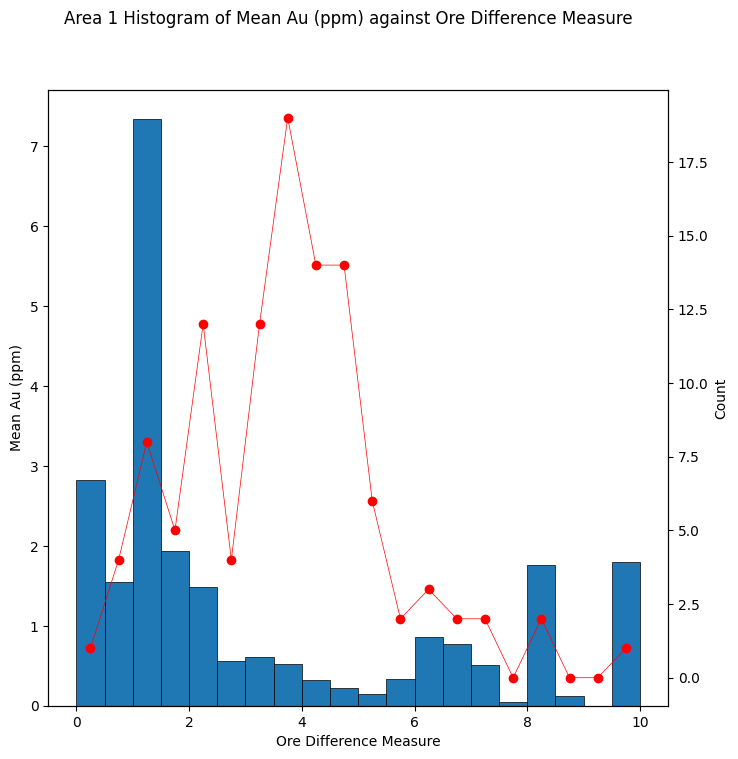

In [51]:
interval_size = 0.5
bar_labels: list[str] = []
bar_x_positions = []
bar_heights = []
bar_widths = []
bar_counts = []
for interval_start in numpy.arange(0, 10, interval_size):
    interval_end = interval_start + interval_size
    subset = area_1_data_frame[area_1_data_frame[ORE_DIFFERENCE_COLUMN].ge(interval_start) & area_1_data_frame[ORE_DIFFERENCE_COLUMN].lt(interval_end)]
    bar_labels.append(f"{interval_start:1f}")
    bar_x_positions.append(interval_start + (interval_size / 2))
    bar_heights.append(subset[GOLD_COLUMN].mean())
    bar_widths.append(interval_size)
    bar_counts.append(np.where(subset[GOLD_COLUMN] >= 2.5, 1, 0).sum())
    print(f"{interval_start:2f} to {interval_end:2f}: {subset[GOLD_COLUMN].mean()} ({subset[GOLD_COLUMN].count()}) | {subset[subset[GOLD_COLUMN]>=3].shape[0]}")

figure, axes = matplotlib.pyplot.subplots(figsize = (8, 8))
figure.suptitle("Area 1 Histogram of Mean Au (ppm) against Ore Difference Measure")
ax2 = axes.twinx()
axes.bar(bar_x_positions, bar_heights, width = bar_widths, label = bar_labels, linewidth = 0.5, edgecolor = "black")
ax2.plot(bar_x_positions, bar_counts, color = "red", linewidth = 0.5, label = "Count", marker = "o")
axes.set_xlabel("Ore Difference Measure")
axes.set_ylabel("Mean Au (ppm)")
ax2.set_ylabel("Count")


In [52]:
np.where(subset[GOLD_COLUMN] >= 3, 1, 0).sum()


1

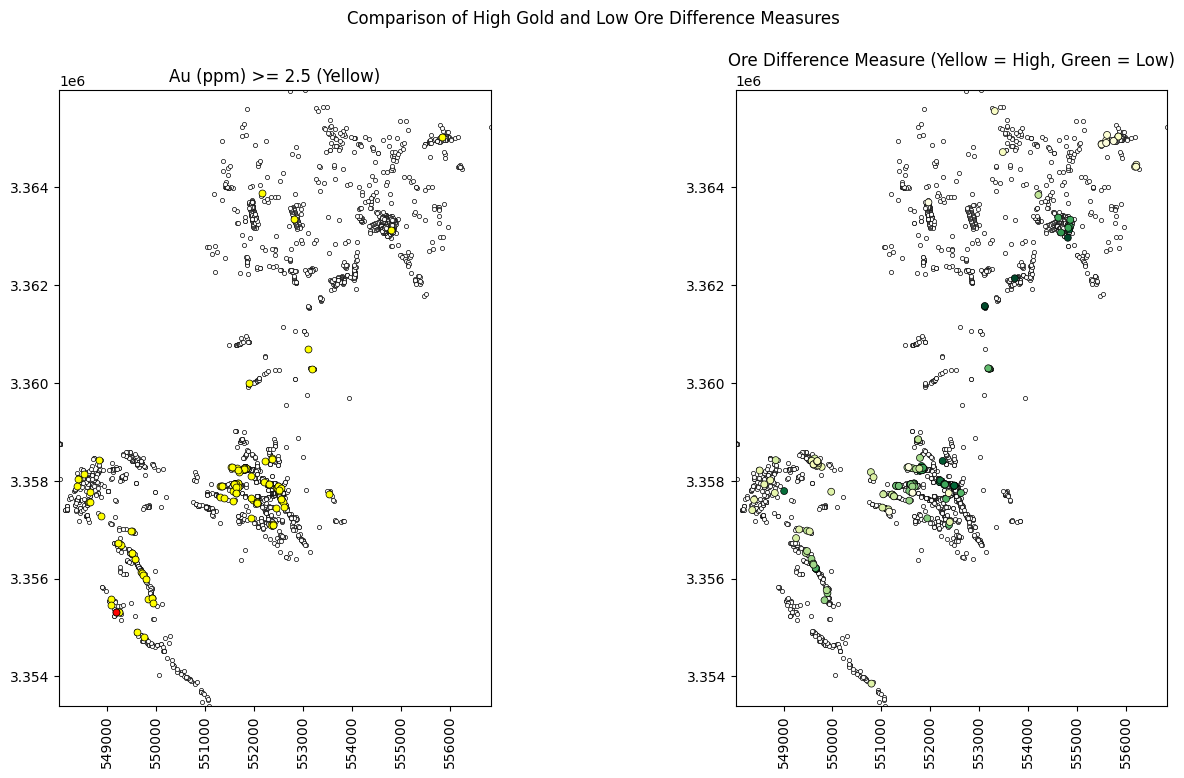

In [53]:


figure, axes = matplotlib.pyplot.subplots(nrows=1, ncols=2, figsize = (16, 8))
figure.suptitle("Comparison of High Gold and Low Ore Difference Measures")

GOLD_THRESHOLD = 2.5
DIFFERENCE_THRESHOLD = 2.5

x_min = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).min()
x_max = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).max()
y_min = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y).min()
y_max = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y).max()

for i in range(0, 2):
    axes[i].set_xlim(xmin = x_min, xmax = x_max)
    axes[i].set_ylim(ymin = y_min, ymax = y_max)

area_1_data_frame.plot(ax = axes[0], legend = True, color="white", markersize=9, linewidth=0.5, edgecolors="black")
area_1_data_frame[area_1_data_frame[GOLD_COLUMN].ge(GOLD_THRESHOLD)].plot(ax=axes[0], legend = True, color="yellow", markersize = 25, linewidth = 0.5, edgecolors = "black")
area_1_data_frame[area_1_data_frame['SampleNumber'] == AREA_1_ORE_SAMPLE_NUMBER].plot(ax=axes[0], legend = True, color="red", markersize = 25, linewidth = 0.5, edgecolors = "black")

axes[0].set_title(f"Au (ppm) >= {GOLD_THRESHOLD} (Yellow)")
axes[0].tick_params(axis='x', labelrotation=90)

area_1_data_frame.plot(ax = axes[1], legend = True, color="white", markersize=9, linewidth=0.5, edgecolors="black")
area_1_data_frame[area_1_data_frame[ORE_DIFFERENCE_COLUMN].le(DIFFERENCE_THRESHOLD)].plot(ax=axes[1], legend = True, cmap = "YlGn_r", markersize = 25, linewidth = 0.5, edgecolors = "black")
axes[1].set_title("Ore Difference Measure (Yellow = High, Green = Low)")
axes[1].tick_params(axis='x', labelrotation=90)

In [54]:
# threshold = 2
# GOLD_THRESHOLD = 2
# difference_threshold = 4
area_1_data_frame["Actual"] = area_1_data_frame[GOLD_COLUMN].apply(lambda x: x>=GOLD_THRESHOLD)
area_1_data_frame["Predicted"] = area_1_data_frame[ORE_DIFFERENCE_COLUMN].apply(lambda x: x<=DIFFERENCE_THRESHOLD)

tp: int = len(area_1_data_frame[area_1_data_frame["Actual"] & area_1_data_frame["Predicted"]])
fp: int = len(area_1_data_frame[~area_1_data_frame["Actual"] & area_1_data_frame["Predicted"]])
fn: int = len(area_1_data_frame[area_1_data_frame["Actual"] & ~area_1_data_frame["Predicted"]])
tn: int = len(area_1_data_frame[~area_1_data_frame["Actual"] & ~area_1_data_frame["Predicted"]])

accuracy: float = (tp + tn) / (tp + tn + fp + fn)
precision: float = tp / (tp + fp)
recall: float = tp / (tp + fn)
f1_score: float = (2 * precision * recall) / (precision + recall)

print(f"True Positives = {round(tp, 4)} | False Positives = {round(fp, 4)} | False Negatives = {round(fn, 4)} | True Negatives = {round(tn, 4)}")
print(f"Accuracy = {round(accuracy, 4)} | Precision = {round(precision, 4)} | Recall = {round(recall, 4)} | F1 Score = {round(f1_score, 4)}")

True Positives = 30 | False Positives = 136 | False Negatives = 85 | True Negatives = 3146
Accuracy = 0.9349 | Precision = 0.1807 | Recall = 0.2609 | F1 Score = 0.2135


In [56]:
area_1_data_frame['classification'] = ''
area_1_data_frame.loc[area_1_data_frame['Actual'] & area_1_data_frame['Predicted'], 'classification'] = 'TP'
area_1_data_frame.loc[area_1_data_frame['Actual'] & ~area_1_data_frame['Predicted'], 'classification'] = 'FN'
area_1_data_frame.loc[~area_1_data_frame['Actual'] & area_1_data_frame['Predicted'], 'classification'] = 'FP'
area_1_data_frame.loc[~area_1_data_frame['Actual'] & ~area_1_data_frame['Predicted'], 'classification'] = 'TN'

In [58]:
# area_1_data_frame.to_excel('area_1_dataframe.xlsx')

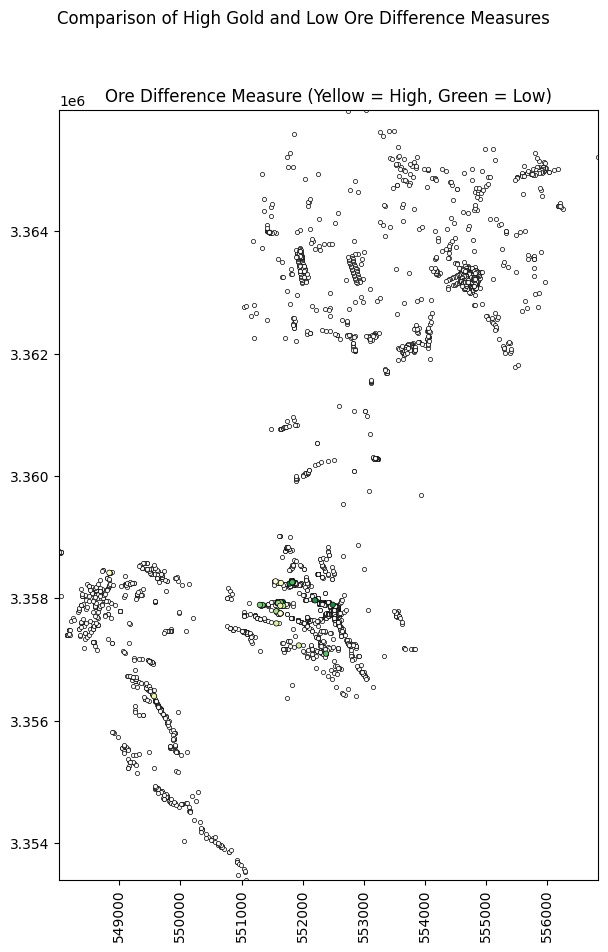

In [59]:


figure, axes = matplotlib.pyplot.subplots(nrows=1, ncols=1, figsize = (20, 10))
figure.suptitle("Comparison of High Gold and Low Ore Difference Measures")

# GOLD_THRESHOLD = 2
# DIFFERENCE_THRESHOLD = 2.5

x_min = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).min()
x_max = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).max()
y_min = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y).min()
y_max = area_1_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y).max()

# for i in range(0, 1):
axes.set_xlim(xmin = x_min, xmax = x_max)
axes.set_ylim(ymin = y_min, ymax = y_max)

# area_1_data_frame.plot(ax = axes[0], legend = True, color="white", markersize=9, linewidth=0.5, edgecolors="black")
# area_1_data_frame[area_1_data_frame[GOLD_COLUMN].ge(GOLD_THRESHOLD)].plot(ax=axes[0], legend = True, color="yellow", markersize = 25, linewidth = 0.5, edgecolors = "black")
# area_1_data_frame[area_1_data_frame['SampleNumber'] == AREA_1_ORE_SAMPLE_NUMBER].plot(ax=axes[0], legend = True, color="red", markersize = 25, linewidth = 0.5, edgecolors = "black")

# axes[0].set_title(f"Au (ppm) >= {GOLD_THRESHOLD} (Yellow)")
# axes[0].tick_params(axis='x', labelrotation=90)

area_1_data_frame.plot(ax = axes, legend = True, color="white", markersize=9, linewidth=0.5, edgecolors="black")
# area_1_data_frame[area_1_data_frame['classification'] == 'FN'].plot(ax=axes, legend = True, color="tomato", markersize = 15, linewidth = 0.5, edgecolors = "black")
# area_1_data_frame[area_1_data_frame['classification'] == 'FP'].plot(ax=axes, legend = True, color="orange", markersize = 15, linewidth = 0.5, edgecolors = "black")
area_1_data_frame[area_1_data_frame['classification'] == 'TP'].plot(ax=axes, legend = True, cmap = "YlGn_r", markersize = 15, linewidth = 0.5, edgecolors = "black")
# area_1_data_frame[area_1_data_frame['classification'] == 'TN'].plot(ax=axes[1], legend = True, color="blue", markersize = 25, linewidth = 0.5, edgecolors = "black")
# area_1_data_frame[area_1_data_frame[ORE_DIFFERENCE_COLUMN].le(DIFFERENCE_THRESHOLD)].plot(ax=axes[1], legend = True, cmap = "YlGn_r", markersize = 25, linewidth = 0.5, edgecolors = "black")
axes.set_title("Ore Difference Measure (Yellow = High, Green = Low)")
axes.tick_params(axis='x', labelrotation=90)

## GRID SEARCH - AREA 1

In [60]:
data_frame[data_frame['SampleNumber'].isin([AREA_1_ORE_SAMPLE_NUMBER, AREA_1_ANDESITE_SAMPLE_NUMBER, AREA_1_RHYOLITE_SAMPLE_NUMBER])][['SampleNumber']+RATIO_CONSTITUTENT_COLUMNS + RATIO_COLUMNS]

SampleNumber  Fe (%)  Ca (%)  Na (%)  K (%)  Al (%)   As (ppm)  Cu (ppm)  \
6655      MRS-001    1.22    0.05    0.02   0.21    0.48  27.000000      46.0   
6669      MRS-016    5.22    4.80    2.84   1.83    7.72  55.962416       3.0   
6685      MRS-032    5.02    4.45    2.91   2.42    8.67  11.000000      32.0   

      Mg (%)  (2Ca+Na+K)/Al      K/Al     As/Al  K/(Al-Na)      CCPI  \
6655    0.16      -0.219777  0.376660  0.439546   0.414318  0.953103   
6669    3.66       1.076717  0.325935  0.269679   0.329389  0.549005   
6685    1.43       0.845377  0.339460  0.125189   0.376415  0.465753   

      Ishikawa     Na/Al  
6655  0.977078  0.049376  
6669  0.881168  0.582455  
6685  0.844328  0.529777

In [61]:
area_1_data_frame[['K/Al', 'CCPI', 'Ishikawa']].describe().T

count      mean       std       min       25%       50%       75%  \
K/Al      3397.0  0.419630  0.091304  0.145461  0.383728  0.405621  0.430176   
CCPI      3397.0  0.750573  0.238129  0.001395  0.684369  0.852835  0.909474   
Ishikawa  3397.0  0.936095  0.127521  0.000000  0.943025  0.980757  0.991203   

               max  
K/Al      1.000000  
CCPI      0.987544  
Ishikawa  1.000000

In [62]:
# KEY_ELEMENT_COLUMNS = ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)', 'K/Al', 'CCPI', 'Ishikawa']
# AREA_1_ORE_VECTOR: numpy.array = numpy.array([1, 0, 0, 0, 0.5, 45, 0, 0.5, 1, 1])

# AREA_1_ANDESITE_VECTOR: numpy.array = numpy.array([5, 4.5, 3, 2.5, 8.5, 30, 1.5, 0.3, 0.5, 0.9])
# AREA_1_RHYOLITE_VECTOR: numpy.array = numpy.array([5, 5, 3, 2, 7.5, 5, 3, 0.3, 0.5, 0.8])


KEY_ELEMENT_COLUMNS = ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)', 'CCPI']
AREA_1_ORE_VECTOR: numpy.array = numpy.array([2, 1, 0, 3, 3, 130, 0, 1])
AREA_1_ANDESITE_VECTOR: numpy.array = numpy.array([5, 4.5, 3, 2.5, 8.5, 30, 1.5, 0.5])
AREA_1_RHYOLITE_VECTOR: numpy.array = numpy.array([5, 5, 3, 2, 7.5, 5, 3, 0.5])
NORMALIZATION_VECTOR: numpy.array = np.array([5, 5, 3, 2.5, 8.5, 30, 1.5, 0.5])

# KEY_ELEMENT_COLUMNS = ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)', 'CCPI', 'Ishikawa']
# AREA_1_ORE_VECTOR: numpy.array = numpy.array([2, 1, 1, 5, 3, 130, 0.5, 0.5, 1])
# AREA_1_ANDESITE_VECTOR: numpy.array = numpy.array([5, 4.5, 3, 2.5, 8.5, 30, 1.5, 0.5, 0.8])
# AREA_1_RHYOLITE_VECTOR: numpy.array = numpy.array([5, 5, 3, 2, 8, 3, 3.5, 0.5, 0.9])
# NORMALIZATION_VECTOR: numpy.array = np.array([5, 5, 3, 2.5, 8.5, 20, 3.5, 0.5, 0.9])



# KEY_ELEMENT_COLUMNS = ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)', 'CCPI', 'Ishikawa', 'Na/Al']
# AREA_1_ORE_VECTOR: numpy.array = numpy.array([2, 1, 1, 5, 3, 130, 0.5, 0.5, 1, 0])
# AREA_1_ANDESITE_VECTOR: numpy.array = numpy.array([5, 4.5, 3, 2.5, 8.5, 30, 1.5, 0.5, 0.8, 0.5])
# AREA_1_RHYOLITE_VECTOR: numpy.array = numpy.array([5, 5, 3, 2, 8, 3, 3.5, 0.5, 0.9, 0.5])
# NORMALIZATION_VECTOR: numpy.array = np.array([5,5,3,2.5,8.5, 20, 3.5, 0.5, 0.9, 0.5])

# KEY_ELEMENT_COLUMNS = ['Fe (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'CCPI', 'K/(Al-Na)', 'As/Al']
# AREA_1_ORE_VECTOR: numpy.array = numpy.array([2, 5, 3, 130, 1, 0.6, 0.8])
# AREA_1_ANDESITE_VECTOR: numpy.array = numpy.array([5, 2.5, 9, 32, 0.5, 0.4, 0.7])
# AREA_1_RHYOLITE_VECTOR: numpy.array = numpy.array([5, 2, 7.7, 3, 0.5, 0.3, 0])
# NORMALIZATION_VECTOR: numpy.array = numpy.array([5, 2, 9, 25, 0.5, 0.4, 0.5])

# KEY_ELEMENT_COLUMNS = ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)']
# AREA_1_ORE_VECTOR: numpy.array = numpy.array([1, 0, 0, 0, 0.5, 45, 0])
# AREA_1_ANDESITE_VECTOR: numpy.array = numpy.array([5, 4.5, 3, 2.5, 8.5, 30, 1.5])
# AREA_1_RHYOLITE_VECTOR: numpy.array = numpy.array([5, 5, 3, 2, 7.5, 5, 5])

In [63]:
import numpy as np


new_base_vector_2 = np.array([5, 5, 3, 2.5, 8.5, 20, 3.5, 0.5])

new_normalization_vectors_2 = [
    new_base_vector_2,
    new_base_vector_2 - np.array([1, 1, 1, 1, 2, 5, 1, 0.1]),
    new_base_vector_2 + np.array([1, 1, 1, 1, 2, 5, 1, 0.1]),
    new_base_vector_2 - np.array([2, 2, 2, 2, 4, 10, 2, 0.2]),
    new_base_vector_2 + np.array([2, 2, 2, 2, 4, 10, 2, 0.2]),
    new_base_vector_2 + np.array([0, 0, 0, 0, 0.5, 2.5, 0, 0.05]),
    new_base_vector_2 - np.array([1, 1, 1, 1, 1.5, 3.75, 0.5, 0.07]),
    new_base_vector_2 + np.array([1.5, 1.5, 1.5, 1.5, 3, 7.5, 1.5, 0.1]),
    new_base_vector_2 - np.array([0.5, 0.5, 0.5, 0.5, 1, 2.5, 0.5, 0.05]),
    new_base_vector_2 + np.array([0.5, 0.5, 0.5, 0.5, 1, 2.5, 0.5, 0.05])
]

for vec in new_normalization_vectors_2:
    print(vec)

[ 5.   5.   3.   2.5  8.5 20.   3.5  0.5]
[ 4.   4.   2.   1.5  6.5 15.   2.5  0.4]
[ 6.   6.   4.   3.5 10.5 25.   4.5  0.6]
[ 3.   3.   1.   0.5  4.5 10.   1.5  0.3]
[ 7.   7.   5.   4.5 12.5 30.   5.5  0.7]
[ 5.    5.    3.    2.5   9.   22.5   3.5   0.55]
[ 4.    4.    2.    1.5   7.   16.25  3.    0.43]
[ 6.5  6.5  4.5  4.  11.5 27.5  5.   0.6]
[ 4.5   4.5   2.5   2.    7.5  17.5   3.    0.45]
[ 5.5   5.5   3.5   3.    9.5  22.5   4.    0.55]


In [64]:
import numpy as np
import datetime
import pandas as pd
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV
from itertools import product
import mlflow

NORMALIZATION_VECTORS = new_normalization_vectors_2

class CustomThresholdClassifier:
    def __init__(self, normalization_vector=NORMALIZATION_VECTORS[0], difference_threshold=0.5):
        self.normalization_vector = normalization_vector
        self.difference_threshold = difference_threshold

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return (X <= self.difference_threshold).astype(int)

    def get_params(self, deep=True):
        return {"normalization_vector": self.normalization_vector, "difference_threshold": self.difference_threshold}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

# scorer = make_scorer(f1_score)
scorer = make_scorer(precision_score)
# Define a parameter grid
param_grid = {
    'normalization_vector': NORMALIZATION_VECTORS,
    'difference_threshold': np.arange(0.5,3, 0.5),
    'gold_threshold' : np.arange(2, 3.5, 0.5)
}

# Prepare the data
def normalize_data(data_frame, normalization_vector):
    area_1_ore_normalized_vector = np.divide(AREA_1_ORE_VECTOR, normalization_vector)
    data_frame["NormalizedVector"] = data_frame[KEY_ELEMENT_COLUMNS].apply(lambda x: np.divide(x.to_numpy(), normalization_vector), axis=1)
    data_frame["OreDifference"] = data_frame["NormalizedVector"].apply(lambda x: np.linalg.norm(x - area_1_ore_normalized_vector))
    return data_frame

# Perform grid search
best_f1_score = -1
best_accuracy = -1
best_precision = -1
best_recall = -1
best_b_accuracy = -1
best_mcc = -1 
best_auc = -1 
best_params = {}
best_loss = 10000

TRACKING_SERVER_HOST = '127.0.0.1'
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000") 

experiment_name = f"{datetime.date.today().strftime("%Y-%m-%d")} " + ' '.join([element.split(' ')[0] for element in KEY_ELEMENT_COLUMNS]).replace('/', '_')
mlflow.set_experiment(experiment_name)


for norm_vector, diff_threshold, GOLD_THRESHOLD in product(param_grid['normalization_vector'], param_grid['difference_threshold'], param_grid['gold_threshold']):
    with mlflow.start_run() as run:
        try:
            clf = CustomThresholdClassifier(normalization_vector=norm_vector, difference_threshold=diff_threshold)
            # GOLD_THRESHOLD = 3
            area_1_data_frame["Actual"] = area_1_data_frame[GOLD_COLUMN].apply(lambda x: x >= GOLD_THRESHOLD)
            area_1_data_frame_new = area_1_data_frame.copy()
            area_1_data_frame_new = normalize_data(area_1_data_frame_new, norm_vector)
            X = area_1_data_frame_new["OreDifference"].values.reshape(-1, 1)
            y = area_1_data_frame_new["Actual"].astype(int)
            clf.fit(X, y)
            preds = clf.predict(X)

            f1, weighted_precision, weighted_recall, weighted_accuracy, tp, fp, fn, tn = weighted_f1_score(area_1_data_frame_new, GOLD_THRESHOLD, diff_threshold, penalty_factor=1)
            if f1 > 0:
                loss = custom_loss(area_1_data_frame_new, GOLD_THRESHOLD, diff_threshold, max_penalty=1)
                accuracy = round(accuracy_score(y, preds), 4)

                log_params = {"normalization_vector": norm_vector,
                            "difference_threshold": diff_threshold,
                            "GOLD_THRESHOLD": GOLD_THRESHOLD,
                            "Elements": ' '.join(KEY_ELEMENT_COLUMNS)}

                mlflow.log_params(log_params)
                mlflow.log_metric("Weighted f1", f1)
                mlflow.log_metric("Loss", loss)
                mlflow.log_metric("Weighted accuracy", weighted_accuracy)
                mlflow.log_metric("Accuracy", accuracy)
                mlflow.log_metric("Weighted precision", weighted_precision)
                mlflow.log_metric("Weighted recall", weighted_recall)
                mlflow.log_metric("tp", tp.shape[0])
                mlflow.log_metric("fp", fp.shape[0])
                mlflow.log_metric("fn", fn.shape[0])
                mlflow.log_metric("tn", tn.shape[0])

                print("F1 SCORE: ", f1)
                if f1 > best_f1_score:
                    best_f1_score = f1
                    best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}

            # if loss < best_loss:
            #     best_loss = loss
            #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}
        except Exception as e:
            print(f"Exception: {e}")
            continue

        # auc = roc_auc_score(y, preds)
        # if auc > best_auc:
        #     best_auc = auc
        #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}

        # mcc = matthews_corrcoef(y, preds)
        # if mcc > best_mcc:
        #     best_mcc = mcc
        #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}
        
        # b_accuracy = balanced_accuracy_score(y, preds)
        # if b_accuracy > best_b_accuracy:
        #     best_b_accuracy = b_accuracy
        #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}

        # recall = recall_score(y, preds)
        # if recall > best_recall:
        #     best_recall = recall
        #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}

        # accuracy = accuracy_score(y, preds)
        # if accuracy > best_accuracy:
        #     best_accuracy = accuracy
        #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}

        # precision = precision_score(y, preds)
        # if precision > best_precision:
        #     best_precision = precision
        #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}

print(f"Best Parameters: {best_params}")
print(f"Best F1 Score: {best_f1_score}")
# print(f"Best Precision: {best_precision}")
# print(f"Best Accuracy: {best_accuracy}")
# print(f"Best Recall: {best_recall}")
# print(f"Best B Accuracy: {best_b_accuracy}")
# print(f"Best MCC: {best_mcc}")
# print(f"Best AUC: {best_auc}")

# Now use the best parameters to make final predictions
best_norm_vector = best_params['normalization_vector']
best_diff_threshold = best_params['difference_threshold']
area_1_data_frame_new = normalize_data(area_1_data_frame_new, best_norm_vector)
area_1_data_frame_new["Predicted"] = area_1_data_frame_new["OreDifference"].apply(lambda x: x <= best_diff_threshold)

tp = len(area_1_data_frame_new[area_1_data_frame_new["Actual"] & area_1_data_frame_new["Predicted"]])
fp = len(area_1_data_frame_new[~area_1_data_frame_new["Actual"] & area_1_data_frame_new["Predicted"]])
fn = len(area_1_data_frame_new[area_1_data_frame_new["Actual"] & ~area_1_data_frame_new["Predicted"]])
tn = len(area_1_data_frame_new[~area_1_data_frame_new["Actual"] & ~area_1_data_frame_new["Predicted"]])

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score_final = (2 * precision * recall) / (precision + recall)

print(f"True Positives = {round(tp, 4)} | False Positives = {round(fp, 4)} | False Negatives = {round(fn, 4)} | True Negatives = {round(tn, 4)}")
print(f"Accuracy = {round(accuracy, 4)} | Precision = {round(precision, 4)} | Recall = {round(recall, 4)} | F1 Score = {round(f1_score_final, 4)}")

2024/09/01 22:52:41 INFO mlflow.tracking.fluent: Experiment with name '2024-09-01 Fe Ca Na K Al Cu Mg CCPI' does not exist. Creating a new experiment.


F1 SCORE:  0.122
F1 SCORE:  0.1425
F1 SCORE:  0.1185
F1 SCORE:  0.1865
F1 SCORE:  0.1886
F1 SCORE:  0.1753
F1 SCORE:  0.2379
F1 SCORE:  0.2167
F1 SCORE:  0.2084
F1 SCORE:  0.2621
F1 SCORE:  0.2365
F1 SCORE:  0.2307
F1 SCORE:  0.0406
F1 SCORE:  0.049
F1 SCORE:  0.0569
F1 SCORE:  0.124
F1 SCORE:  0.1441
F1 SCORE:  0.1193
F1 SCORE:  0.1629
F1 SCORE:  0.1613
F1 SCORE:  0.1433
F1 SCORE:  0.2507
F1 SCORE:  0.2277
F1 SCORE:  0.2183
F1 SCORE:  0.0388
F1 SCORE:  0.0475
F1 SCORE:  0.0557
F1 SCORE:  0.1399
F1 SCORE:  0.1367
F1 SCORE:  0.1184
F1 SCORE:  0.2369
F1 SCORE:  0.2163
F1 SCORE:  0.2092
F1 SCORE:  0.2555
F1 SCORE:  0.2306
F1 SCORE:  0.2256
F1 SCORE:  0.2767
F1 SCORE:  0.2588
F1 SCORE:  0.249
Exception: cannot unpack non-iterable int object
Exception: cannot unpack non-iterable int object
Exception: cannot unpack non-iterable int object
Exception: cannot unpack non-iterable int object
Exception: cannot unpack non-iterable int object
Exception: cannot unpack non-iterable int object
F1 SCORE

## GRID SEARCH - AREA 2

<Axes: xlabel='Au (ppm)', ylabel='Density'>

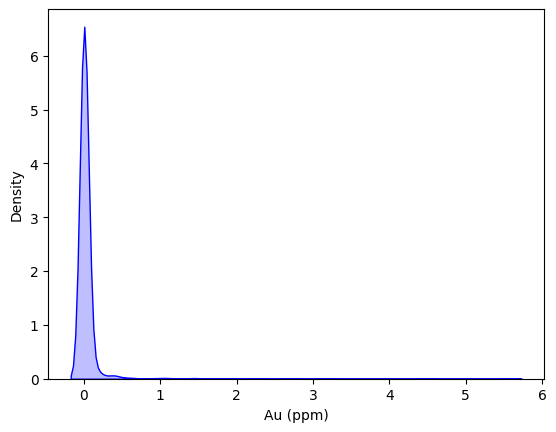

In [ ]:
# area_2_data_frame[GOLD_COLUMN]
import matplotlib.pyplot as plt
import seaborn as sns
# plt.hist(area_2_data_frame[GOLD_COLUMN], bins=2, edgecolor='black', alpha=0.7)
# sns.boxplot(y=area_2_data_frame[GOLD_COLUMN])
sns.kdeplot(area_2_data_frame[GOLD_COLUMN], shade=True, color='blue')

In [ ]:
area_2_data_frame.sort_values(by=GOLD_COLUMN, ascending=False).head(20)

SampleNumber   Easting   Northing   Latitude   Longitude  Elevation  \
1712      M023274  554576.0  3375332.0  30.509051 -110.431218     1402.0   
1713      M023275  554548.0  3375245.0  30.508267 -110.431514     1377.0   
1554     EX130288  554446.0  3376201.0  30.516898 -110.432527     1432.0   
1022       696410  554700.0  3376322.0  30.517978 -110.429874        NaN   
1319       697224  554645.0  3375642.0  30.511845 -110.430483     1459.0   
1462     EX101854  554599.0  3375447.0  30.510087 -110.430972        NaN   
1329       697234  554603.0  3375438.0  30.510006 -110.430931     1418.0   
1325       697230  554596.0  3375431.0  30.509943 -110.431004     1415.0   
1512     EX130245  554854.0  3375557.0  30.511068 -110.428309     1482.0   
1705      M023267  554507.0  3376207.0  30.516949 -110.431891     1432.0   
1711      M023273  554589.0  3375364.0  30.509339 -110.431081     1412.0   
1232       697134  554716.0  3376339.0  30.518131 -110.429706     1464.0   
1695      M023257  554359.0  3375997.0  30.515061 -110.433445     1403.0   
1318       697223  554585.0  3375368.0  30.509375 -110.431122     1423.0   
467        695564  554440.0  3376172.0  30.516637 -110.432591     1429.0   
1258       697162  554574.0  3375331.0  30.509042 -110.431239     1401.0   
1696      M023258  554354.0  3375993.0  30.515025 -110.433497     1402.0   
1528     EX130261  554356.0  3375994.0  30.515034 -110.433476     1400.0   
1330       697235  554709.0  3376914.0  30.523320 -110.429749     1481.0   
1026       696414  554728.0  3376401.0  30.518690 -110.429578        NaN   

               Area       Type Sampler  Au (ppm)  ...  K/(Al-Na)      CCPI  \
1712   Arg.5_Molino  Chip-Rock      RS     5.560  ...   0.330502  0.662339   
1713   Arg.5_Molino  Chip-Rock      RS     4.490  ...   0.267705  0.434723   
1554   Arg.5_Molino    Outcrop   RG,CB     3.190  ...   0.320708  0.089433   
1022  La Mesa Ranch    Channel     ACG     2.710  ...   0.299121  0.453760   
1319  La Mesa Ranch  ROCK CHIP     EBD     2.270  ...   0.280556  0.170406   
1462   Arg.5_Molino    Outcrop      CB     2.250  ...   0.265792  0.827250   
1329  La Mesa Ranch  ROCK CHIP     PPV     1.875  ...   0.154261  0.524365   
1325  La Mesa Ranch  ROCK CHIP     PPV     1.665  ...   0.261177  0.110700   
1512   Arg.5_Molino    Outcrop   RG,CB     1.600  ...   0.291088  0.293302   
1705   Arg.5_Molino  Chip-Rock      RS     1.505  ...   0.341228  0.140460   
1711   Arg.5_Molino  Chip-Rock      RS     1.465  ...   0.331674  0.348641   
1232  La Mesa Ranch  ROCK CHIP     PPV     1.415  ...   0.226581  0.366955   
1695   Arg.5_Molino  Chip-Rock      RS     1.395  ...   0.297094  0.855877   
1318  La Mesa Ranch       Dump     PPV     1.220  ...   0.291088  0.246220   
467   La Mesa Ranch      Soil      EBD     1.145  ...   0.330572  0.566082   
1258  La Mesa Ranch  ROCK CHIP     PPV     1.095  ...   0.355434  0.462319   
1696   Arg.5_Molino  Chip-Rock      RS     1.060  ...   0.267705  0.898476   
1528   Arg.5_Molino    Outcrop   RG,CB     1.030  ...   0.229608  0.641188   
1330  La Mesa Ranch  ROCK CHIP     PPV     0.994  ...   0.281747  0.959037   
1026  La Mesa Ranch       Chip     ACG     0.921  ...   0.215444  0.201850   

      Ishikawa     Na/Al                        Geometry  DomainId  \
1712  0.856697  0.048260  POINT (554576.000 3375332.000)       4.0   
1713  0.770212  0.043342  POINT (554548.000 3375245.000)       4.0   
1554  0.568111  0.457381  POINT (554446.000 3376201.000)       4.0   
1022  0.792736  0.015871  POINT (554700.000 3376322.000)       4.0   
1319  0.617486  0.006427  POINT (554645.000 3375642.000)       4.0   
1462  0.908625  0.053915  POINT (554599.000 3375447.000)       4.0   
1329  0.672840  0.035758  POINT (554603.000 3375438.000)       4.0   
1325  0.486669  0.019289  POINT (554596.000 3375431.000)       4.0   
1512  0.670050  0.039235  POINT (554854.000 3375557.000)       4.0   
1705  0.630340  0.096368  POINT (554507.000 3376207.000)       4.0   

In [ ]:
KEY_ELEMENT_COLUMNS = ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)', 'CCPI', 'Ishikawa', 'Na/Al']

display(area_2_data_frame[area_2_data_frame[GOLD_COLUMN] >= 1][KEY_ELEMENT_COLUMNS].describe().round(2))

display(area_2_data_frame[area_2_data_frame[GOLD_COLUMN] <= 0.009][KEY_ELEMENT_COLUMNS].describe().round(2))

Fe (%)  Ca (%)  Na (%)  K (%)  Al (%)  Cu (ppm)  Mg (%)   CCPI  \
count   18.00   18.00   18.00  18.00   18.00     18.00   18.00  18.00   
mean     1.42    3.09    0.09   0.53    1.59     19.24    0.14   0.45   
std      0.64    3.44    0.11   0.64    1.70     15.03    0.15   0.26   
min      0.61    0.12    0.01   0.06    0.30      2.00    0.01   0.09   
25%      1.17    0.68    0.03   0.24    0.84     11.28    0.04   0.26   
50%      1.40    2.09    0.05   0.42    1.25     15.30    0.06   0.44   
75%      1.60    4.32    0.09   0.46    1.42     20.10    0.22   0.62   
max      3.51   12.65    0.37   2.90    7.98     68.00    0.51   0.90   

       Ishikawa  Na/Al  
count     18.00  18.00  
mean       0.75   0.09  
std        0.14   0.13  
min        0.49   0.00  
25%        0.64   0.03  
50%        0.75   0.05  
75%        0.87   0.09  
max        0.94   0.46

Fe (%)   Ca (%)   Na (%)    K (%)   Al (%)  Cu (ppm)   Mg (%)  \
count  1414.00  1414.00  1414.00  1414.00  1414.00   1414.00  1414.00   
mean      3.19     5.25     0.90     1.81     6.23     28.67     0.79   
std       1.16     7.81     0.75     0.94     2.54     35.77     0.90   
min       0.38     0.02     0.01     0.02     0.12      1.00     0.01   
25%       2.58     0.56     0.36     1.16     5.18     15.70     0.40   
50%       3.19     1.38     0.78     2.04     7.15     24.80     0.59   
75%       3.76     6.20     1.22     2.48     7.95     34.98     0.84   
max      10.05    37.10     5.50     6.49    10.65    988.00     9.53   

          CCPI  Ishikawa    Na/Al  
count  1414.00   1414.00  1414.00  
mean      0.52      0.83     0.23  
std       0.23      0.14     0.23  
min       0.02      0.21     0.00  
25%       0.34      0.78     0.08  
50%       0.58      0.89     0.17  
75%       0.71      0.93     0.28  
max       0.97      0.99     1.00

In [ ]:

KEY_ELEMENT_COLUMNS = ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)', 'CCPI', 'Ishikawa', 'Na/Al']

AREA_2_ORE_VECTOR: numpy.array = numpy.array([1, 3, 0, 0.5, 1.5, 15, 0, 0.5, 0.7, 0])
NORMALIZATION_VECTOR: numpy.array = np.array([3, 5, 1, 2, 6, 30, 1, 0.5, 0.8, 0.2])

# Generate normalization vectors by adding/subtracting values and making adjustments
new_normalization_vectors_2 = [
    NORMALIZATION_VECTOR,
    NORMALIZATION_VECTOR - np.array([1, 1, 1, 1, 2, 5, 0.5, 0.1, 0.2, 0.05]),
    NORMALIZATION_VECTOR + np.array([1, 1, 1, 1, 2, 5, 0.5, 0.1, 0.2, 0.05]),
    NORMALIZATION_VECTOR - np.array([2, 2, 2, 2, 4, 10, 1, 0.2, 0.4, 0.1]),
    NORMALIZATION_VECTOR + np.array([2, 2, 2, 2, 4, 10, 1, 0.2, 0.4, 0.1]),
    NORMALIZATION_VECTOR + np.array([0.5, 0.5, 0.5, 0.5, 1, 2.5, 0.25, 0.05, 0.1, 0.025]),
    NORMALIZATION_VECTOR - np.array([0.5, 0.5, 0.5, 0.5, 1, 2.5, 0.25, 0.05, 0.1, 0.025]),
    NORMALIZATION_VECTOR + np.array([1.5, 1.5, 1.5, 1.5, 3, 7.5, 0.75, 0.15, 0.3, 0.075]),
    NORMALIZATION_VECTOR - np.array([1.5, 1.5, 1.5, 1.5, 3, 7.5, 0.75, 0.15, 0.3, 0.075]),
    NORMALIZATION_VECTOR + np.array([1, 1, 1, 1, 2, 5, 0.5, 0.1, 0.2, 0.05])
]

for vec in new_normalization_vectors_2:
    print(vec)

[ 3.   5.   1.   2.   6.  30.   1.   0.5  0.8  0.2]
[ 2.    4.    0.    1.    4.   25.    0.5   0.4   0.6   0.15]
[ 4.    6.    2.    3.    8.   35.    1.5   0.6   1.    0.25]
[ 1.   3.  -1.   0.   2.  20.   0.   0.3  0.4  0.1]
[ 5.   7.   3.   4.  10.  40.   2.   0.7  1.2  0.3]
[ 3.5    5.5    1.5    2.5    7.    32.5    1.25   0.55   0.9    0.225]
[ 2.5    4.5    0.5    1.5    5.    27.5    0.75   0.45   0.7    0.175]
[ 4.5    6.5    2.5    3.5    9.    37.5    1.75   0.65   1.1    0.275]
[ 1.5    3.5   -0.5    0.5    3.    22.5    0.25   0.35   0.5    0.125]
[ 4.    6.    2.    3.    8.   35.    1.5   0.6   1.    0.25]


In [ ]:
import numpy as np
import datetime
import pandas as pd
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV
from itertools import product
import mlflow

NORMALIZATION_VECTORS = new_normalization_vectors_2

# NORMALIZATION_VECTORS = normalization_vectors



class CustomThresholdClassifier:
    def __init__(self, normalization_vector=NORMALIZATION_VECTORS[0], difference_threshold=0.5):
        self.normalization_vector = normalization_vector
        self.difference_threshold = difference_threshold

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return (X <= self.difference_threshold).astype(int)

    def get_params(self, deep=True):
        return {"normalization_vector": self.normalization_vector, "difference_threshold": self.difference_threshold}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self
    

# scorer = make_scorer(f1_score)
scorer = make_scorer(precision_score)
# Define a parameter grid
param_grid = {
    'normalization_vector': NORMALIZATION_VECTORS,
    'difference_threshold': np.arange(0.5,3, 0.5),
    'gold_threshold' : np.arange(0.8, 1.1, 0.1)
}

# Prepare the data
def normalize_data(data_frame, normalization_vector):
    area_2_ore_normalized_vector = np.divide(AREA_2_ORE_VECTOR, normalization_vector)
    data_frame["NormalizedVector"] = data_frame[KEY_ELEMENT_COLUMNS].apply(lambda x: np.divide(x.to_numpy(), normalization_vector), axis=1)
    data_frame["OreDifference"] = data_frame["NormalizedVector"].apply(lambda x: np.linalg.norm(x - area_2_ore_normalized_vector))
    return data_frame

# Perform grid search
best_f1_score = -1
best_accuracy = -1
best_precision = -1
best_recall = -1
best_b_accuracy = -1
best_mcc = -1 
best_auc = -1 
best_params = {}
best_loss = 10000

TRACKING_SERVER_HOST = '127.0.0.1'
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000") 

experiment_name = f"AREA 2: {datetime.date.today().strftime("%Y-%m-%d")} " + ' '.join([element.split(' ')[0] for element in KEY_ELEMENT_COLUMNS]).replace('/', '_')
mlflow.set_experiment(experiment_name)


for norm_vector, diff_threshold, GOLD_THRESHOLD in product(param_grid['normalization_vector'], param_grid['difference_threshold'], param_grid['gold_threshold']):
    with mlflow.start_run() as run:
        try:
            clf = CustomThresholdClassifier(normalization_vector=norm_vector, difference_threshold=diff_threshold)
            # GOLD_THRESHOLD = 3
            area_2_data_frame["Actual"] = area_2_data_frame[GOLD_COLUMN].apply(lambda x: x >= GOLD_THRESHOLD)
            
            area_2_data_frame_new = area_2_data_frame.copy()
            area_2_data_frame_new = normalize_data(area_2_data_frame_new, norm_vector)
            X = area_2_data_frame_new["OreDifference"].values.reshape(-1, 1)
            y = area_2_data_frame_new["Actual"].astype(int)

            clf.fit(X, y)
            preds = clf.predict(X)

            f1, weighted_precision, weighted_recall, weighted_accuracy, tp, fp, fn, tn = weighted_f1_score(area_2_data_frame_new, GOLD_THRESHOLD, diff_threshold, penalty_factor=1)
            if f1 > 0:
                loss = custom_loss(area_2_data_frame_new, GOLD_THRESHOLD, diff_threshold, max_penalty=1)
                accuracy = round(accuracy_score(y, preds), 4)

                log_params = {"normalization_vector": norm_vector,
                            "difference_threshold": diff_threshold,
                            "GOLD_THRESHOLD": GOLD_THRESHOLD,
                            "Elements": ' '.join(KEY_ELEMENT_COLUMNS)}

                mlflow.log_params(log_params)
                mlflow.log_metric("Weighted f1", f1)
                mlflow.log_metric("Loss", loss)
                mlflow.log_metric("Weighted accuracy", weighted_accuracy)
                mlflow.log_metric("Accuracy", accuracy)
                mlflow.log_metric("Weighted precision", weighted_precision)
                mlflow.log_metric("Weighted recall", weighted_recall)
                mlflow.log_metric("tp", tp.shape[0])
                mlflow.log_metric("fp", fp.shape[0])
                mlflow.log_metric("fn", fn.shape[0])
                mlflow.log_metric("tn", tn.shape[0])

                print("F1 SCORE: ", f1)
                if f1 > best_f1_score:
                    best_f1_score = f1
                    best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}

        except Exception as e:
            print(f"Exception: {e}")
            continue

print(f"Best Parameters: {best_params}")
print(f"Best F1 Score: {best_f1_score}")




# Now use the best parameters to make final predictions
best_norm_vector = best_params['normalization_vector']
best_diff_threshold = best_params['difference_threshold']
area_2_data_frame_new = normalize_data(area_2_data_frame_new, best_norm_vector)
area_2_data_frame_new["Predicted"] = area_2_data_frame_new["OreDifference"].apply(lambda x: x <= best_diff_threshold)

tp = len(area_2_data_frame_new[area_2_data_frame_new["Actual"] & area_2_data_frame_new["Predicted"]])
fp = len(area_2_data_frame_new[~area_2_data_frame_new["Actual"] & area_2_data_frame_new["Predicted"]])
fn = len(area_2_data_frame_new[area_2_data_frame_new["Actual"] & ~area_2_data_frame_new["Predicted"]])
tn = len(area_2_data_frame_new[~area_2_data_frame_new["Actual"] & ~area_2_data_frame_new["Predicted"]])

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score_final = (2 * precision * recall) / (precision + recall)

print(f"True Positives = {round(tp, 4)} | False Positives = {round(fp, 4)} | False Negatives = {round(fn, 4)} | True Negatives = {round(tn, 4)}")
print(f"Accuracy = {round(accuracy, 4)} | Precision = {round(precision, 4)} | Recall = {round(recall, 4)} | F1 Score = {round(f1_score_final, 4)}")

2024/08/07 11:58:44 INFO mlflow.tracking.fluent: Experiment with name 'AREA 2: 2024-08-07 Fe Ca Na K Al Cu Mg CCPI Ishikawa Na_Al' does not exist. Creating a new experiment.


F1 SCORE:  0.3082
F1 SCORE:  0.3242
F1 SCORE:  0.3483
F1 SCORE:  0.3963
F1 SCORE:  0.3298
F1 SCORE:  0.3358
F1 SCORE:  0.3442
F1 SCORE:  0.3207
F1 SCORE:  0.1519
F1 SCORE:  0.1448
F1 SCORE:  0.1307
F1 SCORE:  0.113
F1 SCORE:  0.1042
F1 SCORE:  0.0994
F1 SCORE:  0.0899
F1 SCORE:  0.078
F1 SCORE:  0.0633
F1 SCORE:  0.0606
F1 SCORE:  0.0553
F1 SCORE:  0.0465
F1 SCORE:  0.3461
F1 SCORE:  0.3589
F1 SCORE:  0.3772
F1 SCORE:  0.3303
F1 SCORE:  0.1742
F1 SCORE:  0.1653
F1 SCORE:  0.1669
F1 SCORE:  0.1444
F1 SCORE:  0.0964
F1 SCORE:  0.0919
F1 SCORE:  0.0829
F1 SCORE:  0.0717
F1 SCORE:  0.0488
F1 SCORE:  0.0467
F1 SCORE:  0.0425
F1 SCORE:  0.0357
F1 SCORE:  0.0418
F1 SCORE:  0.04
F1 SCORE:  0.0364
F1 SCORE:  0.0306
F1 SCORE:  0.3239
F1 SCORE:  0.3336
F1 SCORE:  0.3474
F1 SCORE:  0.3092
F1 SCORE:  0.1397
F1 SCORE:  0.1331
F1 SCORE:  0.1194
F1 SCORE:  0.1027
F1 SCORE:  0.0509
F1 SCORE:  0.0486
F1 SCORE:  0.044
F1 SCORE:  0.0366
F1 SCORE:  0.0401
F1 SCORE:  0.0383
F1 SCORE:  0.0348
F1 SCORE:  0.02

In [ ]:
area_2_data_frame[area_2_data_frame[GOLD_COLUMN] >= 0.9]

SampleNumber   Easting   Northing   Latitude   Longitude  Elevation  \
467        695564  554440.0  3376172.0  30.516637 -110.432591     1429.0   
1022       696410  554700.0  3376322.0  30.517978 -110.429874        NaN   
1026       696414  554728.0  3376401.0  30.518690 -110.429578        NaN   
1232       697134  554716.0  3376339.0  30.518131 -110.429706     1464.0   
1258       697162  554574.0  3375331.0  30.509042 -110.431239     1401.0   
1318       697223  554585.0  3375368.0  30.509375 -110.431122     1423.0   
1319       697224  554645.0  3375642.0  30.511845 -110.430483     1459.0   
1325       697230  554596.0  3375431.0  30.509943 -110.431004     1415.0   
1329       697234  554603.0  3375438.0  30.510006 -110.430931     1418.0   
1330       697235  554709.0  3376914.0  30.523320 -110.429749     1481.0   
1462     EX101854  554599.0  3375447.0  30.510087 -110.430972        NaN   
1512     EX130245  554854.0  3375557.0  30.511068 -110.428309     1482.0   
1528     EX130261  554356.0  3375994.0  30.515034 -110.433476     1400.0   
1554     EX130288  554446.0  3376201.0  30.516898 -110.432527     1432.0   
1695      M023257  554359.0  3375997.0  30.515061 -110.433445     1403.0   
1696      M023258  554354.0  3375993.0  30.515025 -110.433497     1402.0   
1705      M023267  554507.0  3376207.0  30.516949 -110.431891     1432.0   
1711      M023273  554589.0  3375364.0  30.509339 -110.431081     1412.0   
1712      M023274  554576.0  3375332.0  30.509051 -110.431218     1402.0   
1713      M023275  554548.0  3375245.0  30.508267 -110.431514     1377.0   

               Area       Type Sampler  Au (ppm)  ...      CCPI  Ishikawa  \
467   La Mesa Ranch      Soil      EBD     1.145  ...  0.566082  0.903767   
1022  La Mesa Ranch    Channel     ACG     2.710  ...  0.453760  0.792736   
1026  La Mesa Ranch       Chip     ACG     0.921  ...  0.201850  0.649566   
1232  La Mesa Ranch  ROCK CHIP     PPV     1.415  ...  0.366955  0.723279   
1258  La Mesa Ranch  ROCK CHIP     PPV     1.095  ...  0.462319  0.841062   
1318  La Mesa Ranch       Dump     PPV     1.220  ...  0.246220  0.610800   
1319  La Mesa Ranch  ROCK CHIP     EBD     2.270  ...  0.170406  0.617486   
1325  La Mesa Ranch  ROCK CHIP     PPV     1.665  ...  0.110700  0.486669   
1329  La Mesa Ranch  ROCK CHIP     PPV     1.875  ...  0.524365  0.672840   
1330  La Mesa Ranch  ROCK CHIP     PPV     0.994  ...  0.959037  0.986215   
1462   Arg.5_Molino    Outcrop      CB     2.250  ...  0.827250  0.908625   
1512   Arg.5_Molino    Outcrop   RG,CB     1.600  ...  0.293302  0.670050   
1528   Arg.5_Molino    Outcrop   RG,CB     1.030  ...  0.641188  0.873213   
1554   Arg.5_Molino    Outcrop   RG,CB     3.190  ...  0.089433  0.568111   
1695   Arg.5_Molino  Chip-Rock      RS     1.395  ...  0.855877  0.941245   
1696   Arg.5_Molino  Chip-Rock      RS     1.060  ...  0.898476  0.929383   
1705   Arg.5_Molino  Chip-Rock      RS     1.505  ...  0.140460  0.630340   
1711   Arg.5_Molino  Chip-Rock      RS     1.465  ...  0.348641  0.722845   
1712   Arg.5_Molino  Chip-Rock      RS     5.560  ...  0.662339  0.856697   
1713   Arg.5_Molino  Chip-Rock      RS     4.490  ...  0.434723  0.770212   

         Na/Al                        Geometry  DomainId  DomainName  AreaId  \
467   0.036577  POINT (554440.000 3376172.000)       4.0     La Mesa     2.0   
1022  0.015871  POINT (554700.000 3376322.000)       4.0     La Mesa     2.0   
1026  0.202119  POINT (554728.000 3376401.000)       4.0     La Mesa     2.0   
1232  0.443785  POINT (554716.000 3376339.000)       4.0     La Mesa     2.0   
1258  0.000000  POINT (554574.000 3375331.000)       4.0     La Mesa     2.0   
1318  0.027976  POINT (554585.000 3375368.000)       4.0     La Mesa     2.0   
1319  0.006427  POINT (554645.000 3375642.000)       4.0     La Mesa     2.0   
1325  0.019289  POINT (554596.000 3375431.000)       4.0     La Mesa     2.0   
1329  0.035758  POINT (554603.000 3375438.000)       4.0     La Mesa  

In [ ]:
def normalize_data(data_frame, normalization_vector):
    area_2_ore_normalized_vector = np.divide(AREA_2_ORE_VECTOR, normalization_vector)
    data_frame["NormalizedVector"] = data_frame[KEY_ELEMENT_COLUMNS].apply(lambda x: np.divide(x.to_numpy(), normalization_vector), axis=1)
    data_frame["OreDifference"] = data_frame["NormalizedVector"].apply(lambda x: np.linalg.norm(x - area_2_ore_normalized_vector))
    return data_frame

In [ ]:
normalize_data(area_2_data_frame_new, norm_vector)

ValueError: operands could not be broadcast together with shapes (7,) (8,) 

In [ ]:

# Now use the best parameters to make final predictions
best_norm_vector = best_params['normalization_vector']
best_diff_threshold = best_params['difference_threshold']
area_2_data_frame_new = normalize_data(area_2_data_frame_new, best_norm_vector)
area_2_data_frame_new["Predicted"] = area_2_data_frame_new["OreDifference"].apply(lambda x: x <= best_diff_threshold)

tp = len(area_2_data_frame_new[area_2_data_frame_new["Actual"] & area_2_data_frame_new["Predicted"]])
fp = len(area_2_data_frame_new[~area_2_data_frame_new["Actual"] & area_2_data_frame_new["Predicted"]])
fn = len(area_2_data_frame_new[area_2_data_frame_new["Actual"] & ~area_2_data_frame_new["Predicted"]])
tn = len(area_2_data_frame_new[~area_2_data_frame_new["Actual"] & ~area_2_data_frame_new["Predicted"]])

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score_final = (2 * precision * recall) / (precision + recall)

print(f"True Positives = {round(tp, 4)} | False Positives = {round(fp, 4)} | False Negatives = {round(fn, 4)} | True Negatives = {round(tn, 4)}")
print(f"Accuracy = {round(accuracy, 4)} | Precision = {round(precision, 4)} | Recall = {round(recall, 4)} | F1 Score = {round(f1_score_final, 4)}")

In [ ]:
param_grid = {
    'normalization_vector': NORMALIZATION_VECTORS,
    'difference_threshold': np.arange(0.5,3, 0.5),
    'gold_threshold' : np.arange(0.8, 1, 0.1)
}

for norm_vector, diff_threshold, GOLD_THRESHOLD in product(param_grid['normalization_vector'], param_grid['difference_threshold'], param_grid['gold_threshold']):
    print(f"Normalizing Vector: {norm_vector}, Difference Threshold: {diff_threshold}, Gold Threshold: {GOLD_THRESHOLD}")

Normalizing Vector: [ 3.   5.   1.   2.   6.  30.   1.   0.5], Difference Threshold: 0.5, Gold Threshold: 0.8
Normalizing Vector: [ 3.   5.   1.   2.   6.  30.   1.   0.5], Difference Threshold: 0.5, Gold Threshold: 0.9
Normalizing Vector: [ 3.   5.   1.   2.   6.  30.   1.   0.5], Difference Threshold: 1.0, Gold Threshold: 0.8
Normalizing Vector: [ 3.   5.   1.   2.   6.  30.   1.   0.5], Difference Threshold: 1.0, Gold Threshold: 0.9
Normalizing Vector: [ 3.   5.   1.   2.   6.  30.   1.   0.5], Difference Threshold: 1.5, Gold Threshold: 0.8
Normalizing Vector: [ 3.   5.   1.   2.   6.  30.   1.   0.5], Difference Threshold: 1.5, Gold Threshold: 0.9
Normalizing Vector: [ 3.   5.   1.   2.   6.  30.   1.   0.5], Difference Threshold: 2.0, Gold Threshold: 0.8
Normalizing Vector: [ 3.   5.   1.   2.   6.  30.   1.   0.5], Difference Threshold: 2.0, Gold Threshold: 0.9
Normalizing Vector: [ 3.   5.   1.   2.   6.  30.   1.   0.5], Difference Threshold: 2.5, Gold Threshold: 0.8
Normalizin

In [ ]:
param_grid['gold_threshold']

array([], dtype=float64)

In [ ]:
mapping = {
    'Fe Ca Na K Al Cu Mg CCPI': ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)', 'CCPI'],
    'Fe Ca Na K Al Cu Mg CCPI Ishikawa Na_Al': ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)', 'CCPI', 'Ishikawa', 'Na/Al'],
    'Fe Ca Na K Al Cu Mg CCPI Ishikawa': ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)', 'CCPI', 'Ishikawa'],
    'Fe K Al Cu CCPI K_(Al-Na) As_Al': ['Fe (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'CCPI', 'K/(Al-Na)', 'As/Al']
}

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, precision_recall_curve, recall_score, balanced_accuracy_score, matthews_corrcoef, roc_auc_score
from sklearn.model_selection import GridSearchCV
from itertools import product

# Assuming area_2_data_frame and other necessary columns are already defined

# DEFINING VECTORS
AREA_2_ORE_VECTOR = np.array([1, 5, 0, 0, 1, 15, 0])
AREA_2_LIMESTONE_VECTOR = np.array([0, 25, 0.5, 0.5, 2, 24, 0])
AREA_2_SILTSTONE_VECTOR = np.array([4.5, 4.5, 0, 0, 2, 30, 2])


# Define possible normalization vectors
NORMALIZATION_VECTORS = [
    np.array([5, 25, 5, 5, 5, 30, 5]),
    np.array([4, 20, 4, 4, 4, 25, 4]),
    np.array([6, 30, 6, 6, 6, 35, 6]),
    np.array([3, 15, 3, 3, 3, 20, 3]),
    np.array([7, 35, 7, 7, 7, 40, 7]),
    np.array([5, 20, 5, 5, 5, 25, 5]),
    np.array([4, 25, 4, 4, 4, 30, 4]),
    np.array([6, 25, 6, 6, 6, 30, 6]),
    np.array([5, 30, 5, 5, 5, 35, 5]),
    np.array([3, 20, 3, 3, 3, 25, 3])
]

GOLD_THRESHOLD = 1
area_2_data_frame["Actual"] = area_2_data_frame[GOLD_COLUMN].apply(lambda x: x >= GOLD_THRESHOLD)

# Custom classifier to handle normalization and threshold
class CustomThresholdClassifier:
    def __init__(self, normalization_vector=NORMALIZATION_VECTORS[0], difference_threshold=0.5):
        self.normalization_vector = normalization_vector
        self.difference_threshold = difference_threshold

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return (X <= self.difference_threshold).astype(int)

    def get_params(self, deep=True):
        return {"normalization_vector": self.normalization_vector, "difference_threshold": self.difference_threshold}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

# Define a custom scorer
scorer = make_scorer(f1_score)

# Define a parameter grid
param_grid = {
    'normalization_vector': NORMALIZATION_VECTORS,
    'difference_threshold': np.arange(0.1, 1.0, 0.1)
}

# Prepare the data
def normalize_data(data_frame, normalization_vector):
    area_2_ore_normalized_vector = np.divide(AREA_2_ORE_VECTOR, normalization_vector)
    data_frame["NormalizedVector"] = data_frame[KEY_ELEMENT_COLUMNS].apply(lambda x: np.divide(x.to_numpy(), normalization_vector), axis=1)
    data_frame["OreDifference"] = data_frame["NormalizedVector"].apply(lambda x: np.linalg.norm(x - area_2_ore_normalized_vector))
    return data_frame

# Perform grid search
best_f1_score = -1
best_accuracy = -1
best_precision = -1
best_recall = -1
best_b_accuracy = -1
best_mcc = -1 
best_auc = -1 
best_params = {}

for norm_vector, diff_threshold in product(NORMALIZATION_VECTORS, np.arange(0.1, 0.5, 0.1)):
    clf = CustomThresholdClassifier(normalization_vector=norm_vector, difference_threshold=diff_threshold)
    area_2_data_frame = normalize_data(area_2_data_frame, norm_vector)
    X = area_2_data_frame["OreDifference"].values.reshape(-1, 1)
    y = area_2_data_frame["Actual"].astype(int)
    clf.fit(X, y)
    preds = clf.predict(X)
    
    f1 = f1_score(y, preds)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}

    # auc = roc_auc_score(y, preds)
    # if auc > best_auc:
    #     best_auc = auc
    #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}

    # mcc = matthews_corrcoef(y, preds)
    # if mcc > best_mcc:
    #     best_mcc = mcc
    #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}
    
    # b_accuracy = balanced_accuracy_score(y, preds)
    # if b_accuracy > best_b_accuracy:
    #     best_b_accuracy = b_accuracy
    #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}

    # recall = recall_score(y, preds)
    # if recall > best_recall:
    #     best_recall = recall
    #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}

    # accuracy = accuracy_score(y, preds)
    # if accuracy > best_accuracy:
    #     best_accuracy = accuracy
    #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}

    # precision = precision_score(y, preds)
    # if precision > best_precision:
    #     best_precision = precision
    #     best_params = {'normalization_vector': norm_vector, 'difference_threshold': diff_threshold}

print(f"Best Parameters: {best_params}")
print(f"Best F1 Score: {best_f1_score}")
# print(f"Best Precision: {best_precision}")
# print(f"Best Accuracy: {best_accuracy}")
# print(f"Best Recall: {best_recall}")
# print(f"Best B Accuracy: {best_b_accuracy}")
# print(f"Best MCC: {best_mcc}")
# print(f"Best AUC: {best_auc}")

# Now use the best parameters to make final predictions
best_norm_vector = best_params['normalization_vector']
best_diff_threshold = best_params['difference_threshold']
area_2_data_frame = normalize_data(area_2_data_frame, best_norm_vector)
area_2_data_frame["Predicted"] = area_2_data_frame["OreDifference"].apply(lambda x: x <= best_diff_threshold)

tp = len(area_2_data_frame[area_2_data_frame["Actual"] & area_2_data_frame["Predicted"]])
fp = len(area_2_data_frame[~area_2_data_frame["Actual"] & area_2_data_frame["Predicted"]])
fn = len(area_2_data_frame[area_2_data_frame["Actual"] & ~area_2_data_frame["Predicted"]])
tn = len(area_2_data_frame[~area_2_data_frame["Actual"] & ~area_2_data_frame["Predicted"]])

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score_final = (2 * precision * recall) / (precision + recall)

print(f"True Positives = {round(tp, 4)} | False Positives = {round(fp, 4)} | False Negatives = {round(fn, 4)} | True Negatives = {round(tn, 4)}")
print(f"Accuracy = {round(accuracy, 4)} | Precision = {round(precision, 4)} | Recall = {round(recall, 4)} | F1 Score = {round(f1_score_final, 4)}")

Best Parameters: {'normalization_vector': array([ 7, 35,  7,  7,  7, 40,  7]), 'difference_threshold': 0.2}
Best F1 Score: 0.45714285714285713
True Positives = 8 | False Positives = 9 | False Negatives = 10 | True Negatives = 1696
Accuracy = 0.989 | Precision = 0.4706 | Recall = 0.4444 | F1 Score = 0.4571


## AREA 2 IMPLEMENTATION

In [42]:
area_2_data_frame.sort_values(by=GOLD_COLUMN, ascending=False).head(20)

SampleNumber   Easting   Northing   Latitude   Longitude  Elevation  \
1712      M023274  554576.0  3375332.0  30.509051 -110.431218     1402.0   
1713      M023275  554548.0  3375245.0  30.508267 -110.431514     1377.0   
1554     EX130288  554446.0  3376201.0  30.516898 -110.432527     1432.0   
1022       696410  554700.0  3376322.0  30.517978 -110.429874        NaN   
1319       697224  554645.0  3375642.0  30.511845 -110.430483     1459.0   
1462     EX101854  554599.0  3375447.0  30.510087 -110.430972        NaN   
1329       697234  554603.0  3375438.0  30.510006 -110.430931     1418.0   
1325       697230  554596.0  3375431.0  30.509943 -110.431004     1415.0   
1512     EX130245  554854.0  3375557.0  30.511068 -110.428309     1482.0   
1705      M023267  554507.0  3376207.0  30.516949 -110.431891     1432.0   
1711      M023273  554589.0  3375364.0  30.509339 -110.431081     1412.0   
1232       697134  554716.0  3376339.0  30.518131 -110.429706     1464.0   
1695      M023257  554359.0  3375997.0  30.515061 -110.433445     1403.0   
1318       697223  554585.0  3375368.0  30.509375 -110.431122     1423.0   
467        695564  554440.0  3376172.0  30.516637 -110.432591     1429.0   
1258       697162  554574.0  3375331.0  30.509042 -110.431239     1401.0   
1696      M023258  554354.0  3375993.0  30.515025 -110.433497     1402.0   
1528     EX130261  554356.0  3375994.0  30.515034 -110.433476     1400.0   
1330       697235  554709.0  3376914.0  30.523320 -110.429749     1481.0   
1026       696414  554728.0  3376401.0  30.518690 -110.429578        NaN   

               Area       Type Sampler  Au (ppm)  ...      K/Al     As/Al  \
1712   Arg.5_Molino  Chip-Rock      RS     5.560  ...  0.360672  0.546394   
1713   Arg.5_Molino  Chip-Rock      RS     4.490  ...  0.346471  0.464439   
1554   Arg.5_Molino    Outcrop   RG,CB     3.190  ...  0.333535  0.499933   
1022  La Mesa Ranch    Channel     ACG     2.710  ...  0.355455  0.652369   
1319  La Mesa Ranch  ROCK CHIP     EBD     2.270  ...  0.351564  0.426264   
1462   Arg.5_Molino    Outcrop      CB     2.250  ...  0.345430  0.449379   
1329  La Mesa Ranch  ROCK CHIP     PPV     1.875  ...  0.311869  0.414000   
1325  La Mesa Ranch  ROCK CHIP     PPV     1.665  ...  0.346069  0.521374   
1512   Arg.5_Molino    Outcrop   RG,CB     1.600  ...  0.352371  0.641381   
1705   Arg.5_Molino  Chip-Rock      RS     1.505  ...  0.360327  0.572063   
1711   Arg.5_Molino  Chip-Rock      RS     1.465  ...  0.360830  0.559362   
1232  La Mesa Ranch  ROCK CHIP     PPV     1.415  ...  0.311085  0.556026   
1695   Arg.5_Molino  Chip-Rock      RS     1.395  ...  0.352248  0.508950   
1318  La Mesa Ranch       Dump     PPV     1.220  ...  0.352960  0.566691   
467   La Mesa Ranch      Soil      EBD     1.145  ...  0.361301  0.518970   
1258  La Mesa Ranch  ROCK CHIP     PPV     1.095  ...  0.368360  0.573709   
1696   Arg.5_Molino  Chip-Rock      RS     1.060  ...  0.343386  0.524488   
1528   Arg.5_Molino    Outcrop   RG,CB     1.030  ...  0.330339  0.471357   
1330  La Mesa Ranch  ROCK CHIP     PPV     0.994  ...  0.352132  0.701492   
1026  La Mesa Ranch       Chip     ACG     0.921  ...  0.323340  0.489567   

      K/(Al-Na)      CCPI  Ishikawa     Na/Al                        Geometry  \
1712   0.330502  0.662339  0.856697  0.048260  POINT (554576.000 3375332.000)   
1713   0.267705  0.434723  0.770212  0.043342  POINT (554548.000 3375245.000)   
1554   0.320708  0.089433  0.568111  0.457381  POINT (554446.000 3376201.000)   
1022   0.299121  0.453760  0.792736  0.015871  POINT (554700.000 3376322.000)   
1319   0.280556  0.170406  0.617486  0.006427  POINT (554645.000 3375642.000)   
1462   0.265792  0.827250  0.908625  0.053915  POINT (554599.000 3375447.000)   
1329   0.154261  0.524365  0.672840  0.035758  POINT (554603.000 3375438.000)   
1325   0.261177  0.110700  0.486669  0.019289  POINT (554596.000 3375431.000)   
1512   0.291088  0.293302  0.670050  0.039235  POINT (554854.

In [144]:

KEY_ELEMENT_COLUMNS = ['Fe (%)', 'Ca (%)', 'Na (%)', 'K (%)', 'Al (%)', 'Cu (ppm)', 'Mg (%)', 'CCPI']


In [82]:
area_2_data_frame[area_2_data_frame[GOLD_COLUMN] >= 2][KEY_ELEMENT_COLUMNS+[GOLD_COLUMN]].describe().round(3).loc[['mean']]

Fe (%)  Ca (%)  Na (%)  K (%)  Al (%)  Cu (ppm)  Mg (%)  CCPI  Ishikawa  \
mean   1.303   3.822   0.092   0.39   1.228     11.65   0.143  0.44     0.752   

      Na/Al  Au (ppm)  
mean  0.104     3.412

In [84]:
area_2_data_frame[area_2_data_frame['SampleNumber'] == int(AREA_2_BG_SAMPLE_NUMBER)][KEY_ELEMENT_COLUMNS+[GOLD_COLUMN]]

Fe (%)  Ca (%)  Na (%)  K (%)  Al (%)  Cu (ppm)  Mg (%)      CCPI  \
491    4.17    0.74    0.93   2.74    7.93      50.6    0.48  0.731117   

     Ishikawa     Na/Al  Au (ppm)  
491  0.936893  0.172934     0.005

In [145]:
GOLD_THRESHOLD = 1.1
difference_threshold = 1.5

# DEFINING VECTORS
AREA_2_ORE_VECTOR: numpy.array = numpy.array([1, 4, 0, 0, 1.2, 12, 0, 0.5])
AREA_2_LIMESTONE_VECTOR: numpy.array = numpy.array([0, 25, 0.5, 0.5, 2, 24, 0])
AREA_2_SILTSTONE_VECTOR: numpy.array = numpy.array( [4.5, 4.5, 0, 0, 2, 30, 2])


# NORMALIZING
# NORMALIZATION_VECTOR: numpy.array = numpy.array([5, 25, 5, 5, 5, 30, 5])
NORMALIZATION_VECTOR: numpy.array = numpy.array([ 4, 0.5, 1, 3, 8, 50, 0.5, 0.7])
# NORMALIZATION_VECTOR: numpy.array = numpy.array([1.5, 3.5, -0.5, 0.5, 3.0, 22.5, 0.25, 0.35, 0.5, 0.125])
AREA_2_ORE_NORMALIZED_VECTOR: numpy.array = numpy.divide(AREA_2_ORE_VECTOR, NORMALIZATION_VECTOR)
# AREA_2_LIMESTONE_NORMALIZED_VECTOR: numpy.array = numpy.divide(AREA_2_LIMESTONE_VECTOR, NORMALIZATION_VECTOR)
# AREA_2_SILTSTONE_NORMALIZED_VECTOR: numpy.array = numpy.divide(AREA_2_SILTSTONE_VECTOR, NORMALIZATION_VECTOR)

NORMALIZED_VECTOR_COLUMN: str = "NormalizedVector"
ORE_DIFFERENCE_COLUMN: str = "OreDifference"

area_2_data_frame[NORMALIZED_VECTOR_COLUMN] = area_2_data_frame[KEY_ELEMENT_COLUMNS].apply(lambda x: numpy.divide(x.to_numpy(), NORMALIZATION_VECTOR), axis = 1)
area_2_data_frame[ORE_DIFFERENCE_COLUMN] = area_2_data_frame[NORMALIZED_VECTOR_COLUMN].apply(lambda x: numpy.linalg.norm(x - AREA_2_ORE_NORMALIZED_VECTOR))



0.000000 to 0.200000: nan (0)
0.200000 to 0.400000: nan (0)
0.400000 to 0.600000: 0.9985 (2)
0.600000 to 0.800000: nan (0)
0.800000 to 1.000000: 0.0025 (1)
1.000000 to 1.200000: 0.40933333333333327 (3)
1.200000 to 1.400000: 0.01333333333333333 (6)
1.400000 to 1.600000: 0.2115625 (8)
1.600000 to 1.800000: 0.015954545454545457 (11)
1.800000 to 2.000000: 0.009708333333333334 (12)
2.000000 to 2.200000: 0.005642857142857142 (14)
2.200000 to 2.400000: 0.03647222222222222 (18)
2.400000 to 2.600000: 0.004722222222222222 (18)
2.600000 to 2.800000: 0.025952380952380956 (21)
2.800000 to 3.000000: 0.1381470588235294 (17)
3.000000 to 3.200000: 0.025769230769230766 (26)
3.200000 to 3.400000: 0.19089285714285711 (14)
3.400000 to 3.600000: 0.04452 (25)
3.600000 to 3.800000: 0.1730625 (16)
3.800000 to 4.000000: 0.06139130434782605 (23)
4.000000 to 4.200000: 0.006000000000000001 (14)
4.200000 to 4.400000: 0.2535476190476191 (21)
4.400000 to 4.600000: 0.02384090909090909 (22)
4.600000 to 4.800000: 0.0039

Text(0.5, 1.0, 'Ore Difference Measure (Yellow = High, Green = Low)')

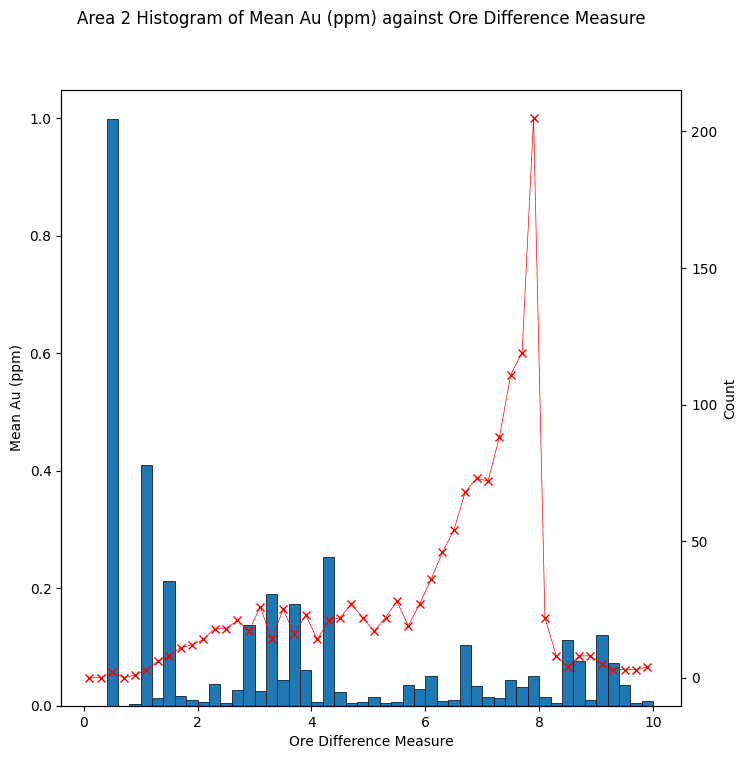

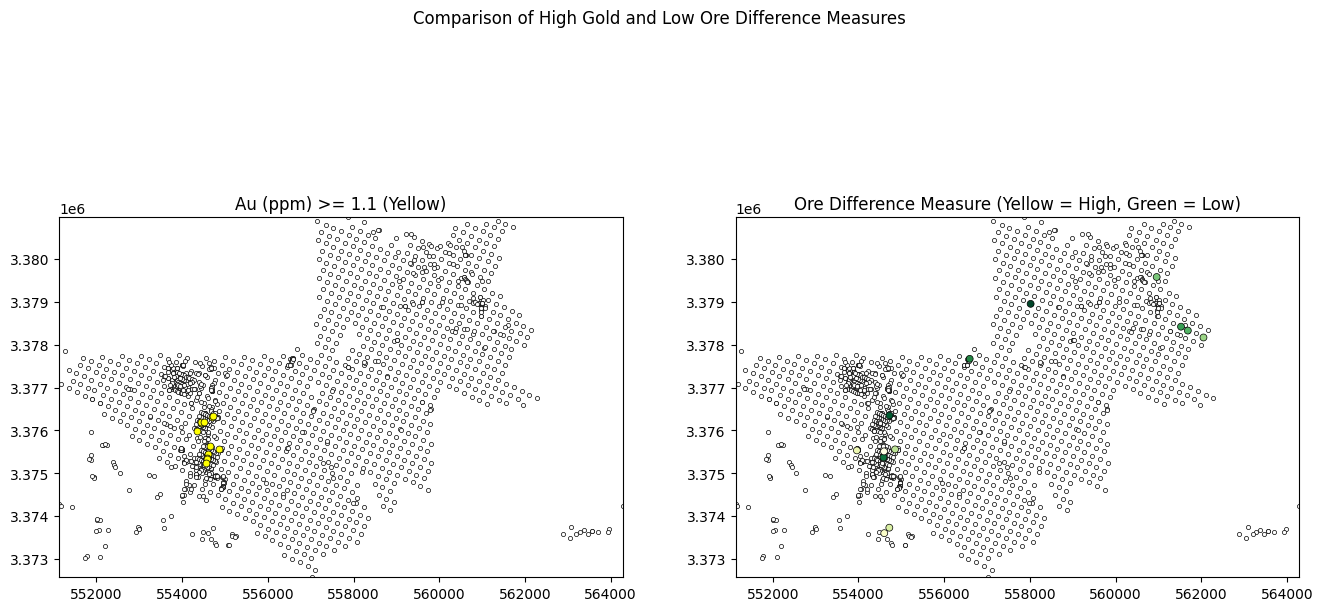

In [148]:

interval_size = 0.2
bar_labels: list[str] = []
bar_x_positions = []
bar_heights = []
bar_counts = []
bar_widths = []
for interval_start in numpy.arange(0, 10, interval_size):
    interval_end = interval_start + interval_size
    subset = area_2_data_frame[area_2_data_frame[ORE_DIFFERENCE_COLUMN].ge(interval_start) & area_2_data_frame[ORE_DIFFERENCE_COLUMN].lt(interval_end)]
    bar_labels.append(f"{interval_start:1f}")
    bar_x_positions.append(interval_start + (interval_size / 2))
    bar_heights.append(subset[GOLD_COLUMN].mean())
    bar_counts.append(subset[GOLD_COLUMN].count())
    bar_widths.append(interval_size)
    print(f"{interval_start:2f} to {interval_end:2f}: {subset[GOLD_COLUMN].mean()} ({subset[GOLD_COLUMN].count()})")

figure, axes = matplotlib.pyplot.subplots(figsize = (8, 8))
figure.suptitle("Area 2 Histogram of Mean Au (ppm) against Ore Difference Measure")
ax2 = axes.twinx()
axes.bar(bar_x_positions, bar_heights, width = bar_widths, label = bar_labels, linewidth = 0.5, edgecolor = "black")
ax2.plot(bar_x_positions, bar_counts, color = "red", linewidth = 0.5, label = "Count", marker = "x")
axes.set_xlabel("Ore Difference Measure")
axes.set_ylabel("Mean Au (ppm)")
ax2.set_ylabel("Count")


figure, axes = matplotlib.pyplot.subplots(nrows=1, ncols=2, figsize = (16, 8))
figure.suptitle("Comparison of High Gold and Low Ore Difference Measures")


x_min = area_2_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).min()
x_max = area_2_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).max()
y_min = area_2_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y).min()
y_max = area_2_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y).max()

for i in range(0, 2):
    axes[i].set_xlim(xmin = x_min, xmax = x_max)
    axes[i].set_ylim(ymin = y_min, ymax = y_max)


area_2_data_frame.plot(ax = axes[0], legend = True, color="white", markersize=9, linewidth=0.5, edgecolors="black")
area_2_data_frame[area_2_data_frame[GOLD_COLUMN].ge(GOLD_THRESHOLD)].plot(ax=axes[0], legend = True, color="yellow", markersize = 25, linewidth = 0.5, edgecolors = "black")
axes[0].set_title(f"Au (ppm) >= {GOLD_THRESHOLD} (Yellow)")


area_2_data_frame.plot(ax = axes[1], legend = True, color="white", markersize=9, linewidth=0.5, edgecolors="black")
area_2_data_frame[area_2_data_frame[ORE_DIFFERENCE_COLUMN].le(difference_threshold)].plot(ax=axes[1], legend = True, cmap = "YlGn_r", markersize = 25, linewidth = 0.5, edgecolors = "black")
axes[1].set_title("Ore Difference Measure (Yellow = High, Green = Low)")



In [149]:

# threshold = 2
area_2_data_frame["Actual"] = area_2_data_frame[GOLD_COLUMN].apply(lambda x: x>=GOLD_THRESHOLD)
area_2_data_frame["Predicted"] = area_2_data_frame[ORE_DIFFERENCE_COLUMN].apply(lambda x: x<=difference_threshold)

tp: int = len(area_2_data_frame[area_2_data_frame["Actual"] & area_2_data_frame["Predicted"]])
fp: int = len(area_2_data_frame[~area_2_data_frame["Actual"] & area_2_data_frame["Predicted"]])
fn: int = len(area_2_data_frame[area_2_data_frame["Actual"] & ~area_2_data_frame["Predicted"]])
tn: int = len(area_2_data_frame[~area_2_data_frame["Actual"] & ~area_2_data_frame["Predicted"]])

accuracy: float = (tp + tn) / (tp + tn + fp + fn)
precision: float = tp / (tp + fp)
recall: float = tp / (tp + fn)
f1_score: float = (2 * precision * recall) / (precision + recall)

print(f"True Positives = {round(tp, 4)} | False Positives = {round(fp, 4)} | False Negatives = {round(fn, 4)} | True Negatives = {round(tn, 4)}")
print(f"Accuracy = {round(accuracy, 4)} | Precision = {round(precision, 4)} | Recall = {round(recall, 4)} | F1 Score = {round(f1_score, 4)}")



True Positives = 2 | False Positives = 11 | False Negatives = 13 | True Negatives = 1697
Accuracy = 0.9861 | Precision = 0.1538 | Recall = 0.1333 | F1 Score = 0.1429


In [137]:
area_2_data_frame['classification'] = ''
area_2_data_frame.loc[area_2_data_frame['Actual'] & area_2_data_frame['Predicted'], 'classification'] = 'TP'
area_2_data_frame.loc[area_2_data_frame['Actual'] & ~area_2_data_frame['Predicted'], 'classification'] = 'FN'
area_2_data_frame.loc[~area_2_data_frame['Actual'] & area_2_data_frame['Predicted'], 'classification'] = 'FP'
area_2_data_frame.loc[~area_2_data_frame['Actual'] & ~area_2_data_frame['Predicted'], 'classification'] = 'TN'

In [138]:
area_2_data_frame.to_excel('area_2_data_frame_new.xlsx')

In [125]:

# threshold = 2
area_2_data_frame["Actual"] = area_2_data_frame[GOLD_COLUMN].apply(lambda x: x>=GOLD_THRESHOLD)
area_2_data_frame["Predicted"] = area_2_data_frame[ORE_DIFFERENCE_COLUMN].apply(lambda x: x<=difference_threshold)

tp: int = len(area_2_data_frame[area_2_data_frame["Actual"] & area_2_data_frame["Predicted"]])
fp: int = len(area_2_data_frame[~area_2_data_frame["Actual"] & area_2_data_frame["Predicted"]])
fn: int = len(area_2_data_frame[area_2_data_frame["Actual"] & ~area_2_data_frame["Predicted"]])
tn: int = len(area_2_data_frame[~area_2_data_frame["Actual"] & ~area_2_data_frame["Predicted"]])

accuracy: float = (tp + tn) / (tp + tn + fp + fn)
precision: float = tp / (tp + fp)
recall: float = tp / (tp + fn)
f1_score: float = (2 * precision * recall) / (precision + recall)

print(f"True Positives = {round(tp, 4)} | False Positives = {round(fp, 4)} | False Negatives = {round(fn, 4)} | True Negatives = {round(tn, 4)}")
print(f"Accuracy = {round(accuracy, 4)} | Precision = {round(precision, 4)} | Recall = {round(recall, 4)} | F1 Score = {round(f1_score, 4)}")



True Positives = 2 | False Positives = 5 | False Negatives = 13 | True Negatives = 1703
Accuracy = 0.9896 | Precision = 0.2857 | Recall = 0.1333 | F1 Score = 0.1818


0.000000 to 0.200000: 1.3335 (2)
0.200000 to 0.400000: 1.973 (7)
0.400000 to 0.600000: 0.29907777777777783 (45)
0.600000 to 0.800000: 0.16910975609756096 (123)
0.800000 to 1.000000: 0.056383928571428564 (56)
1.000000 to 1.200000: 0.0784186046511628 (43)
1.200000 to 1.400000: 0.029169811320754715 (53)
1.400000 to 1.600000: 0.009942622950819671 (61)
1.600000 to 1.800000: 0.014041666666666668 (72)
1.800000 to 2.000000: 0.014006024096385537 (83)


Text(0, 0.5, 'Count')

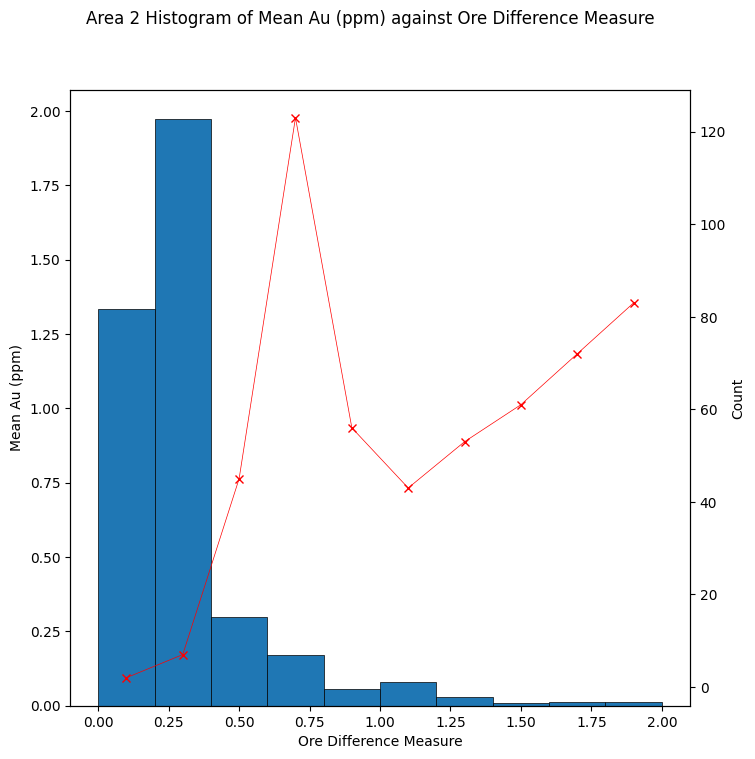

In [ ]:
interval_size = 0.2
GOLD_THRESHOLD = 2

bar_labels: list[str] = []
bar_x_positions = []
bar_heights = []
bar_counts = []
bar_widths = []
for interval_start in numpy.arange(0, 2, interval_size):
    interval_end = interval_start + interval_size
    subset = area_2_data_frame[area_2_data_frame[ORE_DIFFERENCE_COLUMN].ge(interval_start) & area_2_data_frame[ORE_DIFFERENCE_COLUMN].lt(interval_end)]
    bar_labels.append(f"{interval_start:1f}")
    bar_x_positions.append(interval_start + (interval_size / 2))
    bar_heights.append(subset[GOLD_COLUMN].mean())
    bar_widths.append(interval_size)
    bar_counts.append(subset[GOLD_COLUMN].count())
    print(f"{interval_start:2f} to {interval_end:2f}: {subset[GOLD_COLUMN].mean()} ({subset[GOLD_COLUMN].count()})")

figure, axes = matplotlib.pyplot.subplots(figsize = (8, 8))
figure.suptitle("Area 2 Histogram of Mean Au (ppm) against Ore Difference Measure")

ax2 = axes.twinx()
axes.bar(bar_x_positions, bar_heights, width = bar_widths, label = bar_labels, linewidth = 0.5, edgecolor = "black")

ax2.plot(bar_x_positions, bar_counts, color = "red", linewidth = 0.5, label = "Count", marker = "x")
axes.set_xlabel("Ore Difference Measure")
axes.set_ylabel("Mean Au (ppm)")
ax2.set_ylabel("Count")



Text(0.5, 1.0, 'Ore Difference Measure (Yellow = High, Green = Low)')

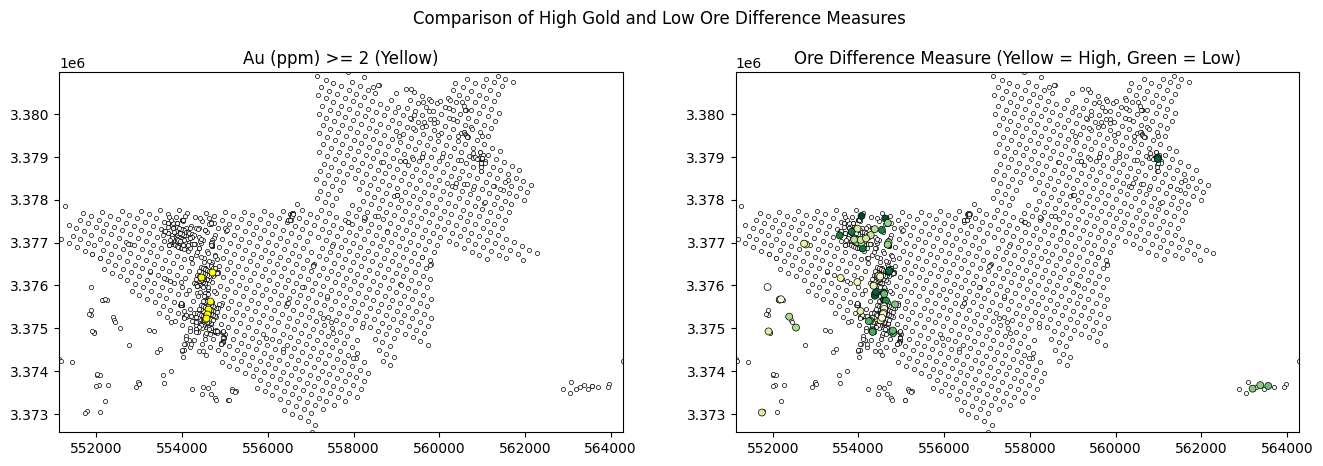

In [ ]:
figure, axes = matplotlib.pyplot.subplots(nrows=1, ncols=2, figsize = (16, 5))
figure.suptitle("Comparison of High Gold and Low Ore Difference Measures")

x_min = area_2_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).min()
x_max = area_2_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x).max()
y_min = area_2_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y).min()
y_max = area_2_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y).max()

for i in range(0, 2):
    axes[i].set_xlim(xmin = x_min, xmax = x_max)
    axes[i].set_ylim(ymin = y_min, ymax = y_max)


area_2_data_frame.plot(ax = axes[0], legend = True, color="white", markersize=9, linewidth=0.5, edgecolors="black")
area_2_data_frame[area_2_data_frame[GOLD_COLUMN].ge(GOLD_THRESHOLD)].plot(ax=axes[0], legend = True, color="yellow", markersize = 25, linewidth = 0.5, edgecolors = "black")
axes[0].set_title(f"Au (ppm) >= {GOLD_THRESHOLD} (Yellow)")

area_2_data_frame.plot(ax = axes[1], legend = True, color="white", markersize=9, linewidth=0.5, edgecolors="black")
area_2_data_frame[area_2_data_frame[ORE_DIFFERENCE_COLUMN].le(0.4)].plot(ax=axes[1], legend = True, cmap = "YlGn_r", markersize = 25, linewidth = 0.5, edgecolors = "black")
axes[1].set_title("Ore Difference Measure (Yellow = High, Green = Low)")


True Positives = 5 | False Positives = 70 | False Negatives = 1 | True Negatives = 1647
Accuracy = 0.9588 | Precision = 0.0667 | Recall = 0.8333 | F1 Score = 0.1235


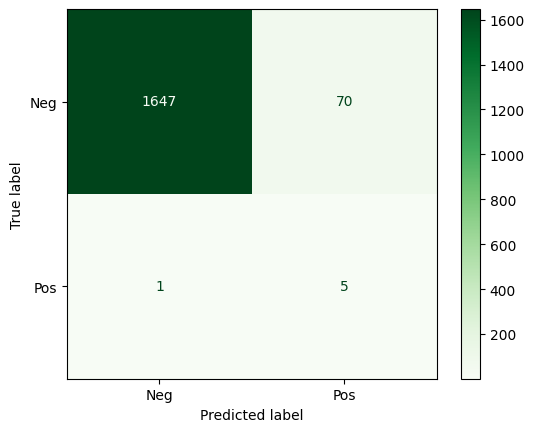

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

threshold = 2
difference_threshold = 0.4
area_2_data_frame["Actual"] = area_2_data_frame[GOLD_COLUMN].apply(lambda x: x>=threshold)
area_2_data_frame["Predicted"] = area_2_data_frame[ORE_DIFFERENCE_COLUMN].apply(lambda x: x<=difference_threshold)

tp: int = len(area_2_data_frame[area_2_data_frame["Actual"] & area_2_data_frame["Predicted"]])
fp: int = len(area_2_data_frame[~area_2_data_frame["Actual"] & area_2_data_frame["Predicted"]])
fn: int = len(area_2_data_frame[area_2_data_frame["Actual"] & ~area_2_data_frame["Predicted"]])
tn: int = len(area_2_data_frame[~area_2_data_frame["Actual"] & ~area_2_data_frame["Predicted"]])

accuracy: float = (tp + tn) / (tp + tn + fp + fn)
precision: float = tp / (tp + fp)
recall: float = tp / (tp + fn)
f1_score: float = (2 * precision * recall) / (precision + recall)

print(f"True Positives = {round(tp, 4)} | False Positives = {round(fp, 4)} | False Negatives = {round(fn, 4)} | True Negatives = {round(tn, 4)}")
print(f"Accuracy = {round(accuracy, 4)} | Precision = {round(precision, 4)} | Recall = {round(recall, 4)} | F1 Score = {round(f1_score, 4)}")

confusion_matrix = metrics.confusion_matrix(area_2_data_frame["Actual"], area_2_data_frame["Predicted"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Neg", "Pos"])
cm_display.plot(cmap='Greens')
# cm_display.plot()
plt.show()

True Positives = 3 | False Positives = 6 | False Negatives = 3 | True Negatives = 1711
Accuracy = 0.9948 | Precision = 0.3333 | Recall = 0.5 | F1 Score = 0.4


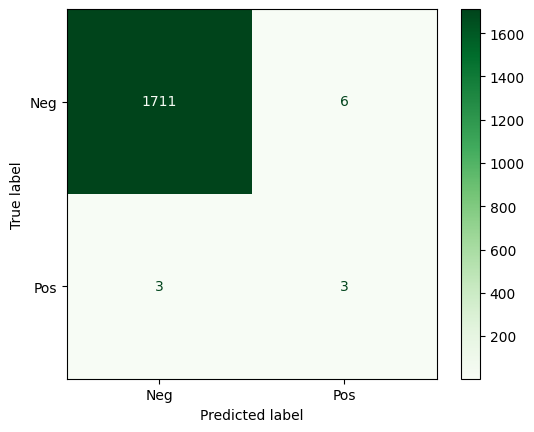

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

threshold = 2
difference_threshold = 0.4
area_2_data_frame["Actual"] = area_2_data_frame[GOLD_COLUMN].apply(lambda x: x>=threshold)
area_2_data_frame["Predicted"] = area_2_data_frame[ORE_DIFFERENCE_COLUMN].apply(lambda x: x<=difference_threshold)

tp: int = len(area_2_data_frame[area_2_data_frame["Actual"] & area_2_data_frame["Predicted"]])
fp: int = len(area_2_data_frame[~area_2_data_frame["Actual"] & area_2_data_frame["Predicted"]])
fn: int = len(area_2_data_frame[area_2_data_frame["Actual"] & ~area_2_data_frame["Predicted"]])
tn: int = len(area_2_data_frame[~area_2_data_frame["Actual"] & ~area_2_data_frame["Predicted"]])

accuracy: float = (tp + tn) / (tp + tn + fp + fn)
precision: float = tp / (tp + fp)
recall: float = tp / (tp + fn)
f1_score: float = (2 * precision * recall) / (precision + recall)

print(f"True Positives = {round(tp, 4)} | False Positives = {round(fp, 4)} | False Negatives = {round(fn, 4)} | True Negatives = {round(tn, 4)}")
print(f"Accuracy = {round(accuracy, 4)} | Precision = {round(precision, 4)} | Recall = {round(recall, 4)} | F1 Score = {round(f1_score, 4)}")

confusion_matrix = metrics.confusion_matrix(area_2_data_frame["Actual"], area_2_data_frame["Predicted"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Neg", "Pos"])
cm_display.plot(cmap='Greens')
# cm_display.plot()
plt.show()

In [ ]:
confusion_matrix

array([[1647,   70],
       [   1,    5]])

True Positives = 5 | False Positives = 70 | False Negatives = 1 | True Negatives = 1647
Accuracy = 0.958792803250145 | Precision = 0.06666666666666667 | Recall = 0.8333333333333334 | F1 Score = 0.1234567901234568


In [ ]:
threshold = 1
difference_threshold = 0.5
area_2_data_frame["Actual"] = area_2_data_frame[GOLD_COLUMN].apply(lambda x: x>=threshold)
area_2_data_frame["Predicted"] = area_2_data_frame[ORE_DIFFERENCE_COLUMN].apply(lambda x: x<=difference_threshold)

tp: int = len(area_2_data_frame[area_2_data_frame["Actual"] & area_2_data_frame["Predicted"]])
fp: int = len(area_2_data_frame[~area_2_data_frame["Actual"] & area_2_data_frame["Predicted"]])
fn: int = len(area_2_data_frame[area_2_data_frame["Actual"] & ~area_2_data_frame["Predicted"]])
tn: int = len(area_2_data_frame[~area_2_data_frame["Actual"] & ~area_2_data_frame["Predicted"]])

accuracy: float = (tp + tn) / (tp + tn + fp + fn)
precision: float = tp / (tp + fp)
recall: float = tp / (tp + fn)
f1_score: float = (2 * precision * recall) / (precision + recall)

print(f"True Positives = {tp} | False Positives = {fp} | False Negatives = {fn} | True Negatives = {tn}")
print(f"Accuracy = {accuracy} | Precision = {precision} | Recall = {recall} | F1 Score = {f1_score}")


True Positives = 3 | False Positives = 174 | False Negatives = 0 | True Negatives = 1546
Accuracy = 0.8990133488102148 | Precision = 0.01694915254237288 | Recall = 1.0 | F1 Score = 0.03333333333333333


In [ ]:
threshold = 2
difference_threshold = 0.48

area_2_data_frame["Actual"] = area_2_data_frame[GOLD_COLUMN].apply(lambda x: x>=threshold)
area_2_data_frame["Predicted"] = area_2_data_frame[ORE_DIFFERENCE_COLUMN].apply(lambda x: x<=difference_threshold)

tp: int = len(area_2_data_frame[area_2_data_frame["Actual"] & area_2_data_frame["Predicted"]])
fp: int = len(area_2_data_frame[~area_2_data_frame["Actual"] & area_2_data_frame["Predicted"]])
fn: int = len(area_2_data_frame[area_2_data_frame["Actual"] & ~area_2_data_frame["Predicted"]])
tn: int = len(area_2_data_frame[~area_2_data_frame["Actual"] & ~area_2_data_frame["Predicted"]])

accuracy: float = (tp + tn) / (tp + tn + fp + fn)
precision: float = tp / (tp + fp)
recall: float = tp / (tp + fn)
f1_score: float = (2 * precision * recall) / (precision + recall)

print(f"True Positives = {tp} | False Positives = {fp} | False Negatives = {fn} | True Negatives = {tn}")
print(f"Accuracy = {accuracy} | Precision = {precision} | Recall = {recall} | F1 Score = {f1_score}")


True Positives = 6 | False Positives = 143 | False Negatives = 0 | True Negatives = 1574
Accuracy = 0.9170052234474754 | Precision = 0.040268456375838924 | Recall = 1.0 | F1 Score = 0.07741935483870968


In [ ]:
area_2_data_frame[KEY_ELEMENT_COLUMNS+[GOLD_COLUMN, ORE_DIFFERENCE_COLUMN]].sort_values(by=GOLD_COLUMN, ascending=False).head(20)

Fe (%)  Ca (%)  Na (%)  K (%)  Al (%)  Cu (ppm)  Mg (%)  Au (ppm)  \
5871    1.44    0.65    0.05   0.44    1.22      11.8    0.03     5.560   
5872    1.26    1.85    0.03   0.24    0.79      19.8    0.24     4.490   
2463    0.94   12.65    0.37   0.33    1.27      10.0    0.37     3.190   
1044    1.81    2.14    0.04   0.64    1.89      12.4    0.12     2.710   
1346    1.15    5.43    0.02   0.42    1.30      13.9    0.06     2.270   
2120    1.22    0.21    0.04   0.27    0.90       2.0    0.04     2.250   
1356    0.62    0.52    0.01   0.06    0.30      26.7    0.01     1.875   
1352    0.61    4.71    0.01   0.13    0.43      17.3    0.03     1.665   
2421    1.69    3.83    0.05   0.46    1.41      10.0    0.05     1.600   
5864    1.33    9.96    0.10   0.51    1.42      11.1    0.37     1.505   
5870    1.35    2.38    0.05   0.43    1.19      20.2    0.05     1.465   
1256    0.73    0.93    0.30   0.21    1.06       4.5    0.03     1.415   
5854    1.61    0.22    0.07   0.43    1.32      15.3    0.16     1.395   
1345    1.45    4.48    0.02   0.23    0.70      33.4    0.12     1.220   
467     3.51    2.69    0.27   2.90    7.98      36.2    0.51     1.145   
1284    1.85    2.05    0.03   1.12    2.83      15.3    0.07     1.095   
5855    1.58    0.12    0.06   0.24    0.82      18.4    0.06     1.060   
2437    1.48    0.76    0.18   0.43    1.72      68.0    0.25     1.030   
1357    0.67    0.02    0.01   0.27    0.83       1.8    0.02     0.994   
1048    0.56    2.30    0.10   0.17    0.74      29.3    0.08     0.921   

      OreDifference  
5871       0.243339  
5872       0.224918  
2463       0.373874  
1044       0.309112  
1346       0.115569  
2120       0.479446  
1356       0.457974  
1352       0.160650  
2421       0.253772  
5864       0.289749  
5870       0.234451  
1256       0.396817  
5854       0.253483  
1345       0.625315  
467        1.748844  
1284       0.476747  
5855       0.261326  
2437       1.786342  
1357       0.491659  
1048       0.501134

In [ ]:
area_2_data_frame[GOLD_COLUMN].round().value_counts()

Au (ppm)
0.0    1694
1.0      19
2.0       6
3.0       2
6.0       1
4.0       1
Name: count, dtype: int64

# Exploration

In [ ]:
figure, axes = matplotlib.pyplot.subplots(nrows=1, ncols=1, figsize = (8, 8))

# Domains 1-4
axes.set_xlim(xmin = 545000, xmax = 565000)
axes.set_ylim(ymin = 3350000, ymax = 3382500)

data_frame.plot(ax=axes, legend=True, color="white", markersize=9, linewidth=0.5, edgecolors="black")

# High Gold
# data_frame[data_frame[TARGET_COLUMN].ge(3)].plot(ax=axes, legend=True, color="yellow", markersize=25, linewidth=0.5, edgecolors="black")

# Domains
data_frame[data_frame[DOMAIN_ID_COLUMN] == 1].plot(ax=axes, legend=True, color="red", markersize=25, linewidth=0.5, edgecolors="black")
data_frame[data_frame[DOMAIN_ID_COLUMN] == 2].plot(ax=axes, legend=True, color="green", markersize=25, linewidth=0.5, edgecolors="black")
data_frame[data_frame[DOMAIN_ID_COLUMN] == 3].plot(ax=axes, legend=True, color="blue", markersize=25, linewidth=0.5, edgecolors="black")
data_frame[data_frame[DOMAIN_ID_COLUMN] == 4].plot(ax=axes, legend=True, color="gray", markersize=25, linewidth=0.5, edgecolors="black")

# Areas
# data_frame[data_frame[AREA_ID_COLUMN] == 1].plot(ax=axes, legend=True, color="green", markersize=25, linewidth=0.5, edgecolors="black")
#data_frame[data_frame[AREA_ID_COLUMN] == 2].plot(ax=axes, legend=True, color="red", markersize=25, linewidth=0.5, edgecolors="black")

# Special Sample
# data_frame[data_frame['SampleNumber'] == 'M021872'].plot(ax=axes, legend=True, color="green", markersize=25, linewidth=0.5, edgecolors="black")

# Special Line
# data_frame[data_frame[GEOMETRY_COLUMN].apply(lambda x: distance_to_line_segment(x, domain_1_subset_line[0], domain_1_subset_line[1])).le(200)][data_frame[TARGET_COLUMN].ge(THRESHOLD)].plot(ax=axes, legend=True, color="yellow", markersize=25, linewidth=0.5, edgecolors="black")
# axes.plot([domain_1_subset_line[0].x, domain_1_subset_line[1].x], [domain_1_subset_line[0].y, domain_1_subset_line[1].y])

In [ ]:
# Create plotly figure
fig = plotly.graph_objs.Figure()

fig.update_layout(
    autosize=False,
    width=700,
    height=900,
    legend=dict(
        x=0,
        y=1,
        traceorder="reversed",
        title_font_family="Times New Roman",
        font=dict(
            size=12,
            color="black"
        ),
        bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=2
    ),
    scene_camera_eye=dict(x=10, y=10, z=1),
    # yaxis=dict(
    #     range=[0, 100]
    # ),
    xaxis=dict(
        range=[547000, 600000]
    )
)


# Plot all points
fig.add_trace(plotly.graph_objs.Scatter(
    x=data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x),
    y=data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y),
    mode='markers',
    name='All Points',
    marker=dict(color='white', size=4, line=dict(width=0.5, color='black')),
))

# Plot points above threshold

fig.add_trace(plotly.graph_objs.Scatter(
    x=data_frame[(data_frame[AREA_ID_COLUMN]==1)][GEOMETRY_COLUMN].apply(lambda x: x.x),
    y=data_frame[(data_frame[AREA_ID_COLUMN]==1)][GEOMETRY_COLUMN].apply(lambda x: x.y),
    mode='markers',
    name='Domain 1',
    marker=dict(color='lightgreen', size=4, line=dict(width=0.5, color='black')),
    hovertemplate =
    "Northing: %{x}<br>" + "Easting: %{y}<br>" 
    ))

fig.add_trace(plotly.graph_objs.Scatter(
    x=data_frame[(data_frame[AREA_ID_COLUMN]==1)&(data_frame[TARGET_COLUMN].ge(THRESHOLD))][GEOMETRY_COLUMN].apply(lambda x: x.x),
    y=data_frame[(data_frame[AREA_ID_COLUMN]==1)&(data_frame[TARGET_COLUMN].ge(THRESHOLD))][GEOMETRY_COLUMN].apply(lambda x: x.y),
    mode='markers',
    name='Area 1',
    marker=dict(color='green', size=5, line=dict(width=0.5, color='black')),
    hovertemplate =
    "Northing: %{x}<br>" + "Easting: %{y}<br>" 
))





fig.add_trace(plotly.graph_objs.Scatter(
    x=data_frame[(data_frame[AREA_ID_COLUMN]==2)][GEOMETRY_COLUMN].apply(lambda x: x.x),
    y=data_frame[(data_frame[AREA_ID_COLUMN]==2)][GEOMETRY_COLUMN].apply(lambda x: x.y),
    mode='markers',
    name='Area 2',
    marker=dict(color='red', size=5, line=dict(width=0.5, color='black')),
    hovertemplate =
    "Northing: %{x}<br>" + "Easting: %{y}<br>" 
))


fig.update_layout(
    xaxis=dict(range=[545000, 555000]),
    yaxis=dict(range=[3351000, 3366000])
)

fig.update_xaxes(title_text='Easting')
fig.update_yaxes(title_text='Northing')

# Show plot
fig.show()

In [ ]:
# seaborn.kdeplot(data=data_frame[(data_frame[DOMAIN_ID_COLUMN] == 1 ) & (data_frame[TARGET_COLUMN].ge(THRESHOLD))], x='Na (%)', fill=True)
# seaborn.kdeplot(data=data_frame[(data_frame[DOMAIN_ID_COLUMN] == 1 ) & (data_frame[TARGET_COLUMN].lt(THRESHOLD))], x='Na (%)', fill=False, color='orange')


In [ ]:
seaborn.kdeplot(data=data_frame[(data_frame[DOMAIN_ID_COLUMN] == 1 ) & (data_frame[TARGET_COLUMN].ge(THRESHOLD))], x='K (%)', fill=True)
seaborn.kdeplot(data=data_frame[(data_frame[DOMAIN_ID_COLUMN] == 1 ) & (data_frame[TARGET_COLUMN].lt(THRESHOLD))], x='K (%)', fill=False, color='orange')
# seaborn.kdeplot(data=data_frame[(data_frame[DOMAIN_ID_COLUMN] == 1 ) & (data_frame[TARGET_COLUMN].lt(THRESHOLD))], x='K (%)', fill=True)
# seaborn.kdeplot(data=data_frame[(data_frame[DOMAIN_ID_COLUMN] == 1 ) & (data_frame[TARGET_COLUMN].lt(THRESHOLD))], x='Ca (%)', fill=True)
# seaborn.kdeplot(data=data_frame[(data_frame[DOMAIN_ID_COLUMN] == 1 ) & (data_frame[TARGET_COLUMN].lt(THRESHOLD))], x='Mg (%)', fill=True)

In [ ]:
# seaborn.kdeplot(data=data_frame[(data_frame[DOMAIN_ID_COLUMN] == 1 ) & (data_frame[TARGET_COLUMN].ge(THRESHOLD))], x='Ca (%)', fill=True)
# seaborn.kdeplot(data=data_frame[(data_frame[DOMAIN_ID_COLUMN] == 1 ) & (data_frame[TARGET_COLUMN].lt(THRESHOLD))], x='Ca (%)', fill=False, color='orange')

In [ ]:
# seaborn.kdeplot(data=data_frame[(data_frame[DOMAIN_ID_COLUMN] == 1 ) & (data_frame[TARGET_COLUMN].ge(THRESHOLD))], x='Ishikawa', fill=True)
# seaborn.kdeplot(data=data_frame[(data_frame[DOMAIN_ID_COLUMN] == 1 ) & (data_frame[TARGET_COLUMN].lt(THRESHOLD))], x='Ishikawa', fill=False, color='orange')

In [ ]:
# seaborn.kdeplot(data=data_frame[(data_frame[DOMAIN_ID_COLUMN] == 1 ) & (data_frame[TARGET_COLUMN].ge(THRESHOLD))], x='CCPI', fill=True)
# seaborn.kdeplot(data=data_frame[(data_frame[DOMAIN_ID_COLUMN] == 1 ) & (data_frame[TARGET_COLUMN].lt(THRESHOLD))], x='CCPI', fill=False, color='orange')

### Distance Density Plot

In [ ]:
def create_density_plot(data_frame: geopandas.GeoDataFrame, columns: str):
    for index, row in data_frame.sort_values(by = [TARGET_COLUMN], ascending = [False]).iterrows():
        if row[TARGET_COLUMN] < THRESHOLD:
            break
        other_rows: geopandas.GeoDataFrame = data_frame[data_frame.index != index]
        other_rows = other_rows[other_rows[GEOMETRY_COLUMN].apply(lambda x: distance(x, row[GEOMETRY_COLUMN]) <= RADIUS)]

        if len(other_rows) < SAMPLE_COUNT_THRESHOLD:
            continue

        subset_index: pandas.Index = pandas.Index([index]).union(other_rows.index)
        subset_data_frame: geopandas.GeoDataFrame = data_frame.loc[subset_index]

        DISTANCE_COLUMN: str = "Distance"
        NUMBER_OF_COLUMNS: int = 2
        NUMBER_OF_ROWS: int = int(math.ceil(len(columns) / NUMBER_OF_COLUMNS))

        subset_data_frame[DISTANCE_COLUMN] = subset_data_frame.apply(lambda x: distance(x[GEOMETRY_COLUMN], row[GEOMETRY_COLUMN]), axis = 1)
        
        figure: matplotlib.figure.Figure
        axes: numpy.ndarray[matplotlib.axes.Axes]
        figure, axes = matplotlib.pyplot.subplots(nrows = NUMBER_OF_ROWS, ncols = NUMBER_OF_COLUMNS, figsize = (8, 8))

        for index, column in enumerate(columns):
            y_min: Optional[float] = None
            y_max: Optional[float] = None

            if column in COLUMN_LIMITS:
                y_min = COLUMN_LIMITS[column][0]
                y_max = COLUMN_LIMITS[column][1]
            
            row_index: int = int(math.floor(index/NUMBER_OF_COLUMNS))
            column_index: int = index % NUMBER_OF_COLUMNS
            seaborn.kdeplot(subset_data_frame, x=DISTANCE_COLUMN, y=column, ax=axes[row_index, column_index], fill=False, cmap="viridis", thresh=0)
            axes[row_index, column_index].axvline(x=15.206906, color='gray', label='axvline - % of full height')


            if column in COLUMN_FIT_OPTIONS:
                best_fit_subset_data_frame: geopandas.GeoDataFrame = subset_data_frame[subset_data_frame[column].apply(lambda x: (y_min is None or y_min <= x) and (y_max is None or x <= y_max))]
                linear_regression_result: scipy.stats.LinregressResult = scipy.stats.linregress(best_fit_subset_data_frame[DISTANCE_COLUMN], best_fit_subset_data_frame[column])
                best_fit_function: IFunction = Polynomial([linear_regression_result.intercept, linear_regression_result.slope])
                # best_fit_function: IFunction = fit_function(Polynomial, best_fit_subset_data_frame[DISTANCE_COLUMN], best_fit_subset_data_frame[column], bounds = Bounds([-1000, -1000], [100, 100]))
                best_fit_X, best_fit_Y = best_fit_function.to_discrete(best_fit_subset_data_frame[DISTANCE_COLUMN].min(), best_fit_subset_data_frame[DISTANCE_COLUMN].max(), 1000)
                axes[row_index, column_index].plot(best_fit_X, best_fit_Y, linestyle = "-", color = "red")
                axes[row_index, column_index].set_xlabel(str(best_fit_function))

        figure.supxlabel("Distance (m)")
        title: str = f"{row[ID_COLUMN]} - {row[TARGET_COLUMN]} {TARGET_COLUMN} - {len(other_rows)} others in {RADIUS}m"
        figure.suptitle(title)
        figure.tight_layout()
        figure.show()
        break

create_density_plot(data_frame, [TARGET_COLUMN] + RATIO_COLUMNS)

In [ ]:
def create_null_domain_density_plots(data_frame: geopandas.GeoDataFrame, reference_points_data_frame: geopandas.GeoDataFrame, columns: list[str]):
    for index, row in reference_points_data_frame.iterrows():
        subset_data_frame: geopandas.DataFrame = data_frame.copy()

        DISTANCE_COLUMN: str = "Distance"
        NUMBER_OF_COLUMNS: int = 2
        NUMBER_OF_ROWS: int = int(math.ceil(len(columns) / NUMBER_OF_COLUMNS))

        subset_data_frame[DISTANCE_COLUMN] = subset_data_frame.apply(lambda x: distance(x[GEOMETRY_COLUMN], row[GEOMETRY_COLUMN]), axis = 1)
        
        figure: matplotlib.figure.Figure
        axes: numpy.ndarray[matplotlib.axes.Axes]
        figure, axes = matplotlib.pyplot.subplots(nrows = NUMBER_OF_ROWS, ncols = NUMBER_OF_COLUMNS, figsize = (8, 8))

        for index, column in enumerate(columns):            
            y_min: Optional[float] = None
            y_max: Optional[float] = None

            if column in COLUMN_LIMITS:
                y_min = COLUMN_LIMITS[column][0]
                y_max = COLUMN_LIMITS[column][1]

            
            row_index: int = int(math.floor(index/NUMBER_OF_COLUMNS))
            column_index: int = index % NUMBER_OF_COLUMNS
            seaborn.kdeplot(subset_data_frame, x=DISTANCE_COLUMN, y=column, ax=axes[row_index, column_index], fill=False, cmap="YlGn", thresh=0)

 
            axes[row_index, column_index].set_ylabel(column)
            axes[row_index, column_index].set_ylim(y_min, y_max)

            if column in COLUMN_FIT_OPTIONS:
                best_fit_subset_data_frame: geopandas.GeoDataFrame = subset_data_frame[subset_data_frame[column].apply(lambda x: (y_min is None or y_min <= x) and (y_max is None or x <= y_max))]
                # linear_regression_result: scipy.stats.LinregressResult = scipy.stats.linregress(best_fit_subset_data_frame[DISTANCE_COLUMN], best_fit_subset_data_frame[column])
                # best_fit_function: IFunction = Polynomial([linear_regression_result.intercept, linear_regression_result.slope])
                best_fit_function: IFunction = fit_function(Polynomial, best_fit_subset_data_frame[DISTANCE_COLUMN], best_fit_subset_data_frame[column], bounds = Bounds([0], [10000]))
                best_fit_X, best_fit_Y = best_fit_function.to_discrete(0, 150, 1000)
                axes[row_index, column_index].plot(best_fit_X, best_fit_Y, linestyle = "-", color = "red")
                axes[row_index, column_index].set_xlabel(str(best_fit_function))

            axes[row_index, column_index].set_xlim(0, 150)

        figure.supxlabel("Distance (m)")
        title: str = f"{row[ID_COLUMN]} - {row[TARGET_COLUMN]} {TARGET_COLUMN}"

        figure.suptitle(title)
        figure.tight_layout()
        figure.show()

# null_domain_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[GEOMETRY_COLUMN].apply(lambda x: NULL_DOMAIN_BOTTOM_LEFT.x <= x.x and x.x <= NULL_DOMAIN_TOP_RIGHT.x and NULL_DOMAIN_BOTTOM_LEFT.y <= x.y and x.y <= NULL_DOMAIN_TOP_RIGHT.y)]
# null_domain_reference_data_frame: geopandas.GeoDataFrame = null_domain_data_frame[null_domain_data_frame[ID_COLUMN] == "M021872"]

# create_null_domain_density_plots(null_domain_data_frame, null_domain_data_frame[null_domain_data_frame[ID_COLUMN] == "M021872"], [TARGET_COLUMN] + RATIO_COLUMNS)
# create_null_domain_density_plots(null_domain_data_frame, null_domain_data_frame[null_domain_data_frame[ID_COLUMN] == "M021872"], RATIO_CONSTITUTENT_COLUMNS)

# Default Plots

In [ ]:
def create_plots(data_frame: geopandas.GeoDataFrame, columns: list[str]):
    for index, row in data_frame.sort_values(by = [TARGET_COLUMN], ascending = [False]).iterrows():
        if row[TARGET_COLUMN] < THRESHOLD:
            break
        other_rows: geopandas.GeoDataFrame = data_frame[data_frame.index != index]
        other_rows = other_rows[other_rows[GEOMETRY_COLUMN].apply(lambda x: distance(x, row[GEOMETRY_COLUMN]) <= RADIUS)]

        if len(other_rows) < SAMPLE_COUNT_THRESHOLD:
            continue

        subset_index: pandas.Index = pandas.Index([index]).union(other_rows.index)
        subset_data_frame: geopandas.GeoDataFrame = data_frame.loc[subset_index]
        
        DISTANCE_COLUMN: str = "Distance"
        NUMBER_OF_COLUMNS: int = 2
        NUMBER_OF_ROWS: int = int(math.ceil(len(columns) / NUMBER_OF_COLUMNS))

        subset_data_frame[DISTANCE_COLUMN] = subset_data_frame.apply(lambda x: distance(x[GEOMETRY_COLUMN], row[GEOMETRY_COLUMN]), axis = 1)
        
        figure: matplotlib.figure.Figure
        axes: numpy.ndarray[matplotlib.axes.Axes]
        figure, axes = matplotlib.pyplot.subplots(nrows = NUMBER_OF_ROWS, ncols = NUMBER_OF_COLUMNS, figsize = (8, 8))

        for index, column in enumerate(columns):
            y_min: Optional[float] = None
            y_max: Optional[float] = None

            if column in COLUMN_LIMITS:
                y_min = COLUMN_LIMITS[column][0]
                y_max = COLUMN_LIMITS[column][1]

            row_index: int = int(math.floor(index / NUMBER_OF_COLUMNS))
            column_index: int = index % NUMBER_OF_COLUMNS
            axes[row_index, column_index].scatter(subset_data_frame[DISTANCE_COLUMN], subset_data_frame[column])
            
            if column in COLUMN_FIT_OPTIONS:
                best_fit_subset_data_frame: geopandas.GeoDataFrame = subset_data_frame[subset_data_frame[column].apply(lambda x: (y_min is None or y_min <= x) and (y_max is None or x <= y_max))]
                linear_regression_result: scipy.stats.LinregressResult = scipy.stats.linregress(best_fit_subset_data_frame[DISTANCE_COLUMN], best_fit_subset_data_frame[column])
                best_fit_function: IFunction = Polynomial([linear_regression_result.intercept, linear_regression_result.slope])
                # best_fit_function: IFunction = fit_function(Polynomial, best_fit_subset_data_frame[DISTANCE_COLUMN], best_fit_subset_data_frame[column], bounds = Bounds([-1000, -1000], [100, 100]))
                best_fit_X, best_fit_Y = best_fit_function.to_discrete(best_fit_subset_data_frame[DISTANCE_COLUMN].min(), best_fit_subset_data_frame[DISTANCE_COLUMN].max(), 1000)
                axes[row_index, column_index].plot(best_fit_X, best_fit_Y, linestyle = "-", color = "red")
                axes[row_index, column_index].set_xlabel(str(best_fit_function))

            axes[row_index, column_index].set_ylabel(column)
            axes[row_index, column_index].set_ylim(y_min, y_max)
            axes[row_index, column_index].set_xlim(0, RADIUS)

        figure.supxlabel("Distance (m)")
        title: str = f"{row[ID_COLUMN]} - {row[TARGET_COLUMN]} {TARGET_COLUMN} - {len(other_rows)} others in {RADIUS}m"

        figure.suptitle(title)
        figure.tight_layout()
        figure.show()

# create_plots(data_frame, [TARGET_COLUMN] + RATIO_COLUMNS)
# create_plots(data_frame, RATIO_CONSTITUTENT_COLUMNS)

# 3D Plots

In [ ]:
def create_3d_plots(data_frame: geopandas.GeoDataFrame, columns: list[str]):
    for index, row in data_frame.sort_values(by = [TARGET_COLUMN], ascending = [False]).iterrows():
        if row[TARGET_COLUMN] < THRESHOLD:
            break
        other_rows: geopandas.GeoDataFrame = data_frame[data_frame.index != index]
        other_rows = other_rows[other_rows[GEOMETRY_COLUMN].apply(lambda x: distance(x, row[GEOMETRY_COLUMN]) <= RADIUS)]

        if len(other_rows) < 5:
           continue

        subset_index: pandas.Index = pandas.Index([index]).union(other_rows.index)
        subset_data_frame: geopandas.GeoDataFrame = data_frame.loc[subset_index]

        NUMBER_OF_COLUMNS: int = 2
        NUMBER_OF_ROWS: int = int(math.ceil(len(columns) / NUMBER_OF_COLUMNS))

        figure: matplotlib.figure.Figure
        axes: numpy.ndarray[matplotlib.axes.Axes]
        figure, axes = matplotlib.pyplot.subplots(nrows = NUMBER_OF_ROWS, ncols = NUMBER_OF_COLUMNS, figsize = (8, 16), subplot_kw = { "projection": "3d" })

        for index, column in enumerate(columns):
            # figure: matplotlib.figure.Figure = matplotlib.pyplot.figure()
            # axes: matplotlib.axes.Axes = figure.add_subplot(projection = "3d")

            row_index: int = int(math.floor(index / NUMBER_OF_COLUMNS))
            column_index: int = index % NUMBER_OF_COLUMNS

            z_min: Optional[float] = None
            z_max: Optional[float] = None
            scalar_mappable: Optional[matplotlib.cm.ScalarMappable] = None

            if column in COLUMN_LIMITS:
                z_min = COLUMN_LIMITS[column][0]
                z_max = COLUMN_LIMITS[column][1]
                colormap: matplotlib.cm.Colormap = matplotlib.pyplot.get_cmap("Blues")
                scalar_mappable: matplotlib.cm.ScalarMappable = matplotlib.cm.ScalarMappable(norm = matplotlib.colors.Normalize(vmin = z_min, vmax = z_max), cmap = colormap)

            axes[row_index, column_index].scatter(subset_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.x - row[GEOMETRY_COLUMN].x), subset_data_frame[GEOMETRY_COLUMN].apply(lambda x: x.y - row[GEOMETRY_COLUMN].y), subset_data_frame[column], color = subset_data_frame.apply(lambda x: "red" if x[ID_COLUMN] == row[ID_COLUMN] else scalar_mappable.to_rgba(x[column]) if scalar_mappable is not None else "blue", axis = 1))
            for point_index, point_row in subset_data_frame.iterrows():
                axes[row_index, column_index].plot([point_row[GEOMETRY_COLUMN].x - row[GEOMETRY_COLUMN].x, point_row[GEOMETRY_COLUMN].x - row[GEOMETRY_COLUMN].x], [point_row[GEOMETRY_COLUMN].y - row[GEOMETRY_COLUMN].y, point_row[GEOMETRY_COLUMN].y - row[GEOMETRY_COLUMN].y], [0, point_row[column]], color = "black", alpha = 0.25)
            axes[row_index, column_index].set_xlim(-RADIUS, RADIUS)
            axes[row_index, column_index].set_xlabel("East")
            axes[row_index, column_index].set_ylim(-RADIUS, RADIUS)
            axes[row_index, column_index].set_ylabel("North")
            axes[row_index, column_index].set_zlim(z_min, z_max)
            axes[row_index, column_index].set_zlabel(column)
            axes[row_index, column_index].set_box_aspect(aspect = None, zoom = 0.8)

            title: str = f"{row[ID_COLUMN]} - {row[TARGET_COLUMN]} {TARGET_COLUMN} - {len(other_rows)} others in {RADIUS}m"

        figure.suptitle(title)
        figure.tight_layout()
        figure.show()

# create_3d_plots(data_frame[data_frame[DOMAIN_ID_COLUMN] == 1], [TARGET_COLUMN] + RATIO_COLUMNS)
# create_3d_plots(data_frame[data_frame[DOMAIN_ID_COLUMN] == 1], RATIO_CONSTITUTENT_COLUMNS)

# Correlation Plots

NameError: name 'seaborn' is not defined

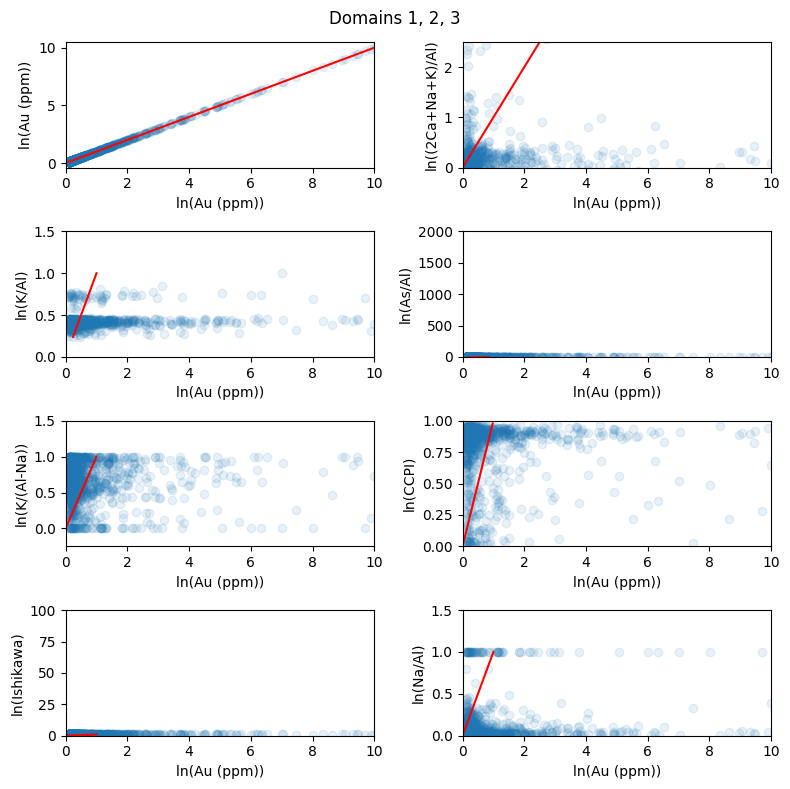

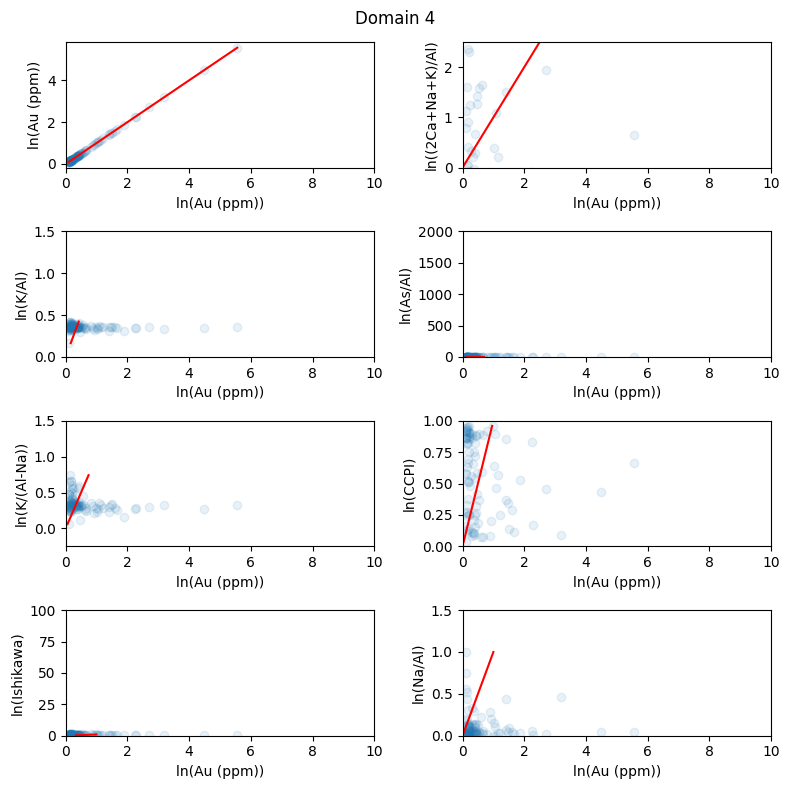

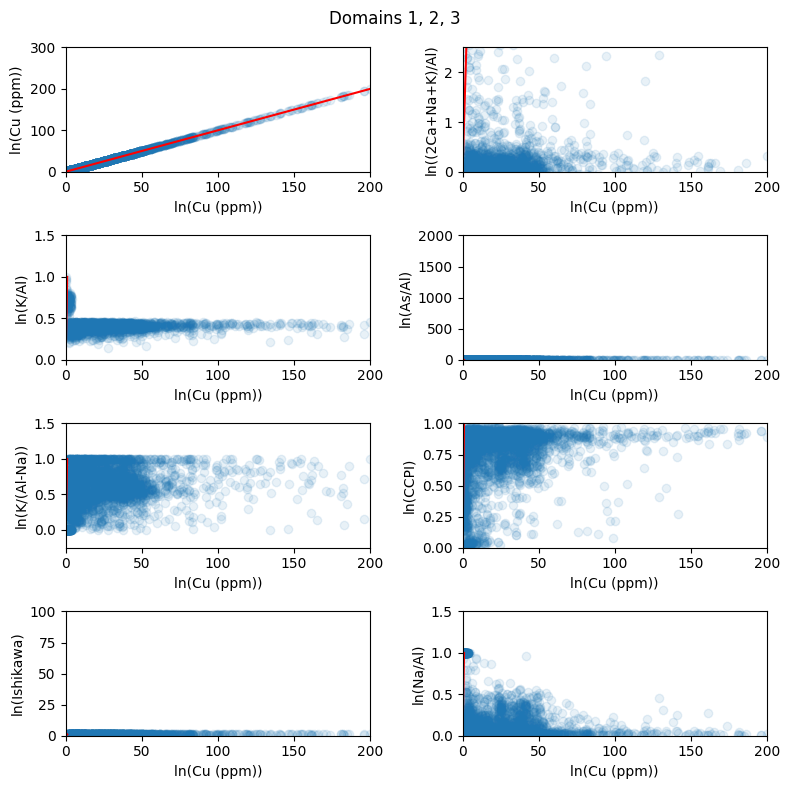

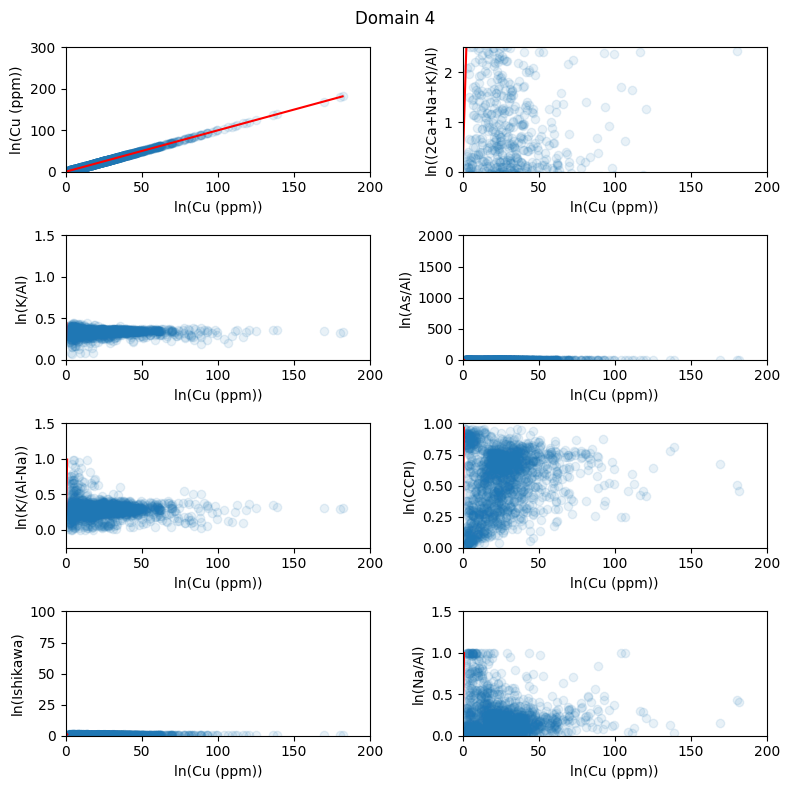

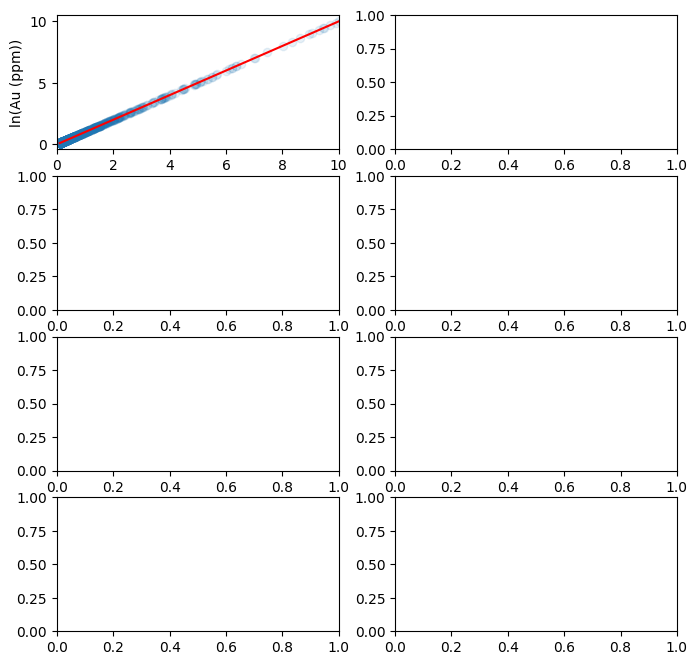

In [ ]:
def create_correlation_plots(data_frame: geopandas.GeoDataFrame, columns: list[str], target_column: str = None, x_min: float = None, x_max: float = None, title: str = None, type: str = None):
    NUMBER_OF_COLUMNS: int = 2
    NUMBER_OF_ROWS: int = int(math.ceil(len(columns) / NUMBER_OF_COLUMNS))

    figure: matplotlib.figure.Figure
    axes: numpy.ndarray[matplotlib.axes.Axes]
    figure, axes = matplotlib.pyplot.subplots(nrows = NUMBER_OF_ROWS, ncols = NUMBER_OF_COLUMNS, figsize = (8, 8))

    for index, column in enumerate(columns):
        row_index: int = int(math.floor(index / NUMBER_OF_COLUMNS))
        column_index: int = index % NUMBER_OF_COLUMNS
        
        if column != target_column and type == PLOT_TYPE_DENSITY:
            seaborn.kdeplot(data_frame, x = target_column, y = column, ax = axes[row_index, column_index], fill = False, cmap = "YlGn", thresh = 0.05)
        else:
            axes[row_index, column_index].scatter(data_frame[target_column], data_frame[column], alpha = 0.1)

        axes[row_index, column_index].set_ylabel(column)

        if column in COLUMN_LIMITS:
            y_min: Optional[float] = COLUMN_LIMITS[column][0]
            y_max: Optional[float] = COLUMN_LIMITS[column][1]

            axes[row_index, column_index].set_ylim(y_min, y_max)
        axes[row_index, column_index].set_xlim(x_min, x_max)
        axes[row_index, column_index].set_xlabel(target_column)

        X = data_frame[column]
        Y = data_frame[column]

        mask = ~numpy.isnan(X) & ~numpy.isinf(X) & ~numpy.isnan(Y) & ~numpy.isinf(Y)

        linear_regression_result: scipy.stats.LinregressResult = scipy.stats.linregress(X[mask], Y[mask])
        best_fit_function: IFunction = Polynomial([linear_regression_result.intercept, linear_regression_result.slope])
        best_fit_X, best_fit_Y = best_fit_function.to_discrete(X[mask].min(), X[mask].max(), 1000)
        axes[row_index, column_index].plot(best_fit_X, best_fit_Y, linestyle = "-", color = "red")
        axes[row_index, column_index].set_xlabel(f"ln({target_column})")
        axes[row_index, column_index].set_ylabel(f"ln({column})")
        
    figure.suptitle(title)
    figure.tight_layout()
    figure.show()

create_correlation_plots(area_1_data_frame[area_1_data_frame[GOLD_COLUMN].ge(0.1) & area_1_data_frame[GOLD_COLUMN].le(10)], [GOLD_COLUMN] + RATIO_COLUMNS, GOLD_COLUMN, x_min = 0, x_max = 10, title = "Domains 1, 2, 3", type = None)
create_correlation_plots(area_2_data_frame[area_2_data_frame[GOLD_COLUMN].ge(0.1) & area_2_data_frame[GOLD_COLUMN].le(10)], [GOLD_COLUMN] + RATIO_COLUMNS, GOLD_COLUMN, x_min = 0, x_max = 10, title = "Domain 4", type = None)

create_correlation_plots(area_1_data_frame[area_1_data_frame[COPPER_COLUMN].ge(0.1) & area_1_data_frame[COPPER_COLUMN].le(200)], [COPPER_COLUMN] + RATIO_COLUMNS, COPPER_COLUMN, x_min = 0, x_max = 200, title = "Domains 1, 2, 3", type = None)
create_correlation_plots(area_2_data_frame[area_2_data_frame[COPPER_COLUMN].ge(0.1) & area_2_data_frame[COPPER_COLUMN].le(200)], [COPPER_COLUMN] + RATIO_COLUMNS, COPPER_COLUMN, x_min = 0, x_max = 200, title = "Domain 4", type = None)

create_correlation_plots(area_1_data_frame[area_1_data_frame[GOLD_COLUMN].ge(0.1) & area_1_data_frame[GOLD_COLUMN].le(10)], [GOLD_COLUMN] + RATIO_COLUMNS, GOLD_COLUMN, x_min = 0, x_max = 10, title = "Domains 1, 2, 3", type = PLOT_TYPE_DENSITY)
create_correlation_plots(area_2_data_frame[area_2_data_frame[GOLD_COLUMN].ge(0.1) & area_2_data_frame[GOLD_COLUMN].le(10)], [GOLD_COLUMN] + RATIO_COLUMNS, GOLD_COLUMN, x_min = 0, x_max = 10, title = "Domain 4", type = PLOT_TYPE_DENSITY)

create_correlation_plots(area_1_data_frame[area_1_data_frame[COPPER_COLUMN].ge(0.1) & area_1_data_frame[COPPER_COLUMN].le(200)], [COPPER_COLUMN] + RATIO_COLUMNS, COPPER_COLUMN, x_min = 0, x_max = 200, title = "Domains 1, 2, 3", type = PLOT_TYPE_DENSITY)
create_correlation_plots(area_2_data_frame[area_2_data_frame[COPPER_COLUMN].ge(0.1) & area_2_data_frame[COPPER_COLUMN].le(200)], [COPPER_COLUMN] + RATIO_COLUMNS, COPPER_COLUMN, x_min = 0, x_max = 200, title = "Domain 4", type = PLOT_TYPE_DENSITY)

In [ ]:
def plot_manual_power_fits(data_frame: geopandas.GeoDataFrame, subset_data_frame: geopandas.GeoDataFrame, columns: list[str], target_column: str) -> None:
    def collate_data_frame(data_frame: geopandas.GeoDataFrame, subset_data_frame: geopandas.GeoDataFrame, columns: list[str]) -> Iterable[pandas.Series]:
        DISTANCE_COLUMN: str = "Distance"
        series: dict[pandas.Series] = dict()

        series[DISTANCE_COLUMN] = pandas.Series(name = DISTANCE_COLUMN)
        for column in columns:
            series[column] = pandas.Series(name = column)

        for index, row in subset_data_frame.iterrows():
            relevant_data_frame: geopandas.GeoDataFrame = data_frame.copy()
            relevant_data_frame[DISTANCE_COLUMN] = relevant_data_frame[GEOMETRY_COLUMN].apply(lambda x: distance(x, row[GEOMETRY_COLUMN]))
            relevant_data_frame = relevant_data_frame[relevant_data_frame[DISTANCE_COLUMN].le(RADIUS)]

            series[DISTANCE_COLUMN] = pandas.concat([series[DISTANCE_COLUMN], relevant_data_frame[DISTANCE_COLUMN]], ignore_index = True)
            
            for column in columns:
                series[column] = pandas.concat([series[column], relevant_data_frame[column]])

        for x in series.values():
            x.reset_index(inplace = True, drop = True)

        return pandas.concat(series.values(), axis = 1)

    analysis_data_frame: pandas.DataFrame = collate_data_frame(data_frame, subset_data_frame, columns)

    for column in RATIO_COLUMNS + RATIO_CONSTITUTENT_COLUMNS:
        def log(x):
            try:
                return math.log(x)
            except ValueError:
                return -math.inf

        figure, axes = matplotlib.pyplot.subplots(nrows = 1, ncols = 3, figsize = (24, 8))

        X = analysis_data_frame[target_column].apply(log)
        Y = analysis_data_frame[column].apply(log)

        axes[0].scatter(X, Y, alpha = 0.1)

        mask = ~numpy.isnan(X) & ~numpy.isinf(X) & ~numpy.isnan(Y) & ~numpy.isinf(Y)

        linear_regression_result: scipy.stats.LinregressResult = scipy.stats.linregress(X[mask], Y[mask])
        best_fit_function: IFunction = Polynomial([linear_regression_result.intercept, linear_regression_result.slope])
        best_fit_X, best_fit_Y = best_fit_function.to_discrete(X[mask].min(), X[mask].max(), 1000)
        axes[0].plot(best_fit_X, best_fit_Y, linestyle = "-", color = "red")
        axes[0].set_xlabel(f"ln({target_column})")
        axes[0].set_ylabel(f"ln({column})")

        try:
            seaborn.kdeplot(analysis_data_frame, x = target_column, y = column, ax = axes[1], fill = False, cmap = "YlGn", thresh = 0)
        except:
            pass
        axes[1].set_xlim(0, RADIUS)
        
        if column in COLUMN_LIMITS:
            y_min: Optional[float] = COLUMN_LIMITS[column][0]
            y_max: Optional[float] = COLUMN_LIMITS[column][1]
            axes[1].set_ylim(y_min, y_max)

        axes[1].set_xlabel("Distance (m)")
        axes[1].set_ylabel(column)

        X = analysis_data_frame[target_column]
        Y = analysis_data_frame[column]

        axes[2].scatter(X, Y, color = "green", alpha = 0.1)

        def f(x, intercept: float, gradient: float) -> float:
            return math.exp(intercept) * math.pow(x, gradient)
        
        axes[2].plot(numpy.linspace(0.1, RADIUS, 1000), [f(x, linear_regression_result.intercept, linear_regression_result.slope) for x in numpy.linspace(0.1, RADIUS, 1000)], linestyle = "-", color = "red")
        axes[2].set_xlim(0, RADIUS)
        
        if column in COLUMN_LIMITS:
            y_min: Optional[float] = COLUMN_LIMITS[column][0]
            y_max: Optional[float] = COLUMN_LIMITS[column][1]
            axes[2].set_ylim(y_min, y_max)

        axes[2].set_xlabel("Distance (m)")
        axes[2].set_ylabel(column)

        figure.suptitle(f"L: {str(best_fit_function)} (P = {linear_regression_result.pvalue:.2f}, Δm = {linear_regression_result.stderr:.2f})")

        figure.show()

plot_manual_power_fits(area_1_data_frame, area_1_data_frame[area_1_data_frame[GOLD_COLUMN] > 0.5], [GOLD_COLUMN] + RATIO_COLUMNS + RATIO_CONSTITUTENT_COLUMNS, GOLD_COLUMN)
plot_manual_power_fits(area_2_data_frame, area_2_data_frame[area_2_data_frame[GOLD_COLUMN] > 0.5], [GOLD_COLUMN] + RATIO_COLUMNS + RATIO_CONSTITUTENT_COLUMNS, GOLD_COLUMN)
# plot_manual_power_fits(area_1_data_frame, area_1_data_frame[area_1_data_frame[COPPER_COLUMN] > 100], [COPPER_COLUMN] + RATIO_COLUMNS + RATIO_CONSTITUTENT_COLUMNS, COPPER_COLUMN)
# plot_manual_power_fits(area_2_data_frame, area_2_data_frame[area_2_data_frame[COPPER_COLUMN] > 100], [COPPER_COLUMN] + RATIO_COLUMNS + RATIO_CONSTITUTENT_COLUMNS, COPPER_COLUMN)

# Null Domain (Deprecated)

In [ ]:
# def create_null_domain_plots(data_frame: geopandas.GeoDataFrame, reference_points_data_frame: geopandas.GeoDataFrame, columns: list[str]):
#     for index, row in reference_points_data_frame.iterrows():
#         subset_data_frame: geopandas.DataFrame = data_frame.copy()

#         DISTANCE_COLUMN: str = "Distance"
#         NUMBER_OF_COLUMNS: int = 2
#         NUMBER_OF_ROWS: int = int(math.ceil(len(columns) / NUMBER_OF_COLUMNS))

#         subset_data_frame[DISTANCE_COLUMN] = subset_data_frame.apply(lambda x: distance(x[GEOMETRY_COLUMN], row[GEOMETRY_COLUMN]), axis = 1)
        
#         figure: matplotlib.figure.Figure
#         axes: numpy.ndarray[matplotlib.axes.Axes]
#         figure, axes = matplotlib.pyplot.subplots(nrows = NUMBER_OF_ROWS, ncols = NUMBER_OF_COLUMNS, figsize = (8, 8))

#         for index, column in enumerate(columns):            
#             y_min: Optional[float] = None
#             y_max: Optional[float] = None

#             if column in COLUMN_LIMITS:
#                 y_min = COLUMN_LIMITS[column][0]
#                 y_max = COLUMN_LIMITS[column][1]

#             row_index: int = int(math.floor(index / NUMBER_OF_COLUMNS))
#             column_index: int = index % NUMBER_OF_COLUMNS
#             axes[row_index, column_index].scatter(subset_data_frame[DISTANCE_COLUMN], subset_data_frame[column])
#             axes[row_index, column_index].set_ylabel(column)
#             axes[row_index, column_index].set_ylim(y_min, y_max)

#             if column in COLUMN_FIT_OPTIONS:
#                 best_fit_subset_data_frame: geopandas.GeoDataFrame = subset_data_frame[subset_data_frame[column].apply(lambda x: (y_min is None or y_min <= x) and (y_max is None or x <= y_max))]
#                 # linear_regression_result: scipy.stats.LinregressResult = scipy.stats.linregress(best_fit_subset_data_frame[DISTANCE_COLUMN], best_fit_subset_data_frame[column])
#                 # best_fit_function: IFunction = Polynomial([linear_regression_result.intercept, linear_regression_result.slope])
#                 best_fit_function: IFunction = fit_function(Polynomial, best_fit_subset_data_frame[DISTANCE_COLUMN], best_fit_subset_data_frame[column], bounds = Bounds([0], [10000]))
#                 best_fit_X, best_fit_Y = best_fit_function.to_discrete(0, 150, 1000)
#                 axes[row_index, column_index].plot(best_fit_X, best_fit_Y, linestyle = "-", color = "red")
#                 axes[row_index, column_index].set_xlabel(str(best_fit_function))

#             axes[row_index, column_index].set_xlim(0, 150)

#         figure.supxlabel("Distance (m)")
#         title: str = f"{row[ID_COLUMN]} - {row[TARGET_COLUMN]} {TARGET_COLUMN}"

#         figure.suptitle(title)
#         figure.tight_layout()
#         figure.show()

# null_domain_data_frame: geopandas.GeoDataFrame = data_frame[data_frame[GEOMETRY_COLUMN].apply(lambda x: NULL_DOMAIN_BOTTOM_LEFT.x <= x.x and x.x <= NULL_DOMAIN_TOP_RIGHT.x and NULL_DOMAIN_BOTTOM_LEFT.y <= x.y and x.y <= NULL_DOMAIN_TOP_RIGHT.y)]
# null_domain_reference_data_frame: geopandas.GeoDataFrame = null_domain_data_frame[null_domain_data_frame[ID_COLUMN] == "M021872"]

# create_null_domain_plots(null_domain_data_frame, null_domain_data_frame[null_domain_data_frame[ID_COLUMN] == "M021872"], [TARGET_COLUMN] + RATIO_COLUMNS)
# create_null_domain_plots(null_domain_data_frame, null_domain_data_frame[null_domain_data_frame[ID_COLUMN] == "M021872"], RATIO_CONSTITUTENT_COLUMNS)

# Ad-Hoc

In [ ]:
# data_subset = data_frame[data_frame[TARGET_COLUMN].ge(1)][data_frame["CCPI"].le(1)]
# power: PowerWithOffset = fit_function(PowerWithOffset, data_subset[TARGET_COLUMN], data_subset["CCPI"], [-1], fixed_parameters = { "r": -1, "C": 1 }, bounds = ([-numpy.inf], [0]))
# print(power)

# figure: matplotlib.figure.Figure
# axes: numpy.ndarray[matplotlib.axes.Axes]
# figure, axes = matplotlib.pyplot.subplots(nrows = 1, ncols = 1, figsize = (8, 8))
# axes.scatter(data_frame[TARGET_COLUMN], data_frame["CCPI"])
# axes.plot(numpy.linspace(0, 50, 100), [power(x) for x in numpy.linspace(0, 50, 100)], 'r-')

# axes.set_xlim(0, 50)
# axes.set_ylim(0, 1)

# data_subset = data_frame[data_frame[TARGET_COLUMN].ge(0.01)]
# power: PowerWithOffset = fit_function(Power, data_subset[TARGET_COLUMN], data_subset["Ca (%)"], [1], fixed_parameters = { "r": -1 }, bounds = ([0], [100]))
# print(power)

# figure: matplotlib.figure.Figure
# axes: numpy.ndarray[matplotlib.axes.Axes]
# figure, axes = matplotlib.pyplot.subplots(nrows = 1, ncols = 1, figsize = (8, 8))
# axes.scatter(data_frame[TARGET_COLUMN], data_frame["Ca (%)"])
# axes.plot(numpy.linspace(0, 50, 100), [power(x) for x in numpy.linspace(0, 50, 100)], 'r-')

# axes.set_xlim(0, 50)

# data_subset = data_frame[data_frame[TARGET_COLUMN].ge(2)][data_frame["Na/Al"].le(1)]
# power: Power = fit_function(Power, data_subset[TARGET_COLUMN], data_subset["Na/Al"], [0.4], fixed_parameters = { "r": -1 }, bounds = ([0], [numpy.inf]))
# print(power)

# figure: matplotlib.figure.Figure
# axes: numpy.ndarray[matplotlib.axes.Axes]
# figure, axes = matplotlib.pyplot.subplots(nrows = 1, ncols = 1, figsize = (8, 8))
# axes.scatter(data_frame[TARGET_COLUMN], data_frame["Na/Al"])
# axes.plot(numpy.linspace(0, 50, 100), [power(x) for x in numpy.linspace(0, 50, 100)], 'r-')

# axes.set_xlim(0, 50)
# axes.set_ylim(0, 1)